In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import datasets
date_df = pd.read_csv('dim_date.csv')
makers_df = pd.read_csv('/content/electric_vehicle_sales_by_makers.csv')
state_df = pd.read_csv('/content/electric_vehicle_sales_by_state.csv')

In [3]:
# Preprocessing
makers_df['date'] = pd.to_datetime(makers_df['date'], dayfirst=True)
state_df['date'] = pd.to_datetime(state_df['date'], dayfirst=True)
date_df['date'] = pd.to_datetime(date_df['date'], dayfirst=True)

### **Dim Date**

In [4]:
date_df.shape

(36, 3)

In [5]:
date_df.head()

date  fiscal_year quarter
0 2021-04-01         2022      Q1
1 2021-05-01         2022      Q1
2 2021-06-01         2022      Q1
3 2021-07-01         2022      Q2
4 2021-08-01         2022      Q2

In [6]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         36 non-null     datetime64[ns]
 1   fiscal_year  36 non-null     int64         
 2   quarter      36 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 996.0+ bytes


In [7]:
date_df.describe()

date  fiscal_year
count                   36    36.000000
mean   2022-09-15 18:40:00  2023.000000
min    2021-04-01 00:00:00  2022.000000
25%    2021-12-24 06:00:00  2022.000000
50%    2022-09-16 00:00:00  2023.000000
75%    2023-06-08 12:00:00  2024.000000
max    2024-03-01 00:00:00  2024.000000
std                    NaN     0.828079

### **EV Sales by Makers**

In [8]:
makers_df.shape

(816, 4)

In [9]:
makers_df.head()

date vehicle_category         maker  electric_vehicles_sold
0 2021-04-01       2-Wheelers  OLA ELECTRIC                       0
1 2022-04-01       2-Wheelers      OKAYA EV                       0
2 2021-05-01       2-Wheelers  OLA ELECTRIC                       0
3 2021-06-01       2-Wheelers  OLA ELECTRIC                       0
4 2021-07-01       2-Wheelers  OLA ELECTRIC                       0

In [10]:
makers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    816 non-null    datetime64[ns]
 1   vehicle_category        816 non-null    object        
 2   maker                   816 non-null    object        
 3   electric_vehicles_sold  816 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 25.6+ KB


In [11]:
makers_df.describe()

date  electric_vehicles_sold
count                  816              816.000000
mean   2022-09-21 03:30:00             2531.998775
min    2021-04-01 00:00:00                0.000000
25%    2022-01-01 00:00:00               42.000000
50%    2022-10-01 00:00:00              662.000000
75%    2023-07-01 00:00:00             2636.500000
max    2024-03-01 00:00:00            44630.000000
std                    NaN             4771.077333

In [12]:
# Plot top 5 EVs sold by makers
top5_makers = makers_df.groupby('maker')['electric_vehicles_sold'].sum().nlargest(5).reset_index()

# Plot
fig_top5 = px.bar(
    top5_makers,
    x='maker',
    y='electric_vehicles_sold',
    title='Top 5 EVs Sold by Maker',
    text='electric_vehicles_sold',
    color_discrete_sequence=['limegreen']
)
fig_top5.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white'
)
fig_top5.show()

In [13]:
# Plot bottom 5 EV Makers
bottom5_makers = makers_df.groupby('maker')['electric_vehicles_sold'].sum().nsmallest(5).reset_index()
# Plot
fig_bottom5 = px.bar(
    bottom5_makers,
    x='maker',
    y='electric_vehicles_sold',
    title='Bottom 5 EVs Sold by Maker',
    text='electric_vehicles_sold',
    color_discrete_sequence=['orange']
)
fig_bottom5.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white'
)
fig_bottom5.show()

In [14]:
# Peak and low season months for EV sales

# Extract the month name from the 'date' column and create a new 'month_name' column
makers_df['month_name'] = makers_df['date'].dt.strftime('%B')

# Group by the month name to find the peak and low months
peak_month = makers_df.groupby('month_name')['electric_vehicles_sold'].sum().nlargest(1).reset_index()
low_month = makers_df.groupby('month_name')['electric_vehicles_sold'].sum().nsmallest(1).reset_index()

print('Peak month:', peak_month['month_name'].values[0])
print('Low month:', low_month['month_name'].values[0])

Peak month: March
Low month: June


In [15]:
# Merge date info first to have 'fiscal_year' column available
makers_df = makers_df.merge(date_df, on='date', how='left')
state_df = state_df.merge(date_df, on='date', how='left')

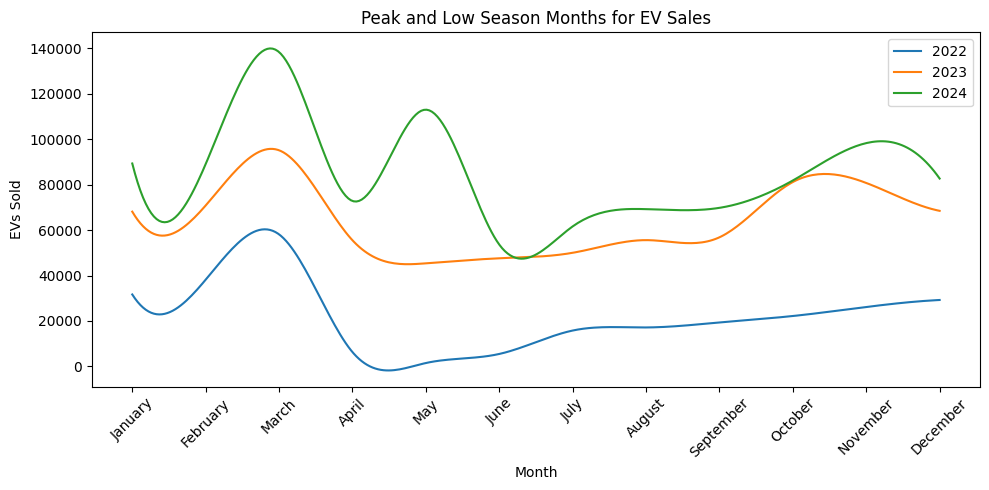

In [16]:
# Monthly trends for EV sales
monthly_sales = state_df.groupby([state_df['date'].dt.strftime('%B'), 'fiscal_year'])['electric_vehicles_sold'].sum().reset_index()
monthly_sales['Month_num'] = pd.to_datetime(monthly_sales['date'] + " 2024", format="%B %Y").dt.month
monthly_sales = monthly_sales.sort_values("Month_num")

plt.figure(figsize=(10, 5))
for year in [2022, 2023, 2024]:
    subset = monthly_sales[monthly_sales['fiscal_year'] == year]

    # Use spline interpolation to create a smoother curve
    x = np.arange(len(subset))
    y = subset['electric_vehicles_sold']
    from scipy.interpolate import make_interp_spline, BSpline
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3) # BSpline object
    ynew = spl(xnew)

    plt.plot(xnew, ynew, label=str(year))

plt.title("Peak and Low Season Months for EV Sales")
plt.xlabel("Month")
plt.ylabel("EVs Sold")
plt.legend()
plt.xticks(ticks=np.arange(len(monthly_sales['date'].unique())), labels=monthly_sales['date'].unique(), rotation=45)
plt.tight_layout()
plt.show()

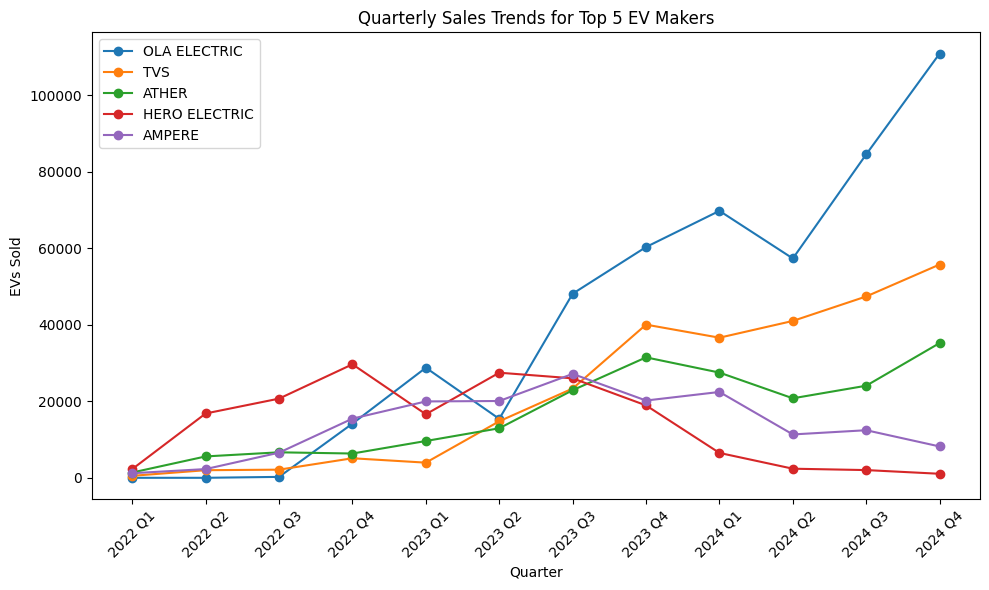

In [17]:
# Quarterly Trends (Top 5 makers)
top_makers = top5_makers['maker'].tolist()
quarterly_trends = makers_df[makers_df['maker'].isin(top_makers)].groupby(['maker', 'fiscal_year', 'quarter'])['electric_vehicles_sold'].sum().reset_index()

plt.figure(figsize=(10, 6))
for maker in top_makers:
    df = quarterly_trends[quarterly_trends['maker'] == maker]
    df['label'] = df['fiscal_year'].astype(str) + " " + df['quarter']
    plt.plot(df['label'], df['electric_vehicles_sold'], marker='o', label=maker)

plt.title("Quarterly Sales Trends for Top 5 EV Makers")
plt.xlabel("Quarter")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

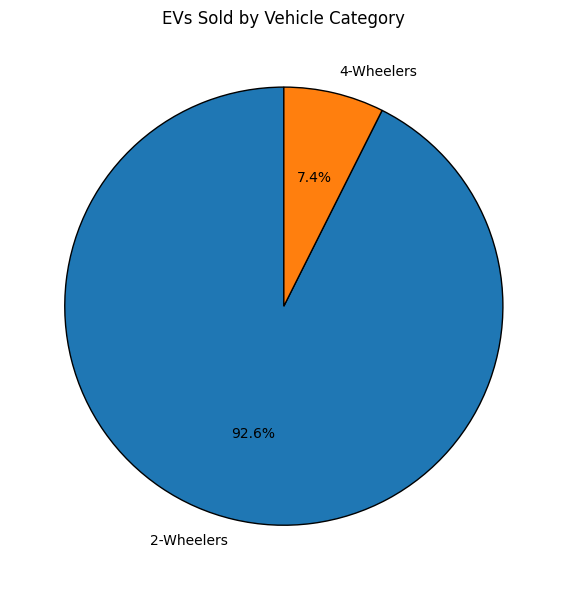

In [18]:
# EV sales by Vehicle Category
cat_sales = state_df.groupby('vehicle_category')['electric_vehicles_sold'].sum().reset_index()

plt.figure(figsize=(6, 6))
plt.pie(
    cat_sales['electric_vehicles_sold'],
    labels=cat_sales['vehicle_category'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("EVs Sold by Vehicle Category")
plt.tight_layout()
plt.show()

* Compound Annual Growth Rate (CAGR) : Used to track growth over time

  * CAGR = (Ending or max value)/ (Beginning or min value) ** (1/ years) - 1

* Penetration Rate: Used to measure market share or adoption level at a point of time

  * Penetration Rate (%) = (EV Sales/ Total Vehicle Sales) * 100

In [19]:
# # Merge date info first to have 'fiscal_year' column available
# Keep this merge here to ensure it runs before KPI calculation
# This line merges date_df into state_df, adding columns like 'fiscal_year'
state_df = state_df.merge(date_df[['date', 'fiscal_year']], on='date', how='left')
# This line merges date_df into makers_df, adding columns like 'fiscal_year'
makers_df = makers_df.merge(date_df[['date', 'fiscal_year']], on='date', how='left') # Also merge makers_df here if needed for later calculations

# Check if the merge was successful by printing columns and sample data
print("Columns after merge:", state_df.columns)
print("Sample state_df data after merge:")
print(state_df.head())

Columns after merge: Index(['date', 'state', 'vehicle_category', 'electric_vehicles_sold',
       'total_vehicles_sold', 'fiscal_year_x', 'quarter', 'fiscal_year_y'],
      dtype='object')
Sample state_df data after merge:
        date   state vehicle_category  electric_vehicles_sold  \
0 2021-04-01  Sikkim       2-Wheelers                       0   
1 2021-04-01  Sikkim       4-Wheelers                       0   
2 2021-05-01  Sikkim       2-Wheelers                       0   
3 2021-05-01  Sikkim       4-Wheelers                       0   
4 2021-06-01  Sikkim       2-Wheelers                       0   

   total_vehicles_sold  fiscal_year_x quarter  fiscal_year_y  
0                  398           2022      Q1           2022  
1                  361           2022      Q1           2022  
2                  113           2022      Q1           2022  
3                   98           2022      Q1           2022  
4                  229           2022      Q1           2022  


In [20]:
# This line merges date_df into state_df, adding columns like 'fiscal_year'
state_df = state_df.merge(date_df[['date', 'fiscal_year']], on='date', how='left')
# This line merges date_df into makers_df, adding columns like 'fiscal_year'
makers_df = makers_df.merge(date_df[['date', 'fiscal_year']], on='date', how='left')

In [21]:
# Check if 'fiscal_year' exists in state_df before grouping
if 'fiscal_year' not in state_df.columns:
    print("Error: 'fiscal_year' column not found in state_df after merging.")
else:
    # KPI metrics
    # Now 'fiscal_year' should be available in state_df
    total_vehicles = state_df['total_vehicles_sold'].sum()
    total_ev = state_df['electric_vehicles_sold'].sum()
    # Avoid division by zero
    penetration_rate = (total_ev / total_vehicles * 100) if total_vehicles > 0 else 0

    # CAGR Calculation
    # Group by 'fiscal_year' which is now in state_df
    ev_by_year = state_df.groupby('fiscal_year')['electric_vehicles_sold'].sum()
    # Check if the required fiscal years (2022, 2024) exist in the grouped data
    if 2022 in ev_by_year.index and 2024 in ev_by_year.index and ev_by_year[2022] > 0: # Add check for non-zero base year
        cagr = ((ev_by_year[2024] / ev_by_year[2022]) ** (1/2) - 1) * 100

        print(f"Total Vehicles: {total_vehicles:,}")
        print(f"Total EVs: {total_ev:,}")
        print(f"Penetration Rate: {penetration_rate:.2f}%")
        print(f"EV CAGR (2022–2024): {cagr:.2f}%")
    elif 2022 in ev_by_year.index and 2024 in ev_by_year.index and ev_by_year[2022] == 0:
         print("Cannot calculate CAGR: Electric vehicle sales in 2022 are zero.")
    else:
        print("Cannot calculate CAGR: Data for fiscal year 2022 or 2024 is missing.")

Total Vehicles: 57,220,252
Total EVs: 2,066,111
Penetration Rate: 3.61%
EV CAGR (2022–2024): 93.91%


In [22]:
# CAGR for Top Makers
maker_growth = makers_df.groupby(['maker', 'fiscal_year'])['electric_vehicles_sold'].sum().reset_index()
pivot = maker_growth.pivot(index='maker', columns='fiscal_year', values='electric_vehicles_sold').fillna(0)
pivot['CAGR'] = ((pivot[2024] / pivot[2022]).pow(1/2) - 1) * 100
pivot['EV Sold'] = pivot[2024]
pivot = pivot.loc[top_makers][['EV Sold', 'CAGR']].reset_index()

In [23]:
pivot

fiscal_year          maker   EV Sold        CAGR
0             OLA ELECTRIC  322489.0  373.217860
1                      TVS  180743.0  330.797883
2                    ATHER  107552.0  132.035792
3            HERO ELECTRIC   11949.0  -58.521466
4                   AMPERE   54388.0   46.014611

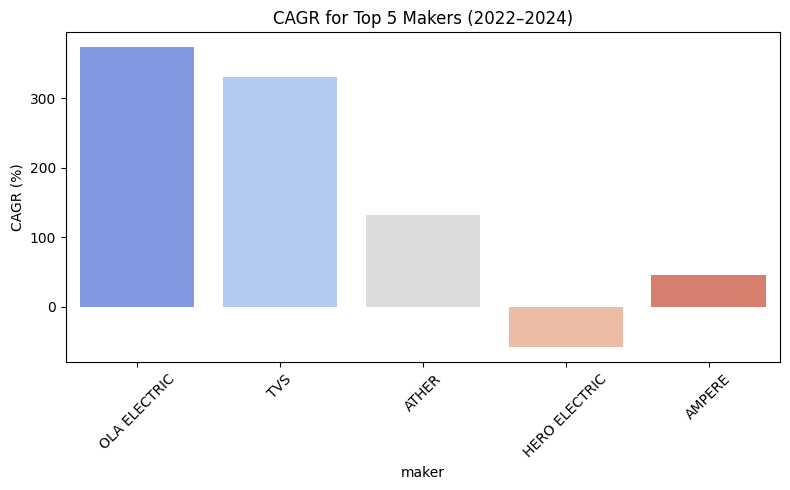

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(data=pivot, x='maker', y='CAGR', palette='coolwarm')
plt.title("CAGR for Top 5 Makers (2022–2024)")
plt.ylabel("CAGR (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Trend over time for both the categories
# Group by date and category
category_trend = makers_df.groupby(['date', 'vehicle_category'])['electric_vehicles_sold'].sum().reset_index()

# Plot
fig = px.line(
    category_trend,
    x='date',
    y='electric_vehicles_sold',
    color='vehicle_category',
    labels={'electric_vehicles_sold': 'EVs Sold', 'date': 'Date'},
    title='EV Sales Trend Over Time by Vehicle Category',
    markers=True
)

# Add hover template
fig.update_traces(mode="lines+markers", hovertemplate='Date: %{x}<br>Sales: %{y:,}')
fig.update_layout(legend_title_text='Vehicle Category')
fig.show()

In [26]:
# Top and bottom 5 makers of both categories

# Calculate total sales per maker and category
maker_sales = makers_df.groupby(['vehicle_category', 'maker'])['electric_vehicles_sold'].sum().reset_index()

# Get top and bottom 5 makers for each category
def top_bottom_plot_data(df, category):
    subset = df[df['vehicle_category'] == category]
    top5 = subset.nlargest(5, 'electric_vehicles_sold')
    bottom5 = subset.nsmallest(5, 'electric_vehicles_sold')
    return top5, bottom5

top2w, bottom2w = top_bottom_plot_data(maker_sales, "2-Wheelers")
top4w, bottom4w = top_bottom_plot_data(maker_sales, "4-Wheelers")

# Create subplots for interactive Plotly dashboard
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "Top 5 EV Makers - 2-Wheelers", "Bottom 5 EV Makers - 2-Wheelers",
    "Top 5 EV Makers - 4-Wheelers", "Bottom 5 EV Makers - 4-Wheelers"
])

# Add Top 5 - 2W
fig.add_trace(go.Bar(x=top2w['electric_vehicles_sold'], y=top2w['maker'], orientation='h', name='Top 2W', marker_color='green'), row=1, col=1)

# Add Bottom 5 - 2W
fig.add_trace(go.Bar(x=bottom2w['electric_vehicles_sold'], y=bottom2w['maker'], orientation='h', name='Bottom 2W', marker_color='red'), row=1, col=2)

# Add Top 5 - 4W
fig.add_trace(go.Bar(x=top4w['electric_vehicles_sold'], y=top4w['maker'], orientation='h', name='Top 4W', marker_color='blue'), row=2, col=1)

# Add Bottom 5 - 4W
fig.add_trace(go.Bar(x=bottom4w['electric_vehicles_sold'], y=bottom4w['maker'], orientation='h', name='Bottom 4W', marker_color='orange'), row=2, col=2)

fig.update_layout(height=700, width=1000, title_text="Top and Bottom 5 EV Makers by Vehicle Category (Interactive)")
fig.update_yaxes(autorange="reversed")
fig.show()


### **Statewise Sales**

In [27]:
state_df.head()

date   state vehicle_category  electric_vehicles_sold  \
0 2021-04-01  Sikkim       2-Wheelers                       0   
1 2021-04-01  Sikkim       4-Wheelers                       0   
2 2021-05-01  Sikkim       2-Wheelers                       0   
3 2021-05-01  Sikkim       4-Wheelers                       0   
4 2021-06-01  Sikkim       2-Wheelers                       0   

   total_vehicles_sold  fiscal_year_x quarter  fiscal_year_y  fiscal_year  
0                  398           2022      Q1           2022         2022  
1                  361           2022      Q1           2022         2022  
2                  113           2022      Q1           2022         2022  
3                   98           2022      Q1           2022         2022  
4                  229           2022      Q1           2022         2022

In [28]:
# Get the revenue growth rate of 4-wheeler and 2-wheelers for 2022 vs 2024 and 2023 vs 2024, assuming an average unit price. 2 wheelers - Rs. 85000, 4 wheelers - Rs. 1500000
# Define average prices
price_2w = 85000
price_4w = 1500000

# Calculate revenue for each row
state_df['revenue'] = state_df.apply(lambda row: row['electric_vehicles_sold'] * (price_2w if row['vehicle_category'] == '2-Wheelers' else price_4w), axis=1)

# Group by year and category, then sum revenue
revenue_summary = state_df.groupby(['fiscal_year', 'vehicle_category'])['revenue'].sum().unstack()

# Calculate growth rates
growth_2022_2024 = ((revenue_summary.loc[2024] - revenue_summary.loc[2022]) / revenue_summary.loc[2022]) * 100
growth_2023_2024 = ((revenue_summary.loc[2024] - revenue_summary.loc[2023]) / revenue_summary.loc[2023]) * 100

revenue_summary, growth_2022_2024, growth_2023_2024

(vehicle_category   2-Wheelers    4-Wheelers
 fiscal_year                                
 2022              21468705000   27865500000
 2023              61871755000   71197500000
 2024              79278820000  130351500000,
 vehicle_category
 2-Wheelers    269.276209
 4-Wheelers    367.788125
 dtype: float64,
 vehicle_category
 2-Wheelers    28.134106
 4-Wheelers    83.084378
 dtype: float64)

In [29]:
from scipy.interpolate import make_interp_spline, BSpline

state_revenue = state_df.groupby('state')['revenue'].sum().nlargest(10).reset_index()

# Apply spline interpolation
x = np.arange(len(state_revenue))
y = state_revenue['revenue']

# 300 represents the number of points to make between x.min() and x.max()
xnew = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)  # BSpline object with k=3 for cubic spline
ynew = spl(xnew)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=xnew,  # Use the new smoother x values
    y=ynew,  # Use the new smoother y values
    mode='lines', # Only lines for a smooth curve, remove markers and text
    line=dict(color="red")
))

# Add original data points as markers for context (optional)
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(color="blue", size=8),
    name='Original Data Points'
))

fig.update_layout(
    title="Top 10 States wise revenue trends",
    height=400,
    xaxis=dict(
        tickvals=x,
        ticktext=state_revenue['state'] # Set tick labels to state names
    )
)
fig.show()

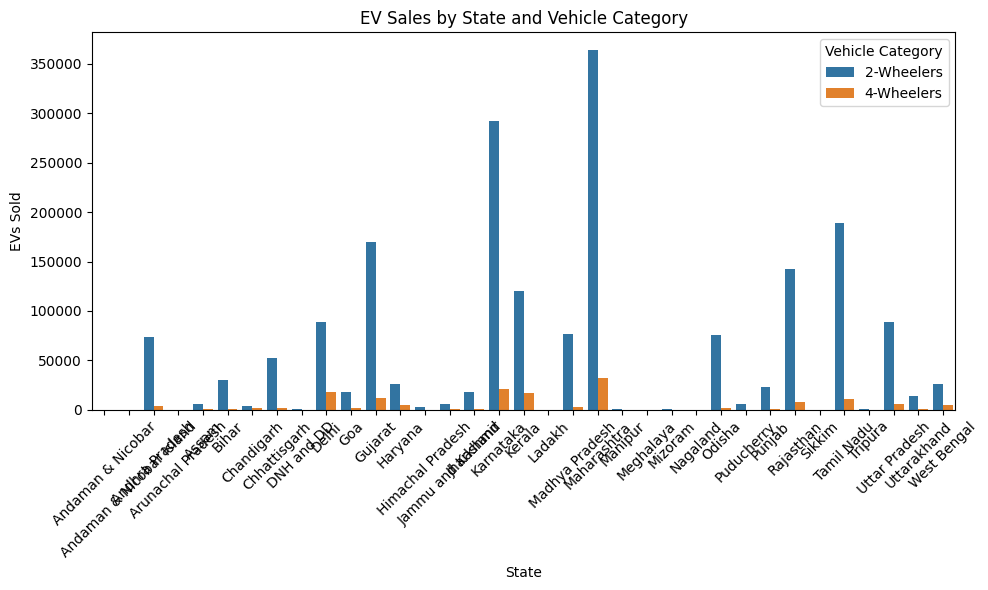

In [30]:
# Plot Which state sold what category
state_cat = state_df.groupby(['state', 'vehicle_category'])['electric_vehicles_sold'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_cat, x='state', y='electric_vehicles_sold', hue='vehicle_category')
plt.title("EV Sales by State and Vehicle Category")
plt.xlabel("State")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.legend(title="Vehicle Category")
plt.tight_layout()
plt.show()

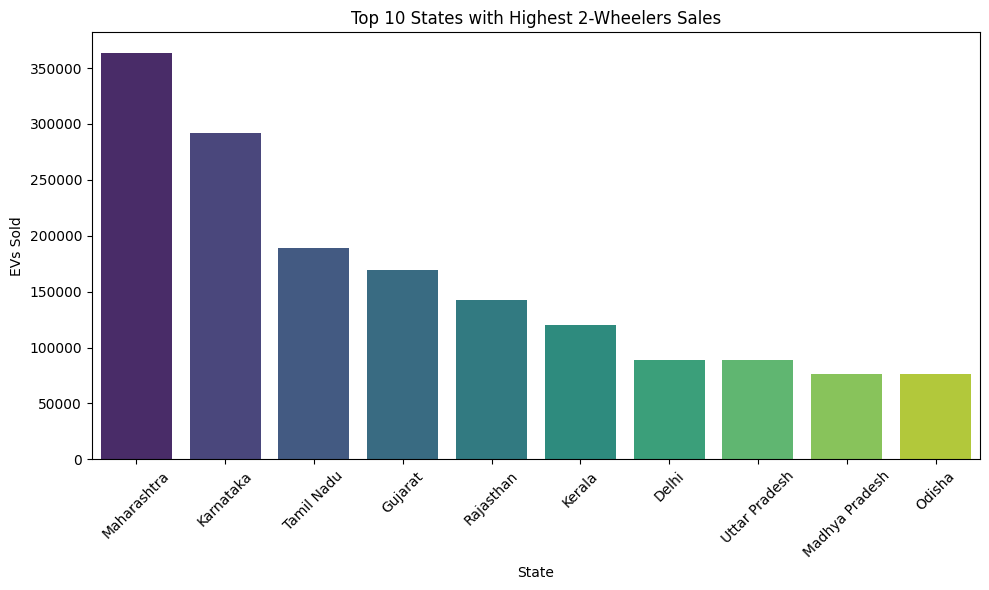

In [31]:
# Which state sold highest 2W
state_2w = state_df[state_df['vehicle_category'] == '2-Wheelers'].groupby('state')['electric_vehicles_sold'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_2w, x='state', y='electric_vehicles_sold', palette = 'viridis')
plt.title("Top 10 States with Highest 2-Wheelers Sales")
plt.xlabel("State")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

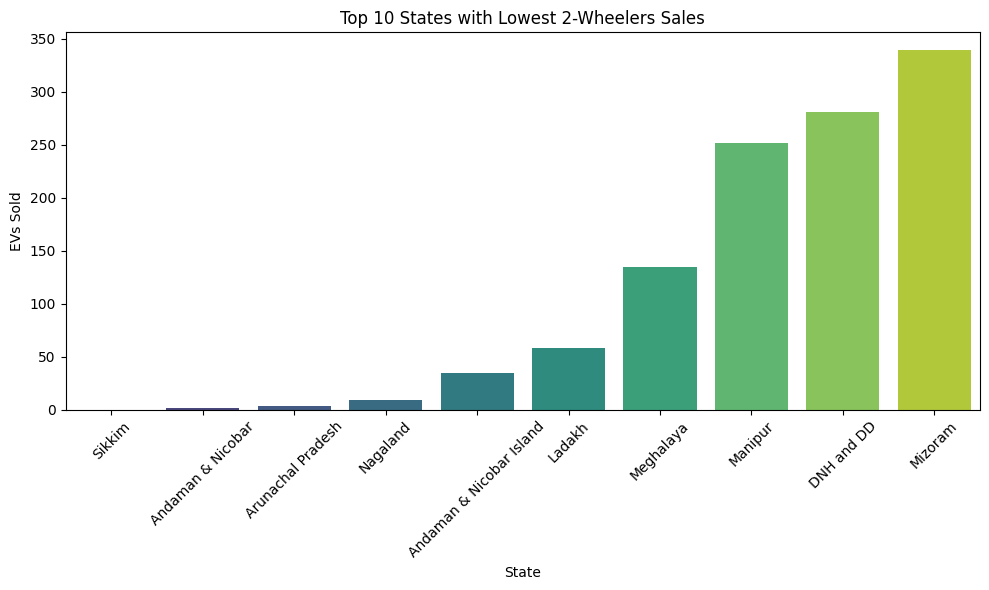

In [32]:
# Which state sold lowerst 2W
state_2w = state_df[state_df['vehicle_category'] == '2-Wheelers'].groupby('state')['electric_vehicles_sold'].sum().nsmallest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_2w, x='state', y='electric_vehicles_sold', palette = 'viridis')
plt.title("Top 10 States with Lowest 2-Wheelers Sales")
plt.xlabel("State")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

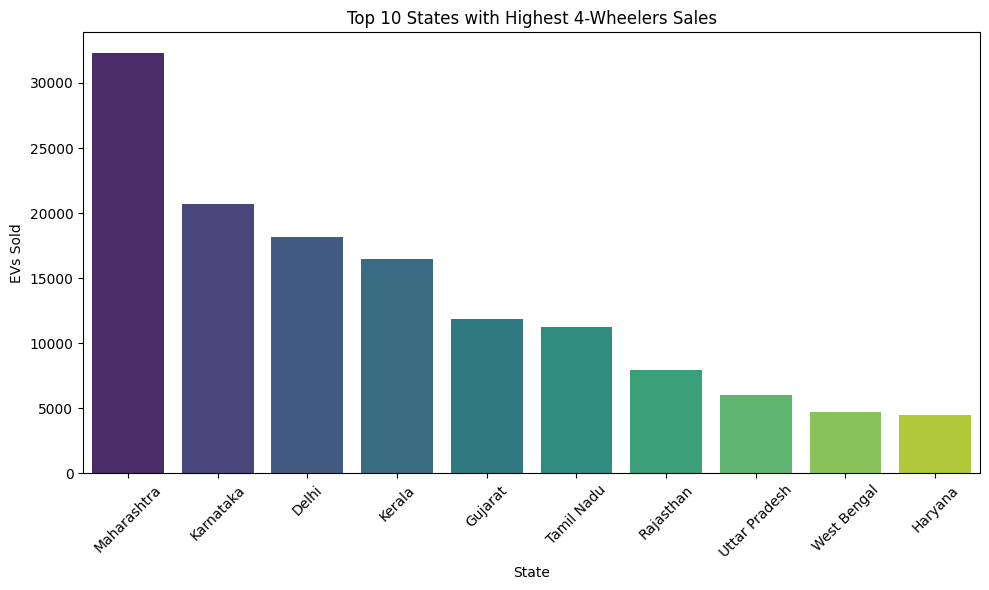

In [33]:
# Which state sold highest 4W
state_4w = state_df[state_df['vehicle_category'] == '4-Wheelers'].groupby('state')['electric_vehicles_sold'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_4w, x='state', y='electric_vehicles_sold', palette = 'viridis')
plt.title("Top 10 States with Highest 4-Wheelers Sales")
plt.xlabel("State")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

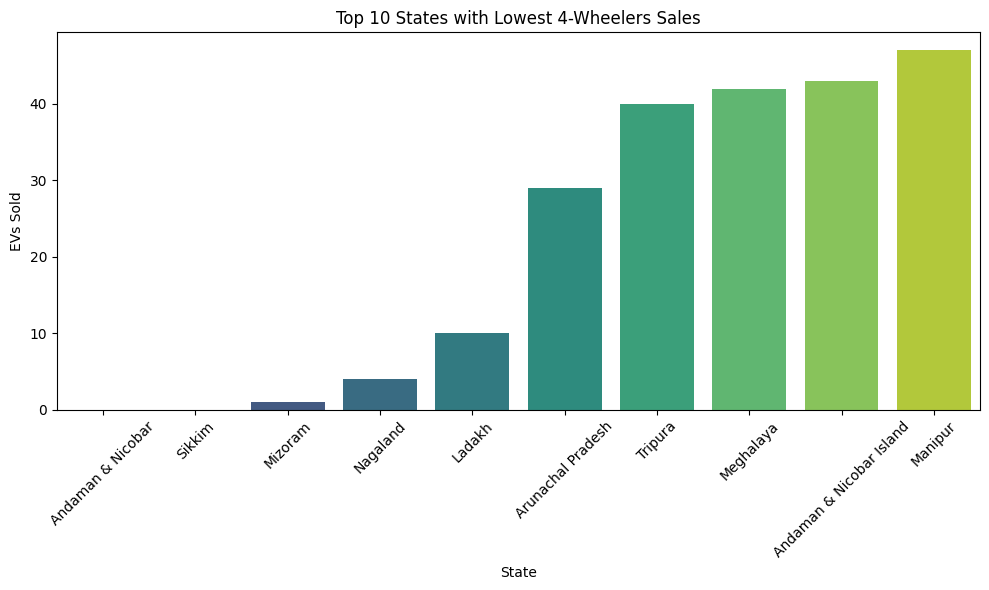

In [34]:
# Which state sold lowest 4 W
state_4w = state_df[state_df['vehicle_category'] == '4-Wheelers'].groupby('state')['electric_vehicles_sold'].sum().nsmallest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_4w, x='state', y='electric_vehicles_sold', palette = 'viridis')
plt.title("Top 10 States with Lowest 4-Wheelers Sales")
plt.xlabel("State")
plt.ylabel("EVs Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Group by state and sum electric and total vehicles
state_summary = state_df.groupby('state')[['electric_vehicles_sold', 'total_vehicles_sold']].sum().reset_index()

# Calculate penetration rate
state_summary['penetration_rate'] = (state_summary['electric_vehicles_sold'] / state_summary['total_vehicles_sold']) * 100

# Sort by penetration rate descending
top_states_by_penetration = state_summary.sort_values(by='penetration_rate', ascending=False)

top_states_by_penetration.head(10)

state  electric_vehicles_sold  total_vehicles_sold  penetration_rate
10          Goa                   19684               199970          9.843477
16    Karnataka                  312995              3994329          7.835984
9         Delhi                  107312              1588436          6.755828
17       Kerala                  137060              2064677          6.638326
20  Maharashtra                  396045              6101429          6.491020
25       Odisha                   78267              1688794          4.634491
28    Rajasthan                  150366              3307591          4.546088
11      Gujarat                  181389              4125551          4.396722
30   Tamil Nadu                  200062              4652363          4.300223
6    Chandigarh                    5279               130628          4.041247

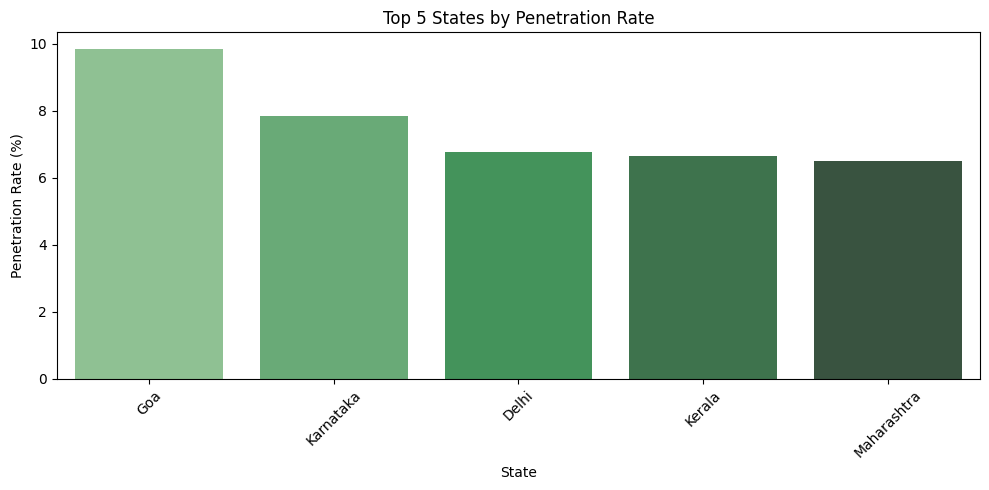

In [36]:
# Plot top 5 states by penetration rate
plt.figure(figsize=(10, 5))
sns.barplot(x='state', y='penetration_rate', data=top_states_by_penetration.head(5), palette='Greens_d')
plt.title("Top 5 States by Penetration Rate")
plt.ylabel("Penetration Rate (%)")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

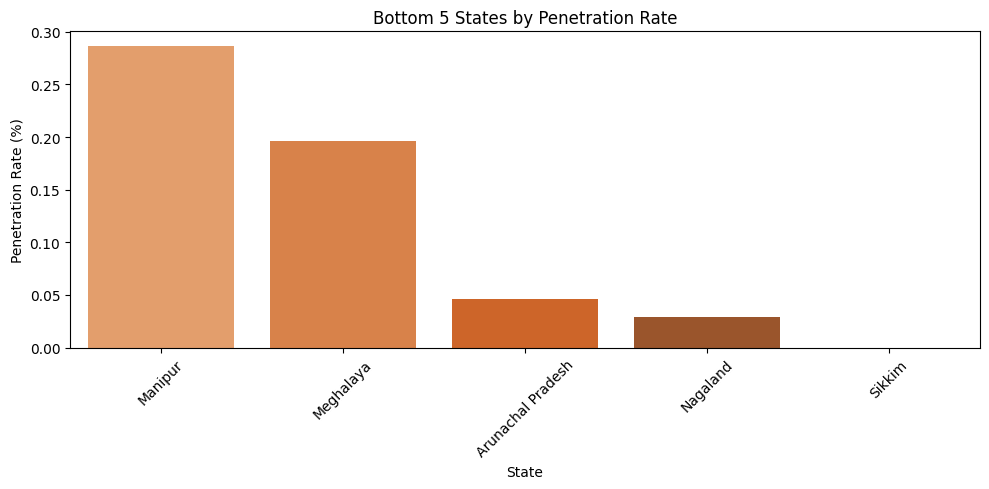

In [37]:
# Plot bottom 5 states by penetration rate
plt.figure(figsize=(10, 5))
sns.barplot(x='state', y='penetration_rate', data=top_states_by_penetration.tail(5), palette='Oranges_d')
plt.title("Bottom 5 States by Penetration Rate")
plt.ylabel("Penetration Rate (%)")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
state_df.head()

date   state vehicle_category  electric_vehicles_sold  \
0 2021-04-01  Sikkim       2-Wheelers                       0   
1 2021-04-01  Sikkim       4-Wheelers                       0   
2 2021-05-01  Sikkim       2-Wheelers                       0   
3 2021-05-01  Sikkim       4-Wheelers                       0   
4 2021-06-01  Sikkim       2-Wheelers                       0   

   total_vehicles_sold  fiscal_year_x quarter  fiscal_year_y  fiscal_year  \
0                  398           2022      Q1           2022         2022   
1                  361           2022      Q1           2022         2022   
2                  113           2022      Q1           2022         2022   
3                   98           2022      Q1           2022         2022   
4                  229           2022      Q1           2022         2022   

   revenue  
0        0  
1        0  
2        0  
3        0  
4        0

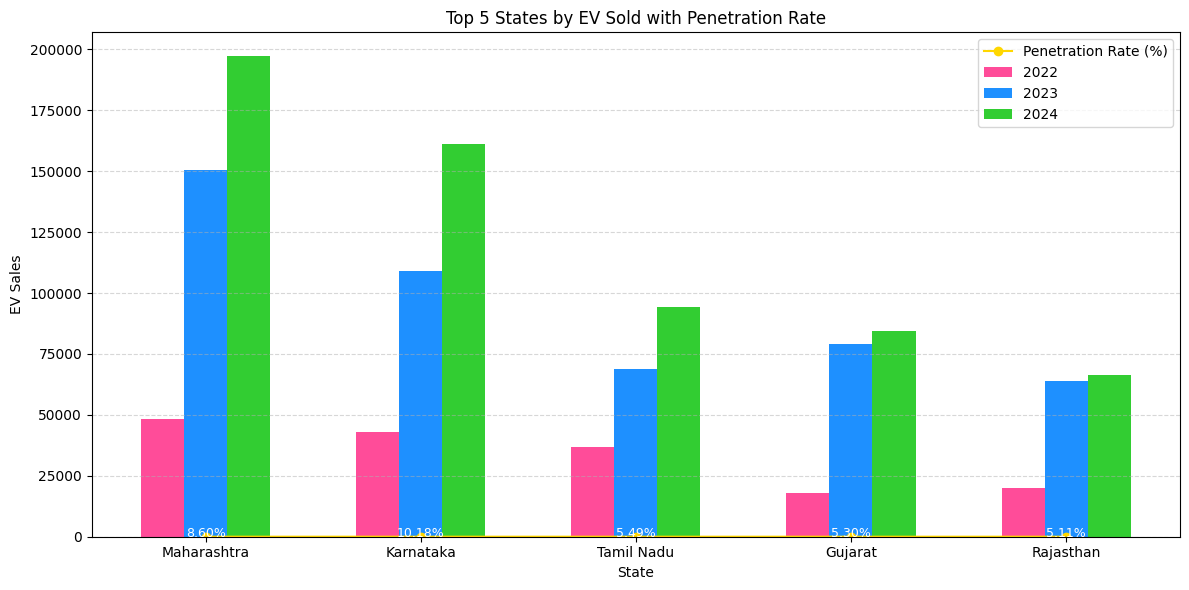

In [39]:
# Group total EV sold per state per year
state_sales = state_df.groupby(['state', 'fiscal_year'])['electric_vehicles_sold'].sum().reset_index()

# Identify top 5 states by total EVs sold across all years
total_sales_by_state = state_sales.groupby('state')['electric_vehicles_sold'].sum().reset_index()
top5_states = total_sales_by_state.sort_values(by='electric_vehicles_sold', ascending=False).head(5)['state'].tolist()

# Filter data for top 5 states
top5_state_data = state_sales[state_sales['state'].isin(top5_states)]

# Penetration rate in 2024
# Use state_df instead of the variable 'df' which might not have 'state' column
penetration_data = state_df[state_df['fiscal_year'] == 2024].groupby('state')[['total_vehicles_sold', 'electric_vehicles_sold']].sum().reset_index()
penetration_data['penetration_rate'] = (penetration_data['electric_vehicles_sold'] / penetration_data['total_vehicles_sold']) * 100
penetration_data = penetration_data[penetration_data['state'].isin(top5_states)]

# Merge penetration rate into main data
plot_df = top5_state_data.merge(penetration_data[['state', 'penetration_rate']], on='state', how='left')

# Plotting
colors = ['#FF4C99', '#1E90FF', '#32CD32']  # 2022, 2023, 2024
plt.figure(figsize=(12, 6))
bar_width = 0.2
states = top5_states
years = [2022, 2023, 2024]
x = range(len(states))

# Bar plot for EV sales in each year
for i, year in enumerate(years):
    yearly_data = plot_df[plot_df['fiscal_year'] == year]
    yearly_data = yearly_data.set_index('state').reindex(states).reset_index()  # Ensure correct order
    plt.bar(
        [p + bar_width * i for p in x],
        yearly_data['electric_vehicles_sold'],
        width=bar_width,
        label=str(year),
        color=colors[i]
    )

# Line plot for Penetration Rate
penetration_values = penetration_data.set_index('state').reindex(states)['penetration_rate'].values
plt.plot(
    [p + bar_width for p in x],
    penetration_values,
    color='gold',
    marker='o',
    label='Penetration Rate (%)'
)

# Annotate penetration values
for i, rate in enumerate(penetration_values):
    plt.text(x[i] + bar_width, rate + 2, f"{rate:.2f}%", ha='center', color='white', fontsize=9)

# Final touches
plt.xticks([p + bar_width for p in x], states)
plt.xlabel("State")
plt.ylabel("EV Sales")
plt.title("Top 5 States by EV Sold with Penetration Rate")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Modeling**
1. **EV Sales Forecasting (2025+)**

  We’ll start with:

  * Goal: Predict future EV sales by state/category

  * Model: Time Series (e.g., ARIMA, Prophet) or Regression (e.g., XGBoost)

  * Features: state, fiscal_year, quarter, vehicle_category

In [40]:
# Filter required columns
df_model = state_df[['fiscal_year', 'vehicle_category', 'electric_vehicles_sold']].copy()

# Convert fiscal year to datetime for Prophet
df_model['ds'] = pd.to_datetime(df_model['fiscal_year'].astype(str) + '-01-01')
df_model.rename(columns={'electric_vehicles_sold': 'y'}, inplace=True)

# Separate for 2W and 4W
df_2w = df_model[df_model['vehicle_category'] == '2-Wheelers'][['ds', 'y']]
df_4w = df_model[df_model['vehicle_category'] == '4-Wheelers'][['ds', 'y']]

# Split into train and test sets
train_2w = df_2w[df_2w['ds'].dt.year < 2024]
test_2w = df_2w[df_2w['ds'].dt.year == 2024]

train_4w = df_4w[df_4w['ds'].dt.year < 2024]
test_4w = df_4w[df_4w['ds'].dt.year == 2024]

(train_2w, test_2w, train_4w, test_4w)

(             ds     y
 0    2022-01-01     0
 2    2022-01-01     0
 4    2022-01-01     0
 6    2022-01-01     0
 8    2022-01-01     0
 ...         ...   ...
 2087 2023-01-01  8388
 2088 2023-01-01    23
 2089 2023-01-01  3559
 2090 2023-01-01   587
 2091 2023-01-01  1103
 
 [816 rows x 2 columns],
              ds   y
 48   2024-01-01   0
 50   2024-01-01   0
 52   2024-01-01   0
 54   2024-01-01   0
 56   2024-01-01   0
 ...         ...  ..
 2440 2024-01-01  58
 2441 2024-01-01  25
 2442 2024-01-01  13
 2443 2024-01-01   2
 2444 2024-01-01   2
 
 [407 rows x 2 columns],
              ds    y
 1    2022-01-01    0
 3    2022-01-01    0
 5    2022-01-01    0
 7    2022-01-01    0
 9    2022-01-01    0
 ...         ...  ...
 1106 2023-01-01  571
 1107 2023-01-01    9
 1108 2023-01-01  431
 1109 2023-01-01   48
 1110 2023-01-01  352
 
 [815 rows x 2 columns],
              ds   y
 49   2024-01-01   0
 51   2024-01-01   0
 53   2024-01-01   0
 55   2024-01-01   0
 57   2024-01-01   0
 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/yd_e6cmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/cz1h9yj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9051', 'data', 'file=/tmp/tmpt42l6w02/yd_e6cmw.json', 'init=/tmp/tmpt42l6w02/cz1h9yj1.json', 'output', 'file=/tmp/tmpt42l6w02/prophet_model0x7utl45/prophet_model-20250606183547.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

--- 2-Wheelers 2025 Forecast ---
Predicted 2025: 1156322


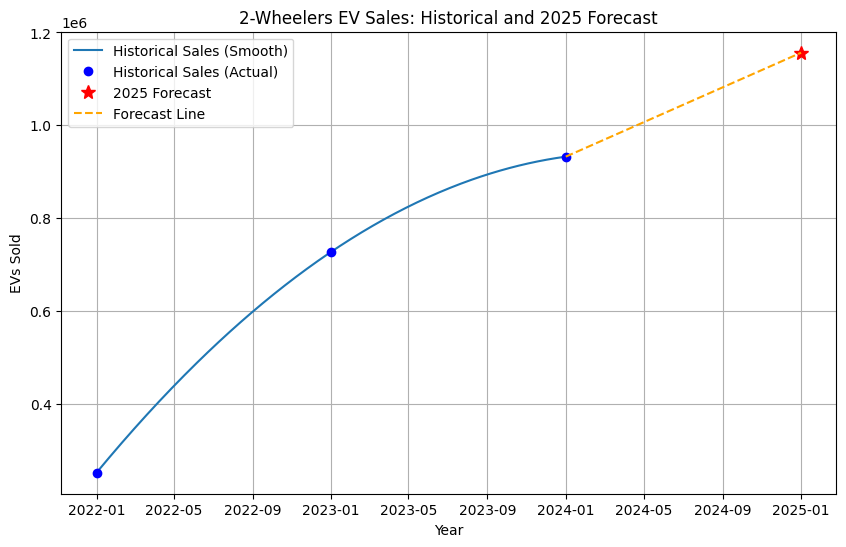

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/k7shgti3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/tal023dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26006', 'data', 'file=/tmp/tmpt42l6w02/k7shgti3.json', 'init=/tmp/tmpt42l6w02/tal023dq.json', 'output', 'file=/tmp/tmpt42l6w02/prophet_model5tjb1xmo/prophet_model-20250606183548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--- 4-Wheelers 2025 Forecast ---
Predicted 2025: 111043


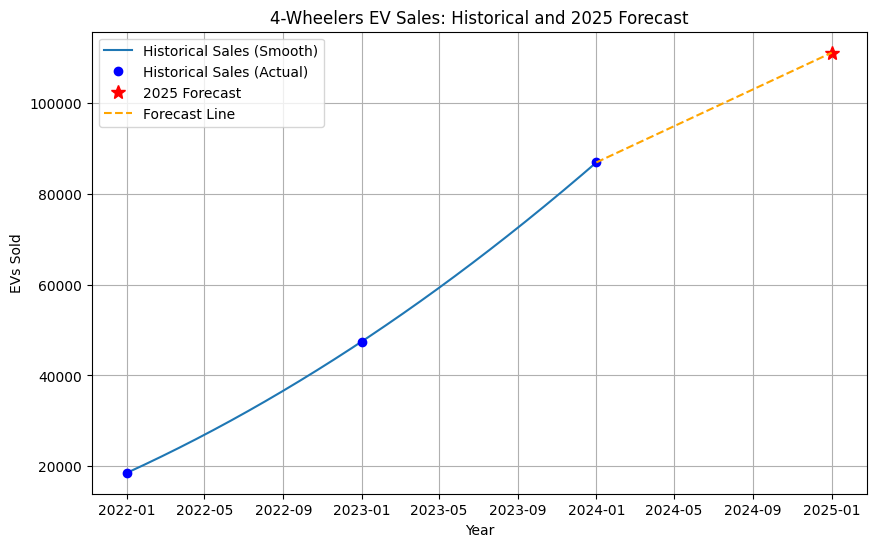

In [41]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

def forecast_prophet_all_data(df, label, years_to_forecast=1):
    if df.shape[0] < 2 or df['y'].isnull().sum() > df.shape[0] - 2:
        print(f"--- {label} ---")
        print(f"Not enough data points ({df.shape[0]} rows) for forecasting.")
        return None

    model = Prophet()
    model.fit(df)

    # Create future dataframe with monthly frequency for the desired number of years
    future = model.make_future_dataframe(periods=years_to_forecast * 12, freq='MS')

    # Filter the future dataframe to include only the years you want to forecast
    future_2025 = future[future['ds'].dt.year.isin([df['ds'].max().year + i + 1 for i in range(years_to_forecast)])]

    if future_2025.empty:
        print(f"--- {label} ---")
        print("Could not generate a future dataframe for the forecast period.")
        return None

    forecast = model.predict(future_2025)

    print(f"--- {label} 2025 Forecast ---")
    # Aggregate the monthly forecasts to get the yearly forecast for 2025
    forecast_2025_yearly = forecast[forecast['ds'].dt.year == 2025]['yhat'].sum()

    if not np.isnan(forecast_2025_yearly):
        print(f"Predicted 2025: {forecast_2025_yearly:.0f}")
    else:
        print("Could not generate a forecast for 2025.")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))

    # Plot historical data with spline interpolation
    if df.shape[0] > 1:
        x = df['ds'].astype(np.int64) // 10**9
        y = df['y']

        xnew = np.linspace(x.min(), x.max(), 300)
        spl = make_interp_spline(x, y, k=min(3, len(x)-1))
        ynew = spl(xnew)

        dates_new = pd.to_datetime(xnew, unit='s')

        plt.plot(dates_new, ynew, linestyle='-', label='Historical Sales (Smooth)')
        plt.plot(df['ds'], df['y'], marker='o', linestyle='', color='blue', label='Historical Sales (Actual)')

    else:
        plt.plot(df['ds'], df['y'], marker='o', linestyle='-', label='Historical Sales')

    # Plot forecast for 2025 (as a single point for yearly aggregate)
    forecast_date_2025 = pd.to_datetime('2025-01-01')
    plt.plot(forecast_date_2025, forecast_2025_yearly, marker='*', markersize=10, linestyle='', color='red', label='2025 Forecast')

    # Connect the last historical point to the forecast point
    if df.shape[0] >= 1 and not np.isnan(forecast_2025_yearly):
        last_historical_date = df['ds'].max()
        last_historical_sales = df['y'].iloc[-1]

        plt.plot(
            [last_historical_date, forecast_date_2025],
            [last_historical_sales, forecast_2025_yearly],
            linestyle='--',
            color='orange',  # You can change the color here
            label='Forecast Line'
        )


    plt.title(f'{label} EV Sales: Historical and 2025 Forecast')
    plt.xlabel('Year')
    plt.ylabel('EVs Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

# Prepare model input using all data
df_model_all = state_df[['fiscal_year', 'vehicle_category', 'electric_vehicles_sold']].copy()
df_model_all['ds'] = pd.to_datetime(df_model_all['fiscal_year'].astype(str) + '-01-01')
df_model_all.rename(columns={'electric_vehicles_sold': 'y'}, inplace=True)

# Aggregate data by year and category
df_model_agg_all = df_model_all.groupby(['ds', 'vehicle_category'])['y'].sum().reset_index()

# Filter data for each category (including all years)
df_2w_all = df_model_agg_all[df_model_agg_all['vehicle_category'] == '2-Wheelers'][['ds', 'y']]
df_4w_all = df_model_agg_all[df_model_agg_all['vehicle_category'] == '4-Wheelers'][['ds', 'y']]

# Run forecasting and plotting
forecast_2w_all = forecast_prophet_all_data(df_2w_all, "2-Wheelers", years_to_forecast=1)
forecast_4w_all = forecast_prophet_all_data(df_4w_all, "4-Wheelers", years_to_forecast=1)

2. **Revenue Forecasting**
* Goal: Estimate future revenue using average prices

* Model: Extend from EV sales forecasting

* Prices: ₹85,000 (2W), ₹15,00,000 (4W)

* Output: Revenue per state/year/category

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/1mnmsxgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt42l6w02/gdw4hark.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96398', 'data', 'file=/tmp/tmpt42l6w02/1mnmsxgv.json', 'init=/tmp/tmpt42l6w02/gdw4hark.json', 'output', 'file=/tmp/tmpt42l6w02/prophet_modelgke8xc58/prophet_model-20250606183548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

--- Total EV 2025 Forecast ---
Predicted 2025: 221,731,666,778


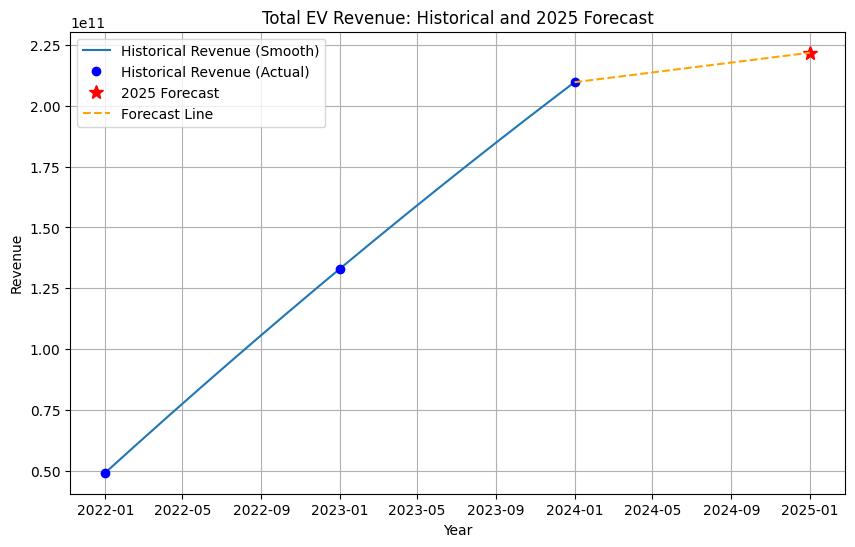

In [42]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

# Define average prices
price_2w = 85000
price_4w = 1500000

# Calculate revenue for each row in state_df
# Ensure 'revenue' column is calculated only once
if 'revenue' not in state_df.columns:
    state_df['revenue'] = state_df.apply(lambda row: row['electric_vehicles_sold'] * (price_2w if row['vehicle_category'] == '2-Wheelers' else price_4w), axis=1)

# Aggregate total revenue by year
revenue_by_year = state_df.groupby('fiscal_year')['revenue'].sum().reset_index()

# Prepare data for Prophet
df_revenue_forecast = revenue_by_year[['fiscal_year', 'revenue']].copy()
df_revenue_forecast['ds'] = pd.to_datetime(df_revenue_forecast['fiscal_year'].astype(str) + '-01-01')
df_revenue_forecast.rename(columns={'revenue': 'y'}, inplace=True)

# --- Prophet Forecasting Function for Revenue ---
def forecast_revenue_prophet(df, label, years_to_forecast=1):
    if df.shape[0] < 2 or df['y'].isnull().sum() > df.shape[0] - 2:
        print(f"--- {label} ---")
        print(f"Not enough data points ({df.shape[0]} rows) for forecasting.")
        return None

    model = Prophet()
    model.fit(df)

    # Create future dataframe with monthly frequency for the desired number of years
    future = model.make_future_dataframe(periods=years_to_forecast * 12, freq='MS')

    # Filter the future dataframe to include only the years you want to forecast
    future_forecast_years = [df['ds'].max().year + i + 1 for i in range(years_to_forecast)]
    future_forecast = future[future['ds'].dt.year.isin(future_forecast_years)]


    if future_forecast.empty:
        print(f"--- {label} ---")
        print("Could not generate a future dataframe for the forecast period.")
        return None

    forecast = model.predict(future_forecast)

    print(f"--- {label} {future_forecast_years[0]} Forecast ---") # Print the first forecast year
    # Aggregate the monthly forecasts to get the yearly forecast
    forecast_yearly = forecast[forecast['ds'].dt.year == future_forecast_years[0]]['yhat'].sum()


    if not np.isnan(forecast_yearly):
        print(f"Predicted {future_forecast_years[0]}: {forecast_yearly:,.0f}") # Format with comma
    else:
        print(f"Could not generate a forecast for {future_forecast_years[0]}.")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))

    # Plot historical data with spline interpolation
    if df.shape[0] > 1:
        x = df['ds'].astype(np.int64) // 10**9
        y = df['y']

        xnew = np.linspace(x.min(), x.max(), 300)
        spl = make_interp_spline(x, y, k=min(3, len(x)-1))
        ynew = spl(xnew)

        dates_new = pd.to_datetime(xnew, unit='s')

        plt.plot(dates_new, ynew, linestyle='-', label='Historical Revenue (Smooth)')
        plt.plot(df['ds'], df['y'], marker='o', linestyle='', color='blue', label='Historical Revenue (Actual)')

    else:
        plt.plot(df['ds'], df['y'], marker='o', linestyle='-', label='Historical Revenue')

    # Plot forecast point
    forecast_date = pd.to_datetime(f'{future_forecast_years[0]}-01-01')
    plt.plot(forecast_date, forecast_yearly, marker='*', markersize=10, linestyle='', color='red', label=f'{future_forecast_years[0]} Forecast')

    # Connect the last historical point to the forecast point
    if df.shape[0] >= 1 and not np.isnan(forecast_yearly):
        last_historical_date = df['ds'].max()
        last_historical_revenue = df['y'].iloc[-1]

        plt.plot(
            [last_historical_date, forecast_date],
            [last_historical_revenue, forecast_yearly],
            linestyle='--',
            color='orange',
            label='Forecast Line'
        )

    plt.title(f'{label} Revenue: Historical and {future_forecast_years[0]} Forecast')
    plt.xlabel('Year')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

# Run revenue forecasting and plotting
forecast_revenue = forecast_revenue_prophet(df_revenue_forecast, "Total EV", years_to_forecast=1)

3. **Penetration Rate Prediction**
* Goal: Estimate future EV penetration as % of total vehicles

* Model: Regression (e.g., Linear, Ridge, RandomForest)

* Features: Total vehicles, historical EV sales, year, state

Predicted EV Penetration Rate for 2025: 6.64%


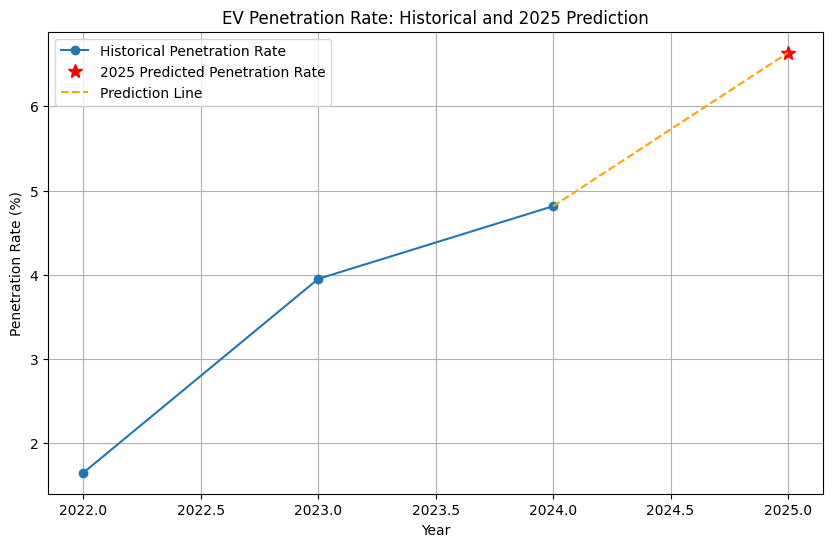

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. Calculate historical penetration rate
# Group by fiscal year and sum electric and total vehicles
yearly_summary = state_df.groupby('fiscal_year')[['electric_vehicles_sold', 'total_vehicles_sold']].sum().reset_index()

# Calculate penetration rate
# Avoid division by zero in case total_vehicles_sold is 0 for any year
yearly_summary['penetration_rate'] = (yearly_summary['electric_vehicles_sold'] / yearly_summary['total_vehicles_sold']) * 100

# Drop rows where total_vehicles_sold is 0 to avoid potential issues if any
yearly_summary = yearly_summary[yearly_summary['total_vehicles_sold'] > 0].copy()


# 2. Prepare data for a regression model
# We'll use 'fiscal_year' as the feature to predict penetration rate over time
X = yearly_summary[['fiscal_year']] # Feature (independent variable)
y = yearly_summary['penetration_rate'] # Target (dependent variable)

# With only 3 data points (2022, 2023, 2024), a train-test split is not meaningful for evaluation.
# We will train the model on all available historical data.

# 3. Choose and train a regression model
model = LinearRegression()
model.fit(X, y)

# 4. Predict future penetration rate
future_years = pd.DataFrame({'fiscal_year': [2025]}) # Predict for the year 2025
predicted_penetration_rate = model.predict(future_years)

# Print the predicted penetration rate
print(f"Predicted EV Penetration Rate for 2025: {predicted_penetration_rate[0]:.2f}%")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot historical penetration rate
plt.plot(yearly_summary['fiscal_year'], yearly_summary['penetration_rate'], marker='o', linestyle='-', label='Historical Penetration Rate')

# Plot predicted penetration rate for 2025
plt.plot(future_years['fiscal_year'], predicted_penetration_rate, marker='*', markersize=10, linestyle='', color='red', label='2025 Predicted Penetration Rate')

# Connect the last historical point to the prediction
last_historical_year = yearly_summary['fiscal_year'].max()
last_historical_penetration = yearly_summary['penetration_rate'].iloc[-1]
plt.plot([last_historical_year, 2025], [last_historical_penetration, predicted_penetration_rate[0]], linestyle='--', color='orange', label='Prediction Line')


plt.title('EV Penetration Rate: Historical and 2025 Prediction')
plt.xlabel('Year')
plt.ylabel('Penetration Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

4. **Classification of States**
* Goal: Classify states as "High", "Medium", or "Low" adoption

* Model: Decision Tree / RandomForest / Logistic Regression

* Target: Penetration Rate category (from clustering or thresholding)

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Calculate Penetration Rate per State
state_summary = state_df.groupby('state')[['electric_vehicles_sold', 'total_vehicles_sold']].sum().reset_index()

# Avoid division by zero
state_summary['penetration_rate'] = (state_summary['electric_vehicles_sold'] / state_summary['total_vehicles_sold']) * 100

# Handle cases where total_vehicles_sold is 0 (penetration rate is undefined) - set to 0 or drop
state_summary['penetration_rate'] = state_summary['penetration_rate'].fillna(0)

# 2. Categorize States
# Define categories based on quartiles of penetration rate
# You can adjust the quantiles or use fixed thresholds based on domain knowledge
low_threshold = state_summary['penetration_rate'].quantile(0.33)
high_threshold = state_summary['penetration_rate'].quantile(0.67)

def categorize_penetration(rate):
    if rate <= low_threshold:
        return 'Low'
    elif rate <= high_threshold:
        return 'Medium'
    else:
        return 'High'

state_summary['penetration_category'] = state_summary['penetration_rate'].apply(categorize_penetration)

# Display the categories
print("State Penetration Categories:")
print(state_summary[['state', 'penetration_rate', 'penetration_category']].sort_values(by='penetration_rate', ascending=False))


# 3. Prepare Data for Classification
# For simplicity, we'll use the penetration rate itself as the feature
# In a real scenario, you might add other state-level features if available
X = state_summary[['penetration_rate']] # Feature
y = state_summary['penetration_category'] # Target

# 4. Choose and Train a Classification Model
# Split data into training and testing sets
# With a limited number of states, this split might not be very representative
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate the Model
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


new_state_penetration = pd.DataFrame({'penetration_rate': [5]})
predicted_category = model.predict(new_state_penetration)
print(f"\nPredicted category for 5% penetration rate: {predicted_category[0]}")

State Penetration Categories:
                       state  penetration_rate penetration_category
10                       Goa          9.843477                 High
16                 Karnataka          7.835984                 High
9                      Delhi          6.755828                 High
17                    Kerala          6.638326                 High
20               Maharashtra          6.491020                 High
25                    Odisha          4.634491                 High
28                 Rajasthan          4.546088                 High
11                   Gujarat          4.396722                 High
30                Tamil Nadu          4.300223                 High
6                 Chandigarh          4.041247                 High
7               Chhattisgarh          4.030295                 High
26                Puducherry          3.671136                 High
2             Andhra Pradesh          3.389946               Medium
33               U

5. **Market Share Prediction**
* Goal: Predict top EV makers’ market share in future

* Model: Regression / Time Series per maker

* Data: electric_vehicle_sales_by_makers.csv

Predicted Market Share for Top Makers in 2025:
           maker  predicted_market_share_2025
0   OLA ELECTRIC                     1.824735
3  HERO ELECTRIC                     1.314854
1            TVS                     1.138270
2          ATHER                     1.025212
4         AMPERE                     0.974520


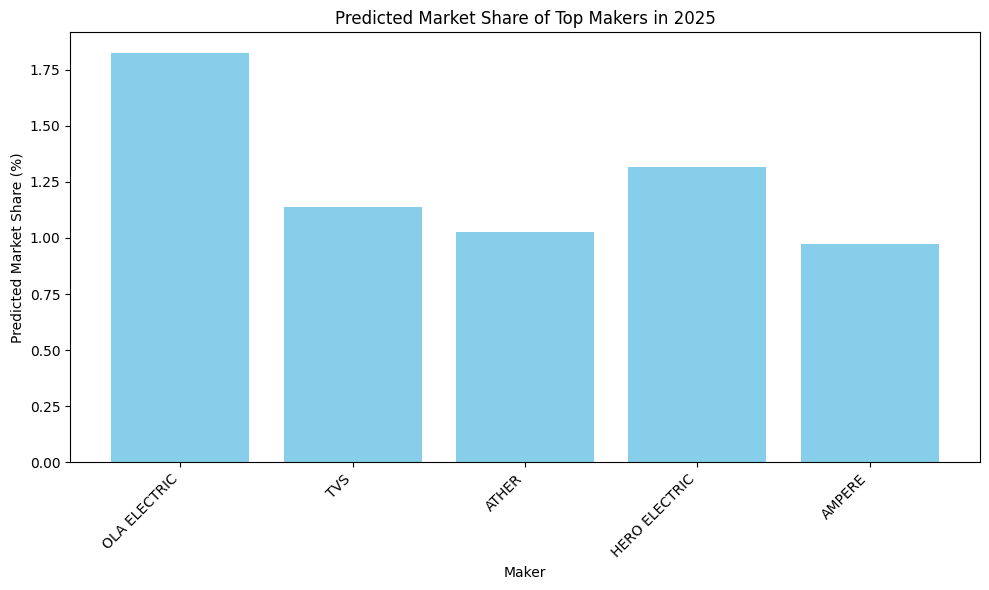

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Calculate Historical Market Share
# (This was already done in the preprocessing steps in this notebook)

# Calculate total market sales per year
yearly_total_sales = makers_df.groupby('fiscal_year')['electric_vehicles_sold'].sum().reset_index()
yearly_total_sales.rename(columns={'electric_vehicles_sold': 'total_market_sales'}, inplace=True)

# Merge total market sales back into makers_df
makers_df_with_total = makers_df.merge(yearly_total_sales, on='fiscal_year', how='left')

# Calculate market share for each maker in each year
# Handle potential division by zero if total_market_sales is 0
makers_df_with_total['market_share'] = (
    makers_df_with_total['electric_vehicles_sold'] / makers_df_with_total['total_market_sales'] * 100
)
makers_df_with_total['market_share'] = makers_df_with_total['market_share'].fillna(0) # Fill NaN with 0

# top_makers = makers_df.groupby('maker')['electric_vehicles_sold'].sum().nlargest(5).index.tolist()

# Filter data for top makers
top_makers_data = makers_df_with_total[makers_df_with_total['maker'].isin(top_makers)].copy()

# 3. Prepare Data for Prediction
# Features (X): fiscal_year, maker
# Target (y): market_share
X = top_makers_data[['fiscal_year', 'maker']]
y = top_makers_data['market_share']

# Handle categorical feature 'maker' using One-Hot Encoding
# Create a column transformer for one-hot encoding 'maker'
preprocessor = ColumnTransformer(
    transformers=[
        ('maker_onehot', OneHotEncoder(handle_unknown='ignore'), ['maker'])
    ],
    remainder='passthrough' # Keep other columns ('fiscal_year')
)

# Create a pipeline with preprocessing and a regression model
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

# We have limited data points per maker (3 years).
# For demonstration, train on all available data for top makers.
# In a real scenario with more data, you would split data.

# 4. Choose and Train a Prediction Model
model_pipeline.fit(X, y)

# 5. Predict Future Market Share
# Create future data for 2025 for each of the top makers
future_data = pd.DataFrame({
    'fiscal_year': [2025] * len(top_makers),
    'maker': top_makers
})

# Predict market share for 2025
predicted_market_share = model_pipeline.predict(future_data)

# Display the predicted market share for 2025
prediction_results = pd.DataFrame({
    'maker': top_makers,
    'predicted_market_share_2025': predicted_market_share
})

print("Predicted Market Share for Top Makers in 2025:")
print(prediction_results.sort_values(by='predicted_market_share_2025', ascending=False))

# --- Optional: Plotting predicted market share ---
# We can't plot a time series trend for future with only one predicted point,
# but we can plot a bar chart of the predicted market share for 2025

plt.figure(figsize=(10, 6))
plt.bar(prediction_results['maker'], prediction_results['predicted_market_share_2025'], color='skyblue')
plt.title('Predicted Market Share of Top Makers in 2025')
plt.xlabel('Maker')
plt.ylabel('Predicted Market Share (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Consumer Behavior**

In [46]:
behavior = pd.read_csv('/content/Indian automoble buying behavour.csv')
behavior.head()

Age Profession Marrital Status      Education  No of Dependents  \
0   27   Salaried          Single  Post Graduate                 0   
1   35   Salaried         Married  Post Graduate                 2   
2   45   Business         Married       Graduate                 4   
3   41   Business         Married  Post Graduate                 3   
4   31   Salaried         Married  Post Graduate                 2   

  Personal loan House Loan Wife Working   Salary  Wife Salary  Total Salary  \
0           Yes         No           No   800000            0        800000   
1           Yes        Yes          Yes  1400000       600000       2000000   
2           Yes        Yes           No  1800000            0       1800000   
3            No         No          Yes  1600000       600000       2200000   
4           Yes         No          Yes  1800000       800000       2600000   

     Make    Price  
0     i20   800000  
1    Ciaz  1000000  
2  Duster  1200000  
3    City  1200000  
4     SUV  1600000

In [47]:
behavior.shape

(99, 13)

In [48]:
behavior.isnull().sum()

Age                 0
Profession          0
Marrital Status     0
Education           0
No of Dependents    0
Personal loan       0
House Loan          0
Wife Working        0
Salary              0
Wife Salary         0
Total Salary        0
Make                0
Price               0
dtype: int64

In [49]:
behavior.describe()

Age  No of Dependents        Salary   Wife Salary  Total Salary  \
count  99.000000         99.000000  9.900000e+01  9.900000e+01  9.900000e+01   
mean   36.313131          2.181818  1.736364e+06  5.343434e+05  2.270707e+06   
std     6.246054          1.335265  6.736217e+05  6.054450e+05  1.050777e+06   
min    26.000000          0.000000  2.000000e+05  0.000000e+00  2.000000e+05   
25%    31.000000          2.000000  1.300000e+06  0.000000e+00  1.550000e+06   
50%    36.000000          2.000000  1.600000e+06  5.000000e+05  2.100000e+06   
75%    41.000000          3.000000  2.200000e+06  9.000000e+05  2.700000e+06   
max    51.000000          4.000000  3.800000e+06  2.100000e+06  5.200000e+06   

              Price  
count  9.900000e+01  
mean   1.194040e+06  
std    4.376955e+05  
min    1.100000e+05  
25%    8.000000e+05  
50%    1.200000e+06  
75%    1.500000e+06  
max    3.000000e+06

In [50]:
behavior.drop_duplicates(inplace=True)
behavior.shape

(99, 13)

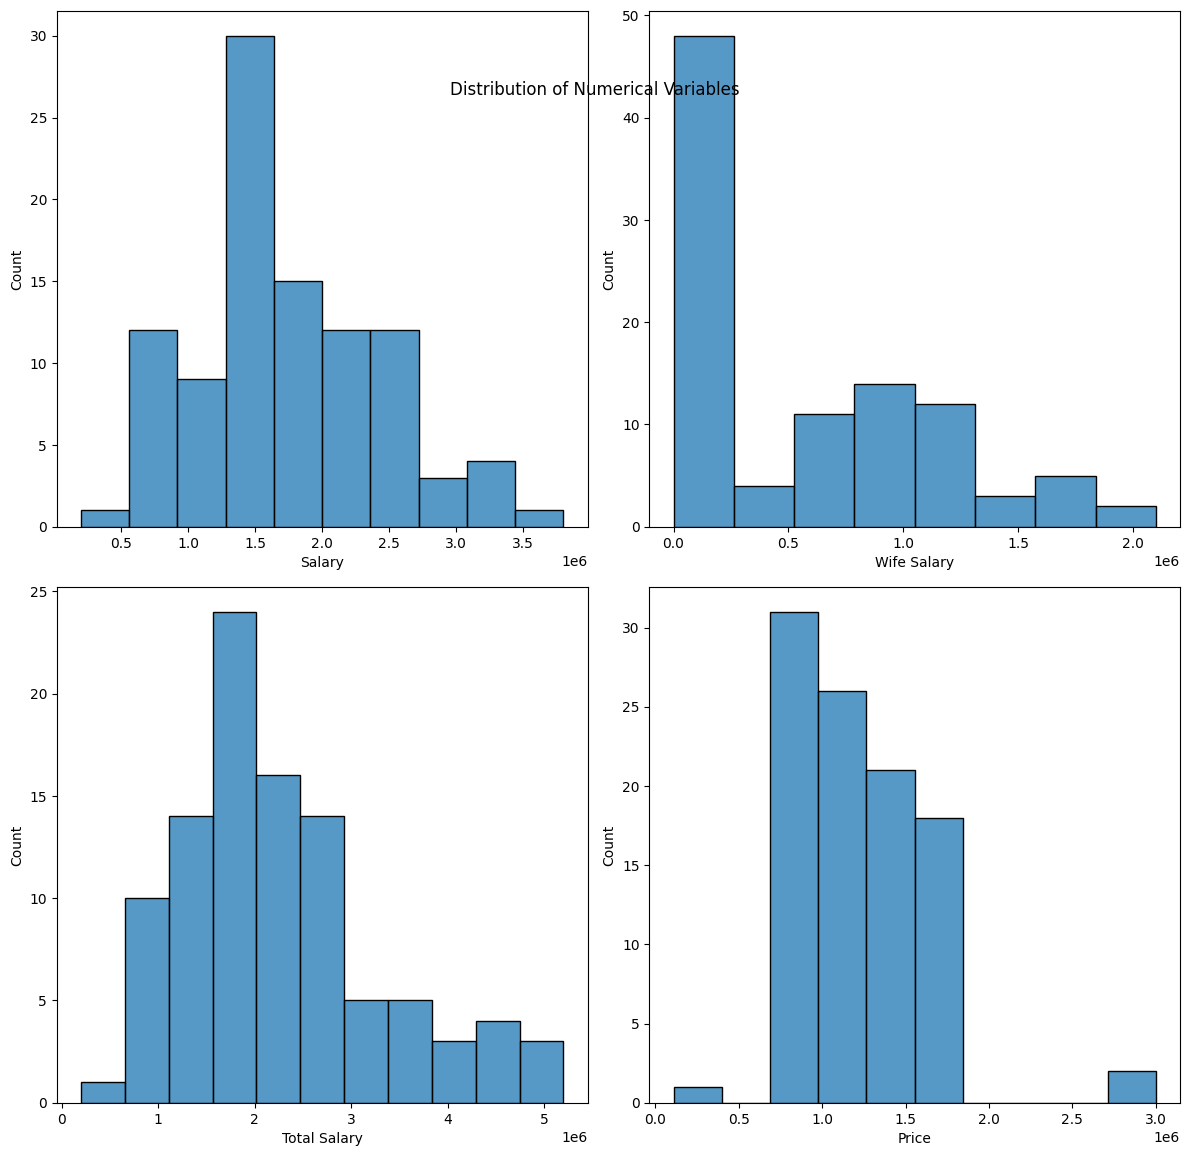

In [51]:
num_cols = ["Salary", "Wife Salary", "Total Salary", "Price"]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    sns.histplot(data=behavior, x=num_cols[i], ax=ax)
plt.suptitle("Distribution of Numerical Variables", y=0.9)
plt.tight_layout()
plt.show()

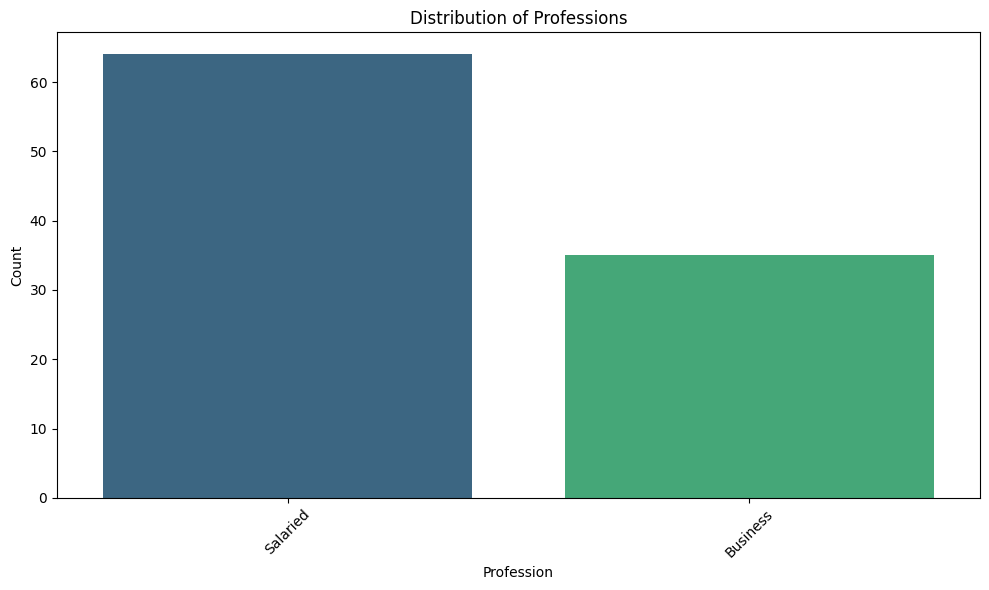

In [52]:
# Plot distribution of profession variable
plt.figure(figsize=(10, 6))
sns.countplot(data=behavior, x='Profession', palette='viridis')
plt.title("Distribution of Professions")
plt.xlabel("Profession")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
# Check who got most number of cars (salaried or business)
salaried_cars = behavior[behavior['Profession'] == 'Salaried'].shape[0]
business_cars = behavior[behavior['Profession'] == 'Business'].shape[0]

print(f"Salaried people bought {salaried_cars} cars.")
print(f"Business people bought {business_cars} cars.")

Salaried people bought 64 cars.
Business people bought 35 cars.


In [54]:
# Who got expensive cars
salaried_expensive = behavior[(behavior['Profession'] == 'Salaried') & (behavior['Price'] > 1000000)].shape[0]
business_expensive = behavior[(behavior['Profession'] == 'Business') & (behavior['Price'] > 1000000)].shape[0]

print(f"Salaried people bought expensive cars: {salaried_expensive}")
print(f"Business people bought expensive cars: {business_expensive}")

Salaried people bought expensive cars: 44
Business people bought expensive cars: 22


In [55]:
# Based on education, who has more cars
salaried_grad = behavior[(behavior['Profession'] == 'Salaried') & (behavior['Education'] == 'Graduate')].shape[0]
business_grad = behavior[(behavior['Profession'] == 'Business') & (behavior['Education'] == 'Graduate')].shape[0]

print(f"Salaried people with Graduate education: {salaried_grad}")
print(f"Business people with Graduate education: {business_grad}")

Salaried people with Graduate education: 24
Business people with Graduate education: 19


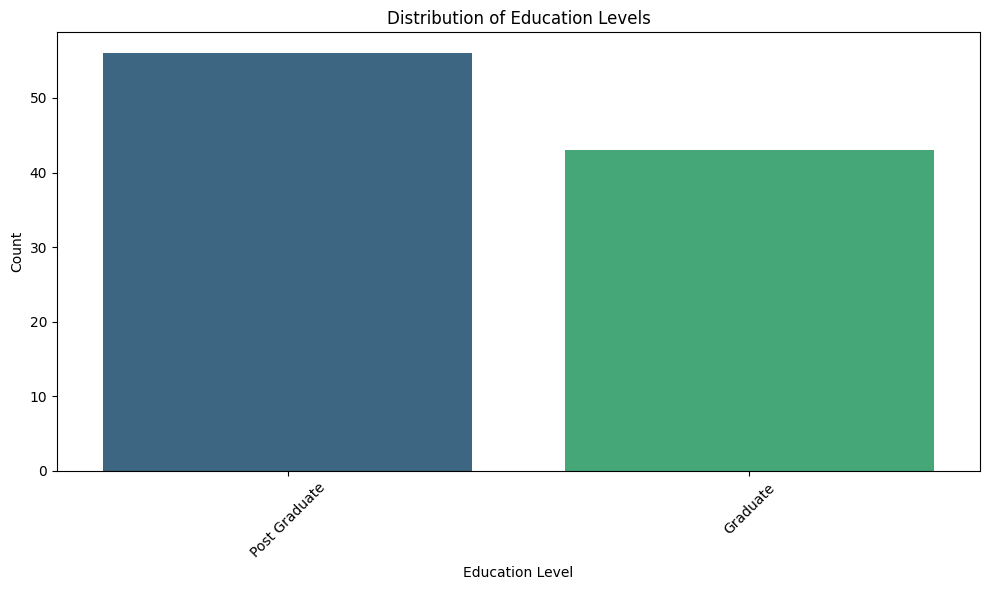

In [56]:
# Distribution of education
plt.figure(figsize=(10, 6))
sns.countplot(data=behavior, x='Education', palette='viridis')
plt.title("Distribution of Education Levels")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
salaried_pg = behavior[(behavior['Profession'] == 'Salaried') & (behavior['Education'] == 'Post Graduate')].shape[0]
business_pg = behavior[(behavior['Profession'] == 'Business') & (behavior['Education'] == 'Post Graduate')].shape[0]

print(f"Salaried people with Post Graduate education: {salaried_pg}")
print(f"Business people with Post Graduate education: {business_pg}")

Salaried people with Post Graduate education: 40
Business people with Post Graduate education: 16


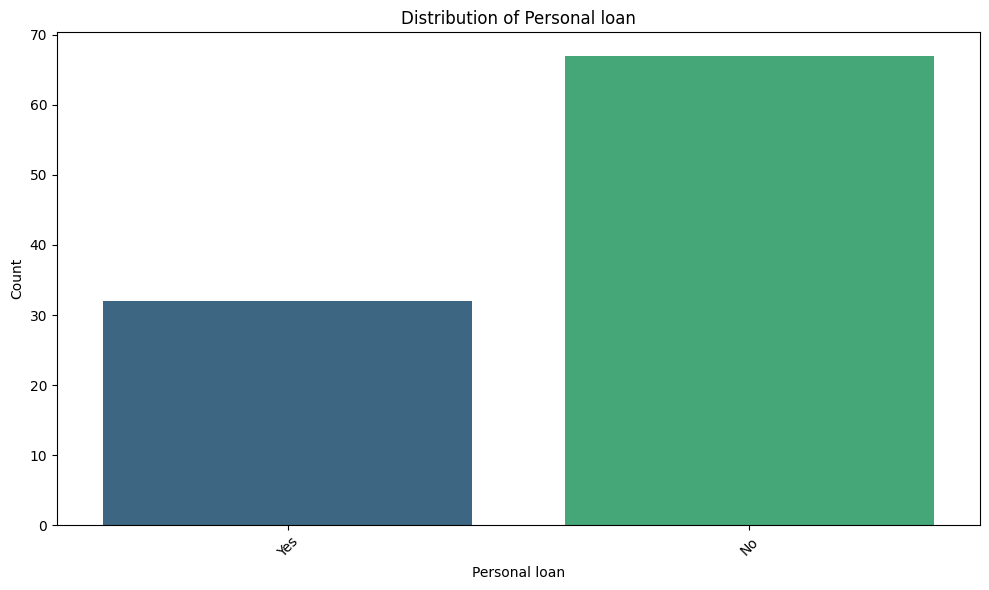

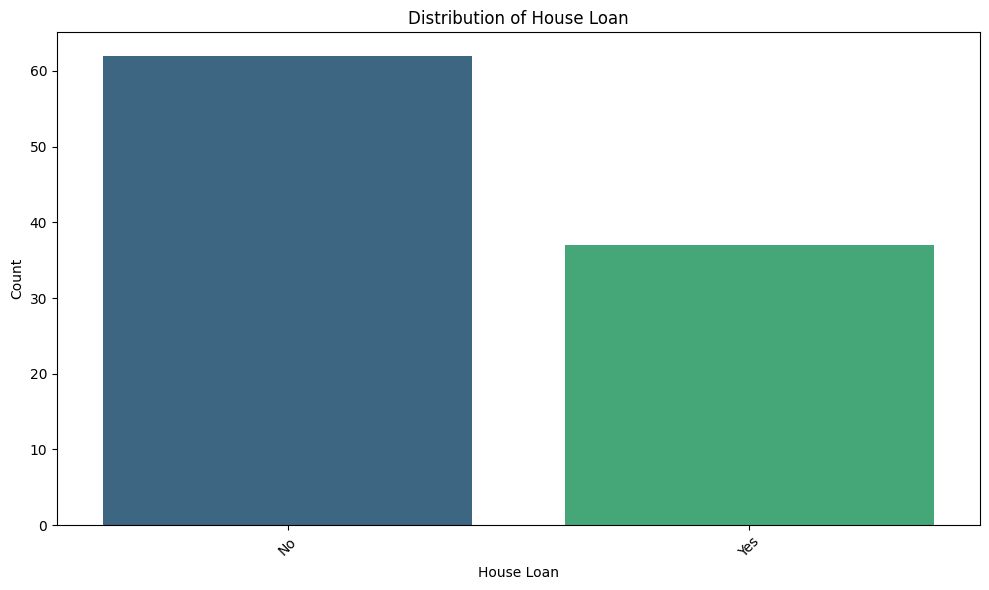

In [58]:
# Distribution of loan variable
loan = ['Personal loan', 'House Loan']
for l in loan:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=behavior, x=l, palette='viridis')
    plt.title(f"Distribution of {l}")
    plt.xlabel(l)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

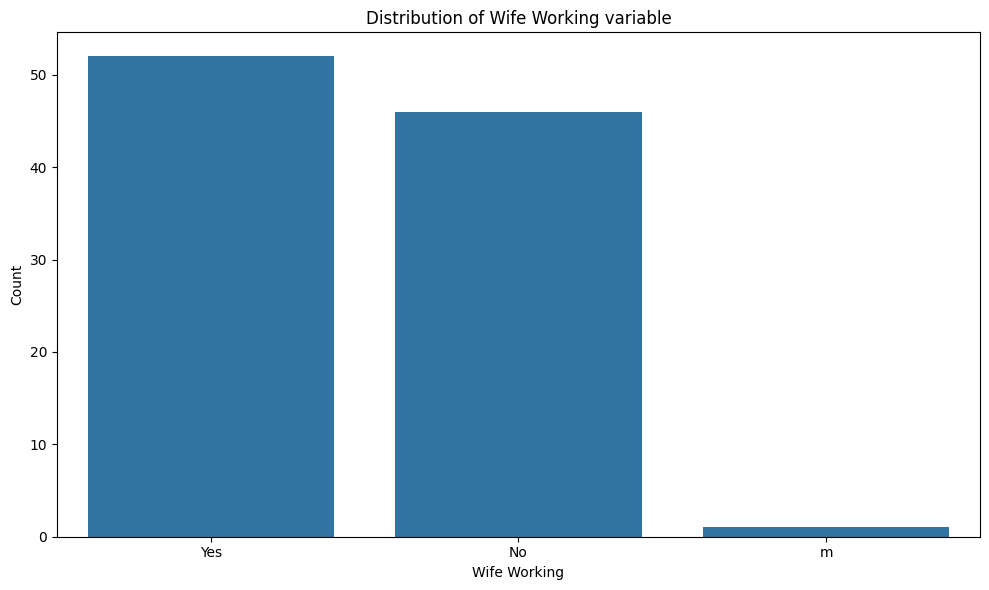

In [59]:
# Distribution of wife working variable

plt.figure(figsize=(10, 6))
sns.barplot(x=behavior["Wife Working"].value_counts().index, y=behavior["Wife Working"].value_counts())

# Add a title and labels to the axes.
plt.title("Distribution of Wife Working variable")
plt.xlabel("Wife Working")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

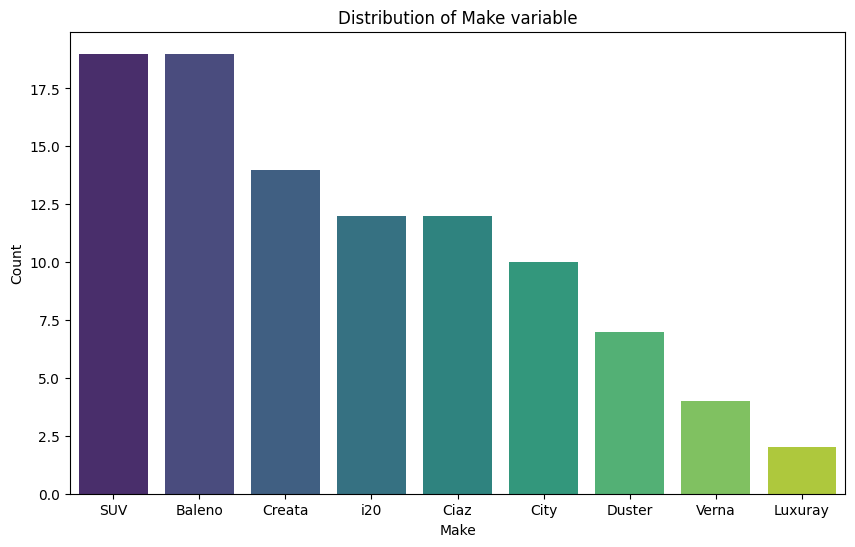

In [60]:
# Distribution of Make variable
plt.figure(figsize=(10, 6))
sns.barplot(x=behavior["Make"].value_counts().index, y=behavior["Make"].value_counts(), palette = 'viridis')

# Add a title and labels to the axes.
plt.title("Distribution of Make variable")
plt.xlabel("Make")
plt.ylabel("Count");

In [61]:
# Check the number of dependents
salaried_dependents = behavior[(behavior['Profession'] == 'Salaried') & (behavior['No of Dependents'] > 0)].shape
business_dependents = behavior[(behavior['Profession'] == 'Business') & (behavior['No of Dependents'] > 0)].shape
print(f"Salaried people with dependents: {salaried_dependents}")
print(f"Business people with dependents: {business_dependents}")

Salaried people with dependents: (50, 13)
Business people with dependents: (27, 13)


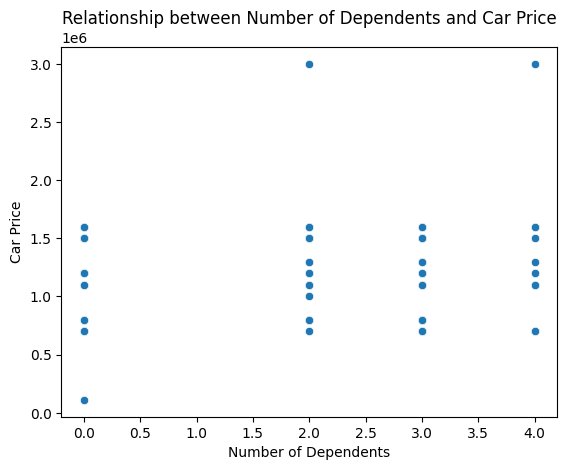

In [62]:
# Is the purchased car price low, if the number of dependens are higher
sns.scatterplot(data=behavior, x='No of Dependents', y='Price')
plt.title("Relationship between Number of Dependents and Car Price")
plt.xlabel("Number of Dependents")
plt.ylabel("Car Price")
plt.show()

In [63]:
from scipy.stats import spearmanr
corr, p_value = spearmanr(behavior['No of Dependents'], behavior['Price'])
print(f"Spearman's correlation coefficient: {corr}")
print(f"p-value: {p_value}")

Spearman's correlation coefficient: 0.0015157504065034795
p-value: 0.9881199429007745


In [64]:
if p_value < 0.05:
    if corr<0:
      print('As the number of dependents increase, car price tends to decrease')
    elif corr>0:
      print('As the number of dependents increase, car price tends to increase')
    else:
      print('No correlation found')
else:
    print('No statistically significant correlation found')

No statistically significant correlation found


Spearmann correlation is suitable for checking monotonic relationshios (not necessarity linear). It is more robust to outliers and skewed distributions (which is common with price vs dependents generally)

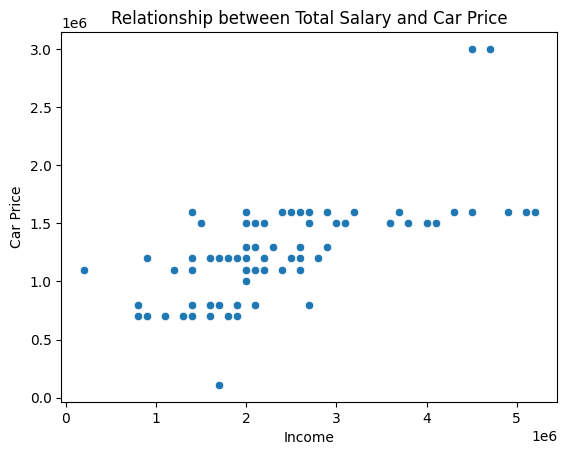

In [65]:
# Check if income is high, the car price is high or not
sns.scatterplot(data=behavior, x='Total Salary', y='Price')
plt.title("Relationship between Total Salary and Car Price")
plt.xlabel("Income")
plt.ylabel("Car Price")
plt.show()

PCA, or Principal Component Analysis, is a dimensionality reduction technique used to simplify complex datasets while retaining their most important information. Here's a breakdown of its uses:

1. **Dimensionality Reduction:** This is the primary use of PCA. It transforms a dataset with many variables into a smaller set of new variables called principal components. These principal components are linear combinations of the original variables and capture most of the variance in the data. This is useful when you have a large number of features and want to reduce the complexity of your model, speed up computation, and potentially reduce noise.

2. **Noise Reduction:** By keeping only the principal components that explain the majority of the variance, you can effectively filter out the noise in the data that is not strongly correlated with the main patterns.

3. **Data Visualization:** When dealing with data that has more than three dimensions, it's difficult to visualize. PCA can reduce the data to two or three principal components, allowing you to create scatter plots and visualize relationships in the data.

4. **Feature Extraction:** PCA can be used as a feature extraction technique. Instead of using the original features, you use the principal components as new features in your machine learning model. These new features are orthogonal (uncorrelated) and can sometimes lead to better model performance.

5. **Multicollinearity Handling:** Multicollinearity occurs when features in your dataset are highly correlated. PCA can help address this by creating uncorrelated principal components.

In summary, PCA is a powerful tool for simplifying and understanding complex datasets by reducing the number of variables while preserving the most important information.

Explained variance ratio by each component:
[7.41362260e-01 1.66782118e-01 9.18556222e-02 1.88187814e-17]

Cumulative explained variance ratio:
[0.74136226 0.90814438 1.         1.        ]


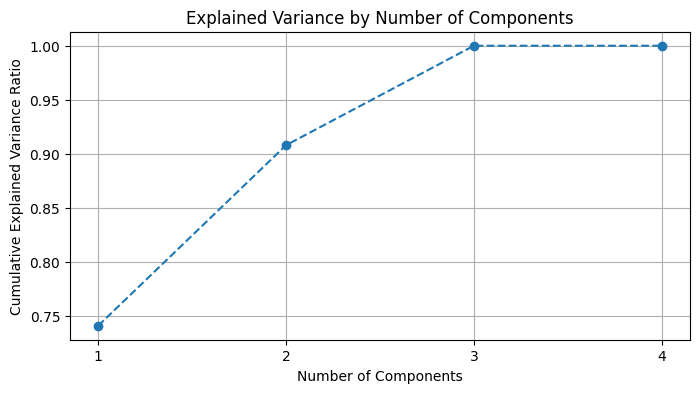

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numerical features for PCA
num_cols_for_pca = ["Salary", "Wife Salary", "Total Salary", "Price"]
behavior_num = behavior[num_cols_for_pca]

# Standardize the data
scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(behavior_num)

# Apply PCA
# We can start by keeping all components to see the explained variance
pca = PCA(n_components=len(num_cols_for_pca))
behavior_pca = pca.fit_transform(behavior_scaled)

# Explained variance ratio
print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

print("\nCumulative explained variance ratio:")
print(pca.explained_variance_ratio_.cumsum())

# You can visualize the explained variance to help decide on the number of components
plt.figure(figsize=(8, 4))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()


Behavior DataFrame with Principal Components:
   Age Profession Marrital Status      Education  No of Dependents  \
0   27   Salaried          Single  Post Graduate                 0   
1   35   Salaried         Married  Post Graduate                 2   
2   45   Business         Married       Graduate                 4   
3   41   Business         Married  Post Graduate                 3   
4   31   Salaried         Married  Post Graduate                 2   

  Personal loan House Loan Wife Working   Salary  Wife Salary  Total Salary  \
0           Yes         No           No   800000            0        800000   
1           Yes        Yes          Yes  1400000       600000       2000000   
2           Yes        Yes           No  1800000            0       1800000   
3            No         No          Yes  1600000       600000       2200000   
4           Yes         No          Yes  1800000       800000       2600000   

     Make    Price       PC1       PC2  
0     i20   8000

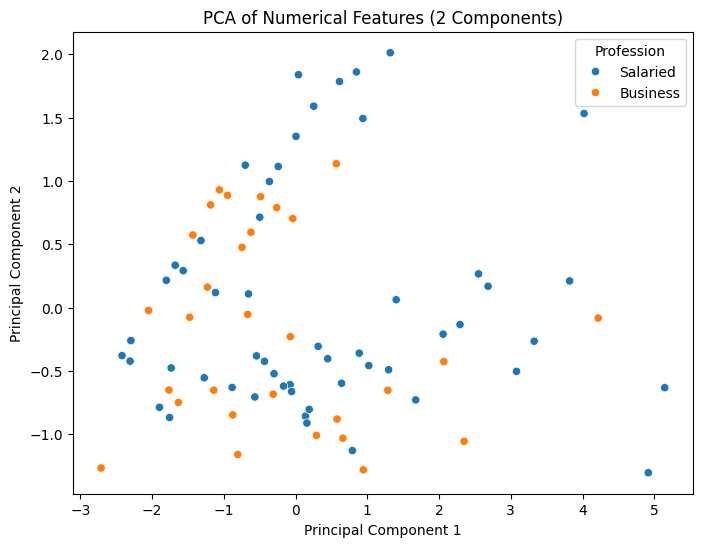

In [67]:
pca = PCA(n_components=2)
behavior_pca_2d = pca.fit_transform(behavior_scaled)

# Now behavior_pca (or behavior_pca_2d) contains the transformed data
# You can add these principal components back to your original dataframe or use them for further analysis
# For example, adding the first two principal components:
behavior['PC1'] = behavior_pca_2d[:, 0]
behavior['PC2'] = behavior_pca_2d[:, 1]

print("\nBehavior DataFrame with Principal Components:")
print(behavior.head())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=behavior['PC1'], y=behavior['PC2'], hue=behavior['Profession']) # Example with Profession as hue
plt.title('PCA of Numerical Features (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

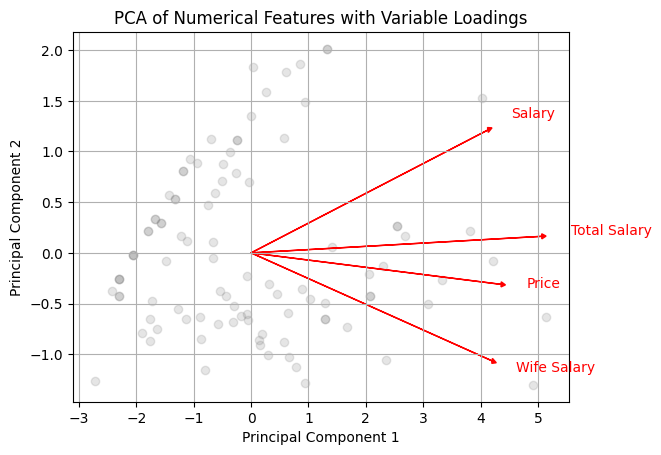

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np # Import numpy for array operations
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Select numerical features for PCA
num_cols_for_pca = ["Salary", "Wife Salary", "Total Salary", "Price"]
behavior_num = behavior[num_cols_for_pca]

# Standardize the data using the previously fitted scaler
# Make sure you use the same scaler that was fitted on the training data
scaler = StandardScaler() # Re-initialize or ensure the scaler from previous cell is used
behavior_scaled = scaler.fit_transform(behavior_num) # Fit and transform the numerical data

# Apply PCA using the previously fitted PCA model
# Make sure you use the same pca object that was fitted on the scaled data
pca = PCA(n_components=2) # Re-initialize or ensure the pca from previous cell is used (using n_components=2 as in cell 70)
behavior_pca_2d = pca.fit_transform(behavior_scaled) # Fit and transform the scaled data

# Now behavior_pca (or behavior_pca_2d) contains the transformed data
# Use the transformed data for the loadings plot
pca_proj = behavior_pca_2d # Use the 2D PCA results for the scatter plot

# Calculate loadings using the components from the fitted PCA model
# The loadings should correspond to the scaled numerical features used for fitting PCA
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c='grey', alpha=0.2)

# Plot loadings for the numerical features that were used for PCA
# Use the column names from num_cols_for_pca to label the arrows
for i, col_name in enumerate(num_cols_for_pca):
    plt.arrow(0, 0, loadings[i, 0]*np.max(np.abs(pca_proj[:, 0])), loadings[i, 1]*np.max(np.abs(pca_proj[:, 1])), color='red', head_width=0.05)
    plt.text(loadings[i, 0]*np.max(np.abs(pca_proj[:, 0])) * 1.1, loadings[i, 1]*np.max(np.abs(pca_proj[:, 1])) * 1.1, col_name, color='red')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Numerical Features with Variable Loadings')
plt.grid(True)
plt.show()

In [69]:
# 1. Financial Ratios/Metrics:

# Create Dependency Ratio
# Avoid division by zero if Total Salary is 0
behavior['Dependency_Ratio'] = behavior.apply(
    lambda row: row['No of Dependents'] / row['Total Salary'] if row['Total Salary'] > 0 else 0,
    axis=1
)

# Create Wife Contribution to Salary
behavior['Wife_Contribution_Ratio'] = behavior.apply(
    lambda row: row['Wife Salary'] / row['Total Salary'] if row['Total Salary'] > 0 else 0,
    axis=1
)

# Create Total Loan Count
# Assuming 'Personal loan' and 'House Loan' are already 0 or 1 (integer/numeric type)
# Check data types first to be safe
if pd.api.types.is_numeric_dtype(behavior['Personal loan']) and pd.api.types.is_numeric_dtype(behavior['House Loan']):
    behavior['Total_Loan_Count'] = behavior['Personal loan'] + behavior['House Loan']
else:
    print("Warning: 'Personal loan' or 'House Loan' not numeric. Cannot create 'Total_Loan_Count'.")
    # You might need to convert them first, e.g., behavior['Personal loan'] = behavior['Personal loan'].astype(int)


# 2. Interactions between Profession and Financials:
# Requires One-Hot Encoding 'Profession' first for direct interaction terms in a model,
# but we can create indicator *products* here.

# Check if 'Profession' column exists before proceeding
if 'Profession' in behavior.columns:
    # Create binary indicators for professions
    behavior['Is_Salaried'] = (behavior['Profession'] == 'Salaried').astype(int)
    behavior['Is_Business'] = (behavior['Profession'] == 'Business').astype(int) # Assuming only two categories

    # Create interaction terms (product of indicator and total salary)
    behavior['Salaried_Income'] = behavior['Is_Salaried'] * behavior['Total Salary']
    behavior['Business_Income'] = behavior['Is_Business'] * behavior['Total Salary']

    # Clean up temporary indicators if needed (optional)
    # behavior = behavior.drop(columns=['Is_Salaried', 'Is_Business'])
else:
     print("Warning: 'Profession' column not found. Cannot create profession interaction features.")


# 3. Age Grouping:

# Check if Age column exists before proceeding
if 'Age' in behavior.columns:
    # Define bins and labels
    age_bins = [0, 25, 35, 45, 55, np.inf] # Example bins - adjust as needed
    age_labels = ['<25', '25-34', '35-44', '45-54', '55+']
    behavior['Age_Group'] = pd.cut(behavior['Age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True) # right=False makes bins [0, 25), [25, 35) etc.
else:
    print("Warning: 'Age' column not found. Cannot create 'Age_Group'.")


# 4. Education Level Encoding (Ordinal):

# Check if Education column exists before proceeding
if 'Education' in behavior.columns:
    # Define a mapping for ordinal encoding
    education_mapping = {
        '10th Pass': 1,
        '12th Pass': 2,
        'Graduate': 3,
        'Post Graduate': 4,
        'Other': 0 # Assign a value for 'Other' or handle differently
    }
    # Apply mapping - use .get(x, default_value) to handle missing or 'Other' values safely
    behavior['Education_Ordinal'] = behavior['Education'].apply(lambda x: education_mapping.get(x, 0)) # Default to 0 for 'Other'/missing
else:
    print("Warning: 'Education' column not found. Cannot create 'Education_Ordinal'.")


# 5. Encoding of Categorical Features:
# This is typically done just before modeling.
# We will list the potential columns to encode.
categorical_cols_to_encode = [
    'Profession',
    'Marrital Status',
    'Education',
    'Make',
    'Model',
    'Buy',          # Likely already 0/1
    'Personal loan', # Likely already 0/1
    'House Loan',    # Likely already 0/1
    'Wife working',  # Likely already 0/1
    'Age_Group'      # The new categorical feature
]

print("\nPotential categorical columns for One-Hot Encoding before modeling:", [col for col in categorical_cols_to_encode if col in behavior.columns])


# 6. Indicators based on Thresholds:

# Create High Income Flag (example threshold - using median or a fixed value)
if 'Total Salary' in behavior.columns:
    income_threshold = behavior['Total Salary'].median() # Example: using the median
    # Alternatively, use a fixed value: income_threshold = 1000000
    behavior['High_Income_Flag'] = (behavior['Total Salary'] > income_threshold).astype(int)
else:
    print("Warning: 'Total Salary' column not found. Cannot create 'High_Income_Flag'.")


# Create Has Loan Flag
# Assuming 'Personal loan' and 'House Loan' are 0 or 1
if 'Total_Loan_Count' in behavior.columns:
    behavior['Has_Loan_Flag'] = (behavior['Total_Loan_Count'] > 0).astype(int)
else:
     print("Warning: 'Total_Loan_Count' column not found. Cannot create 'Has_Loan_Flag'.")


# 7. Combining Make and Model:
# Create a combined string identifier if needed
if 'Make' in behavior.columns and 'Model' in behavior.columns:
    behavior['Make_Model'] = behavior['Make'] + '_' + behavior['Model']
else:
    print("Warning: 'Make' or 'Model' column not found. Cannot create 'Make_Model'.")


# --- Display the first few rows with the new features ---
# List all original and newly created feature columns to display
all_cols_to_display = [
    'Age', 'Profession', 'Marrital Status', 'Education', 'No of Dependents',
    'Salary', 'Wife Salary', 'Total Salary', 'Make', 'Model', 'Price', 'Buy',
    'Personal loan', 'House Loan', 'Wife working', # Original
    'Dependency_Ratio', 'Wife_Contribution_Ratio', 'Total_Loan_Count', # Financial Ratios
    'Is_Salaried', 'Is_Business', 'Salaried_Income', 'Business_Income', # Profession Interactions
    'Age_Group', 'Education_Ordinal', # Grouping/Encoding
    'High_Income_Flag', 'Has_Loan_Flag', # Indicator Flags
    'Make_Model', # Combined Identifier
    'PC1', 'PC2', 'penetration_category' # Previous PCA/Categorization results (if they were added to 'behavior')
]

# Filter for columns actually present in the DataFrame
cols_to_show_present = [col for col in all_cols_to_display if col in behavior.columns]

print("\nDataFrame after feature engineering (showing some new columns):")
print(behavior[cols_to_show_present].head())

# Optional: Display info to see new columns and their types
print("\nDataFrame Info after feature engineering:")
behavior.info()


Potential categorical columns for One-Hot Encoding before modeling: ['Profession', 'Marrital Status', 'Education', 'Make', 'Personal loan', 'House Loan', 'Age_Group']

DataFrame after feature engineering (showing some new columns):
   Age Profession Marrital Status      Education  No of Dependents   Salary  \
0   27   Salaried          Single  Post Graduate                 0   800000   
1   35   Salaried         Married  Post Graduate                 2  1400000   
2   45   Business         Married       Graduate                 4  1800000   
3   41   Business         Married  Post Graduate                 3  1600000   
4   31   Salaried         Married  Post Graduate                 2  1800000   

   Wife Salary  Total Salary    Make    Price  ... Wife_Contribution_Ratio  \
0            0        800000     i20   800000  ...                0.000000   
1       600000       2000000    Ciaz  1000000  ...                0.300000   
2            0       1800000  Duster  1200000  ...        

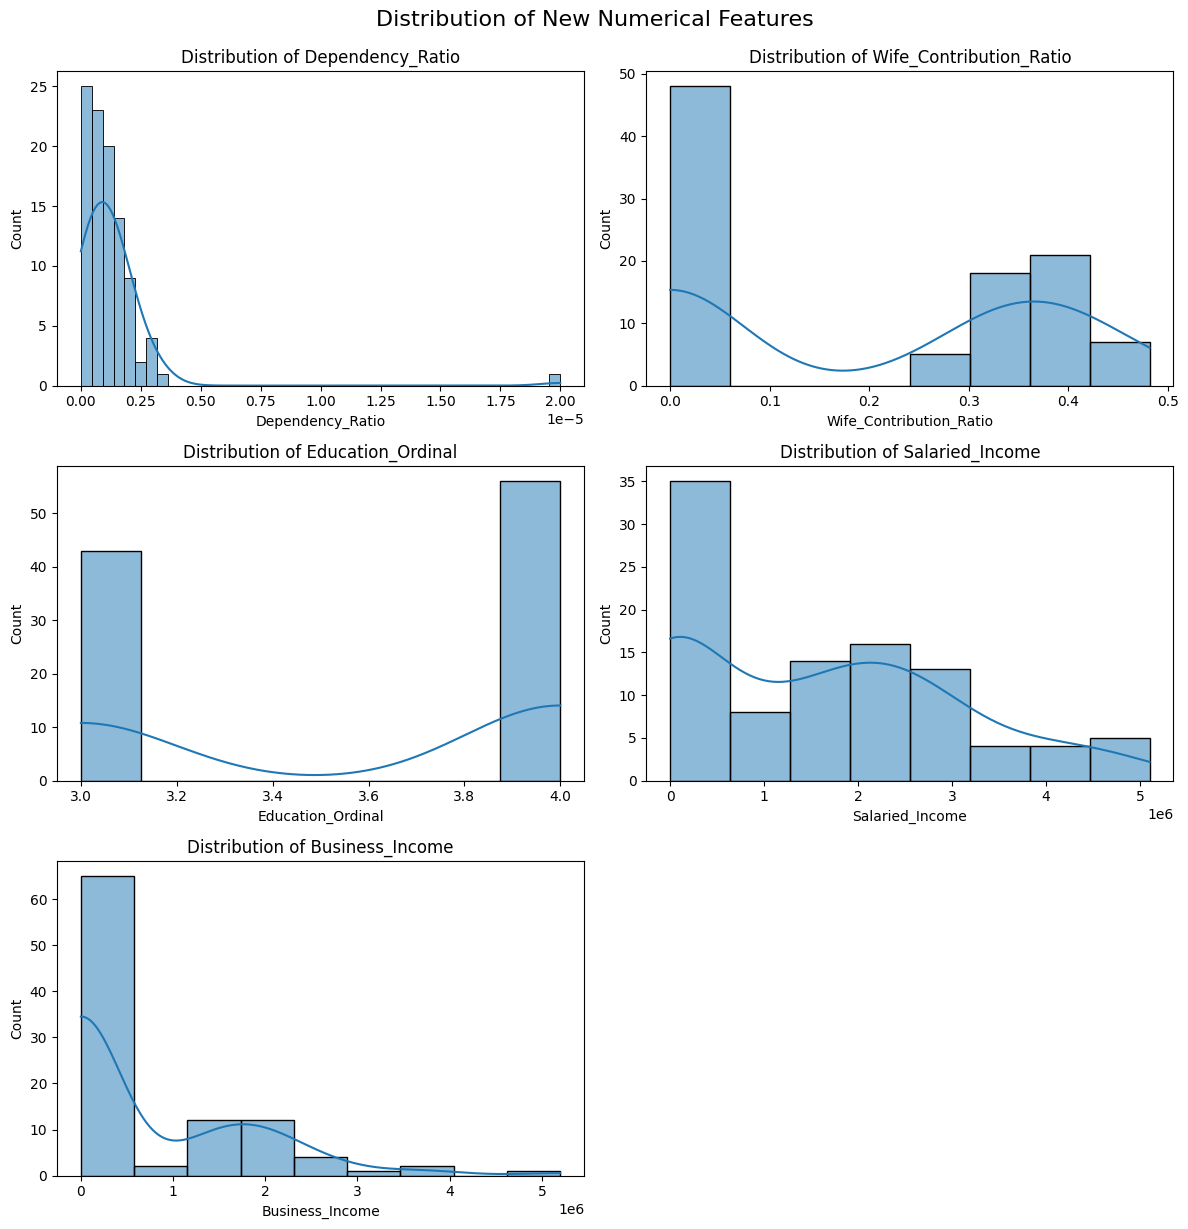

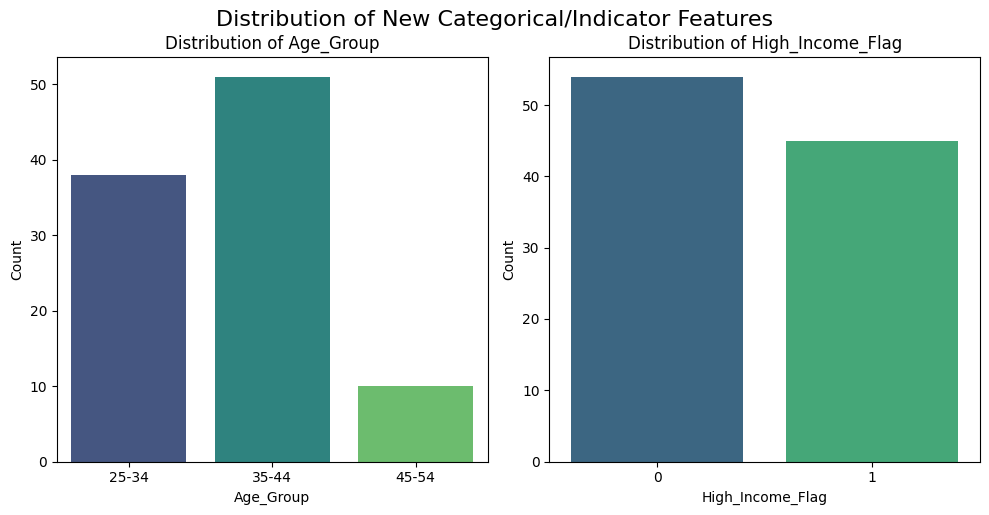

In [70]:
# Plot distributions of new numerical features
new_numerical_cols = ['Dependency_Ratio', 'Wife_Contribution_Ratio', 'Total_Loan_Count', 'Education_Ordinal', 'Salaried_Income', 'Business_Income']
# Filter for columns that actually exist in the dataframe
new_numerical_cols_present = [col for col in new_numerical_cols if col in behavior.columns]

if new_numerical_cols_present:
    fig, axes = plt.subplots(nrows=(len(new_numerical_cols_present) + 1) // 2, ncols=2, figsize=(12, 4 * ((len(new_numerical_cols_present) + 1) // 2)))
    axes = axes.flatten() # Flatten in case of odd number of plots

    for i, col in enumerate(new_numerical_cols_present):
        sns.histplot(data=behavior, x=col, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Distribution of New Numerical Features", y=1.02, fontsize=16)
    plt.show()
else:
    print("No new numerical features found to plot distributions.")


# Plot distributions of new categorical/indicator features
new_categorical_cols = ['Age_Group', 'High_Income_Flag', 'Has_Loan_Flag']
# Filter for columns that actually exist in the dataframe
new_categorical_cols_present = [col for col in new_categorical_cols if col in behavior.columns]

if new_categorical_cols_present:
    fig, axes = plt.subplots(nrows=1, ncols=len(new_categorical_cols_present), figsize=(5 * len(new_categorical_cols_present), 5))
    # Ensure axes is an array even for a single plot
    if len(new_categorical_cols_present) == 1:
        axes = [axes]

    for i, col in enumerate(new_categorical_cols_present):
         # Use order to sort categories if applicable (e.g., Age_Group)
        order = sorted(behavior[col].unique().dropna()) if col == 'Age_Group' else None
        sns.countplot(data=behavior, x=col, ax=axes[i], palette='viridis', order=order)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        if col != 'Age_Group': # Rotate ticks only if not Age_Group (assuming few categories)
             axes[i].tick_params(axis='x', rotation=0)


    plt.tight_layout()
    plt.suptitle("Distribution of New Categorical/Indicator Features", y=1.02, fontsize=16)
    plt.show()
else:
     print("No new categorical/indicator features found to plot distributions.")

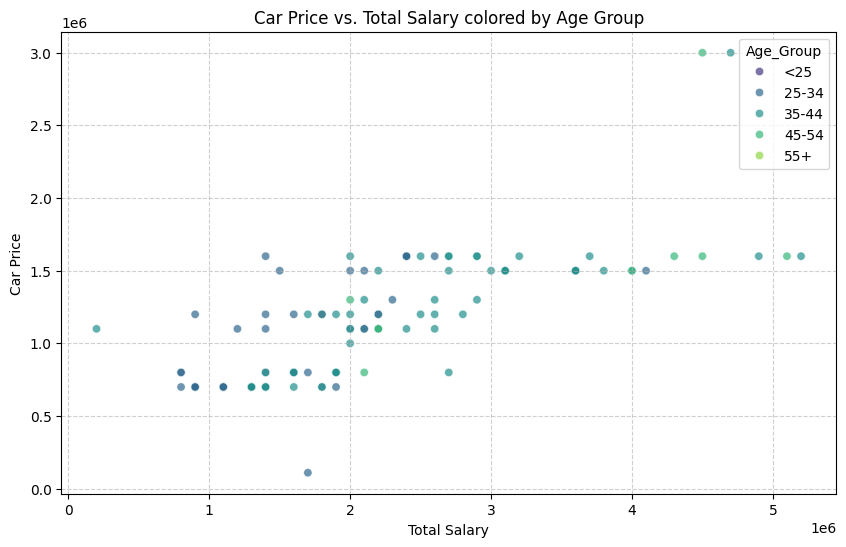

Required columns for Price by Has_Loan_Flag box plot not found.


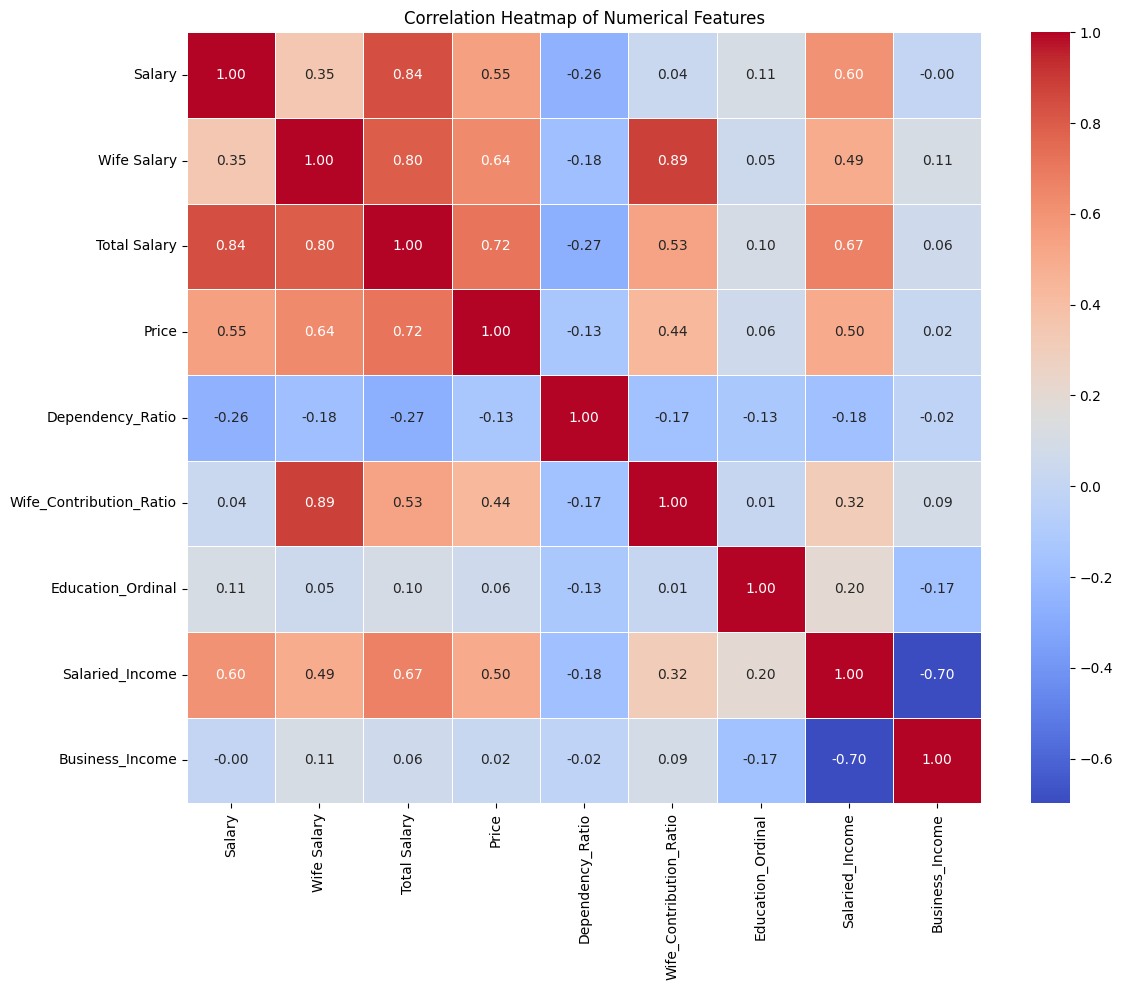

In [71]:
# Scatter plot: Total Salary vs Price, colored by Age_Group
if 'Total Salary' in behavior.columns and 'Price' in behavior.columns and 'Age_Group' in behavior.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=behavior, x='Total Salary', y='Price', hue='Age_Group', palette='viridis', alpha=0.7)
    plt.title('Car Price vs. Total Salary colored by Age Group')
    plt.xlabel('Total Salary')
    plt.ylabel('Car Price')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
     print("Required columns for Total Salary vs Price by Age_Group scatter plot not found.")

# Box plot: Price by Has_Loan_Flag
if 'Price' in behavior.columns and 'Has_Loan_Flag' in behavior.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=behavior, x='Has_Loan_Flag', y='Price', palette='pastel')
    plt.title('Car Price Distribution by Loan Status')
    plt.xlabel('Has Loan (0: No, 1: Yes)')
    plt.ylabel('Car Price')
    plt.xticks([0, 1], ['No Loan', 'Has Loan'])
    plt.show()
else:
    print("Required columns for Price by Has_Loan_Flag box plot not found.")


# Correlation Heatmap of numerical features (including new ones)
# Select relevant numerical columns (original and new)
numerical_cols_for_corr = num_cols_for_pca + ['Dependency_Ratio', 'Wife_Contribution_Ratio', 'Total_Loan_Count', 'Education_Ordinal', 'Salaried_Income', 'Business_Income']
# Filter for columns that actually exist in the dataframe
numerical_cols_present_for_corr = [col for col in numerical_cols_for_corr if col in behavior.columns]

if len(numerical_cols_present_for_corr) > 1:
    corr_matrix = behavior[numerical_cols_present_for_corr].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical columns to plot a correlation heatmap.")

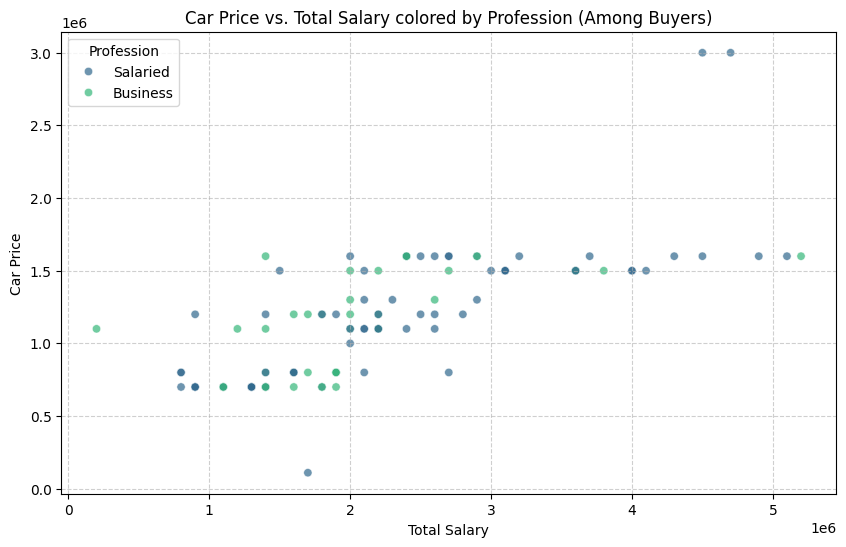

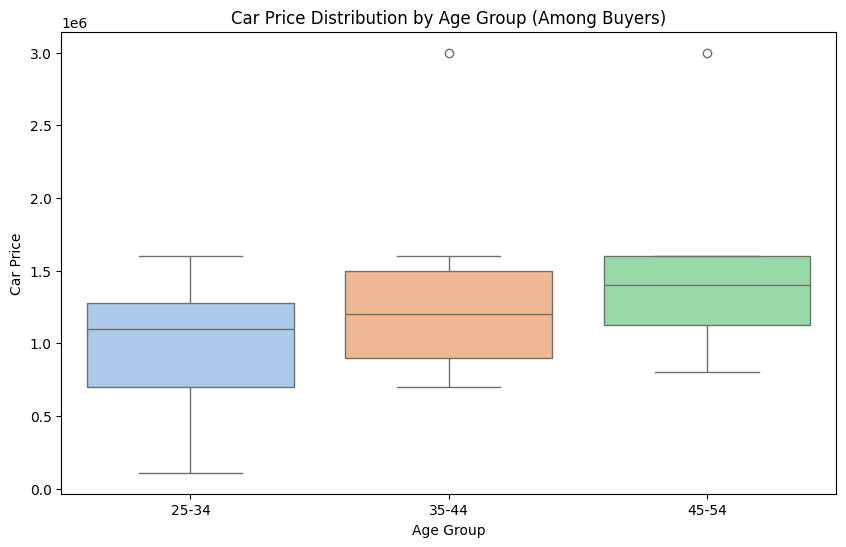

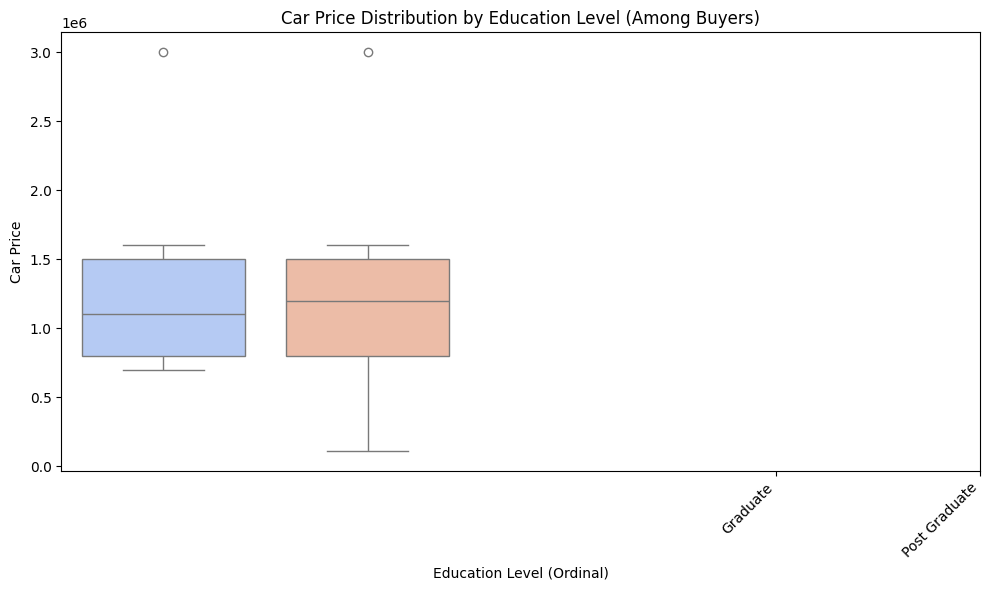

In [72]:
# Scatter Plot: Total Salary vs Price, colored by Profession
if 'Total Salary' in behavior.columns and 'Price' in behavior.columns and 'Profession' in behavior.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=behavior, x='Total Salary', y='Price', hue='Profession', palette='viridis', alpha=0.7)
    plt.title('Car Price vs. Total Salary colored by Profession (Among Buyers)')
    plt.xlabel('Total Salary')
    plt.ylabel('Car Price')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
     print("Required columns for Total Salary vs Price by Profession scatter plot not found.")


# Box plot: Price by Age_Group
if 'Price' in behavior.columns and 'Age_Group' in behavior.columns:
    plt.figure(figsize=(10, 6))
    # Ensure Age_Group order is correct
    age_group_order = ['<25', '25-34', '35-44', '45-54', '55+'] # Based on your bins
    sns.boxplot(data=behavior, x='Age_Group', y='Price', palette='pastel', order=[g for g in age_group_order if g in behavior['Age_Group'].unique()])
    plt.title('Car Price Distribution by Age Group (Among Buyers)')
    plt.xlabel('Age Group')
    plt.ylabel('Car Price')
    plt.show()
else:
     print("Required columns for Price by Age_Group box plot not found.")


# Box plot: Price by Education_Ordinal
if 'Price' in behavior.columns and 'Education_Ordinal' in behavior.columns and 'Education' in behavior.columns:
    # Get unique original education levels and sort them by their ordinal value for plotting order
    education_order_map = behavior[['Education', 'Education_Ordinal']].drop_duplicates().sort_values('Education_Ordinal')
    education_plot_order = education_order_map['Education_Ordinal'].tolist()
    education_tick_labels = education_order_map['Education'].tolist()


    plt.figure(figsize=(10, 6))
    sns.boxplot(data=behavior, x='Education_Ordinal', y='Price', palette='coolwarm', order=education_plot_order)
    plt.title('Car Price Distribution by Education Level (Among Buyers)')
    plt.xlabel('Education Level (Ordinal)')
    plt.ylabel('Car Price')
    plt.xticks(education_plot_order, education_tick_labels, rotation=45, ha='right') # Set custom ticks and labels
    plt.tight_layout()
    plt.show()
else:
     print("Required columns for Price by Education_Ordinal box plot not found.")

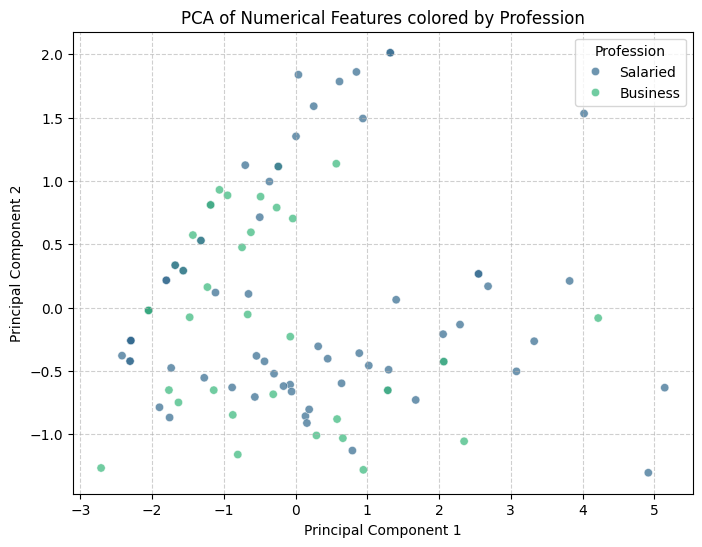

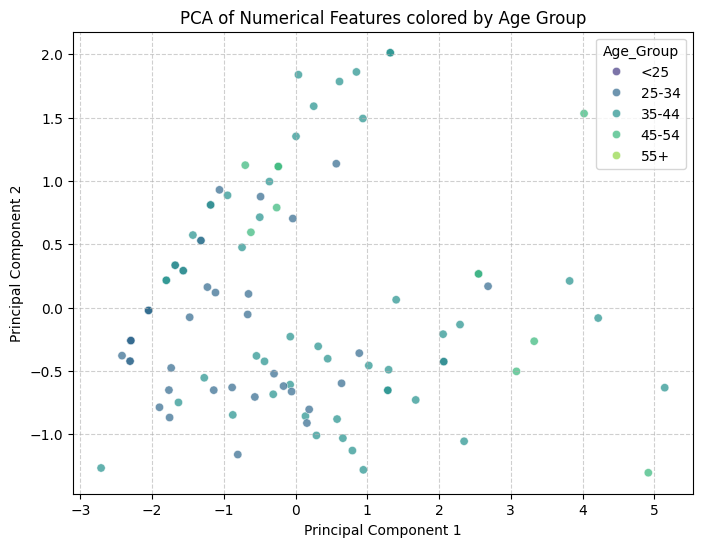

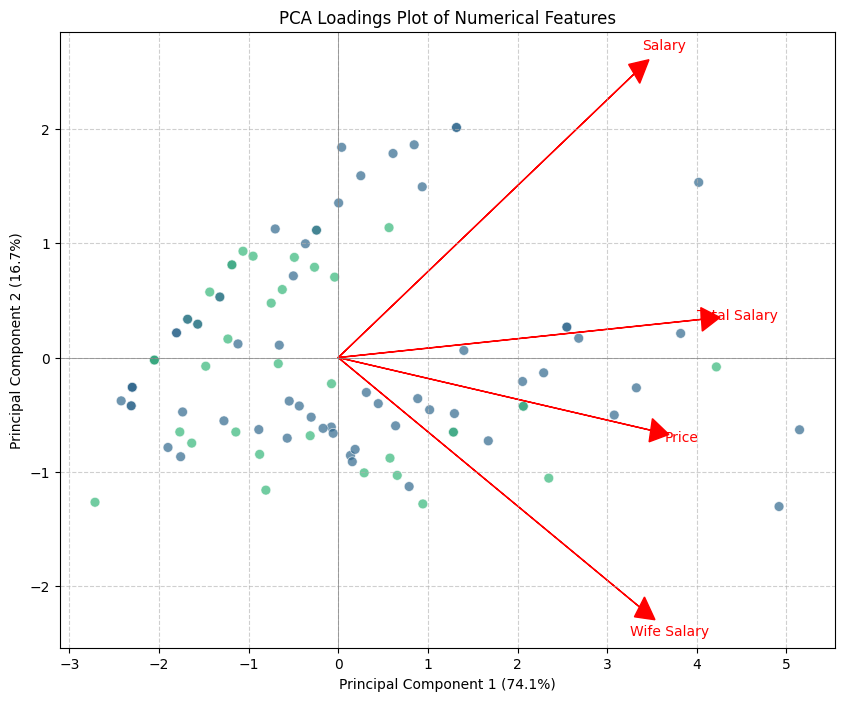

In [73]:
if 'PC1' in behavior.columns and 'PC2' in behavior.columns:
    if 'Profession' in behavior.columns:
         plt.figure(figsize=(8, 6))
         sns.scatterplot(x='PC1', y='PC2', hue='Profession', data=behavior, palette='viridis', alpha=0.7)
         plt.title('PCA of Numerical Features colored by Profession')
         plt.xlabel('Principal Component 1')
         plt.ylabel('Principal Component 2')
         plt.grid(True, linestyle='--', alpha=0.6)
         plt.show()
    else:
         print("Warning: 'Profession' column not found for PCA plot hue.")

    if 'Age_Group' in behavior.columns:
         plt.figure(figsize=(8, 6))
         sns.scatterplot(x='PC1', y='PC2', hue='Age_Group', data=behavior, palette='viridis', alpha=0.7)
         plt.title('PCA of Numerical Features colored by Age Group')
         plt.xlabel('Principal Component 1')
         plt.ylabel('Principal Component 2')
         plt.grid(True, linestyle='--', alpha=0.6)
         plt.show()
    else:
         print("Warning: 'Age_Group' column not found for PCA plot hue.")
else:
    print("Warning: 'PC1' or 'PC2' columns not found in behavior DataFrame. Run PCA first.")


# Check if pca object is fitted and has components
if 'pca' in globals() and hasattr(pca, 'components_') and pca.n_components_ >= 2 and 'behavior_scaled' in globals():
    # Recalculate loadings based on the pca object and the scaled data used for fitting
    # Ensure the scale of arrows is appropriate for the plot
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Get the range of the PCA projected data to scale the arrows appropriately
    # Use the scaled data that was used for PCA, then transform to get the projection range
    behavior_pca_proj_range = pca.transform(behavior_scaled)
    max_pc1_range = np.max(np.abs(behavior_pca_proj_range[:, 0]))
    max_pc2_range = np.max(np.abs(behavior_pca_proj_range[:, 1]))

    plt.figure(figsize=(10, 8))
    # Scatter plot of the PCA projected data (colored by profession again, or other category)
    if 'Profession' in behavior.columns:
         sns.scatterplot(x=behavior_pca_proj_range[:, 0], y=behavior_pca_proj_range[:, 1], hue=behavior['Profession'], palette='viridis', alpha=0.7, s=50, legend=False) # legend=False to avoid duplicate legend

    # Plot loadings for the numerical features that were used for PCA
    # Scale arrow lengths by the range of the PC axes
    arrow_scalar = max(max_pc1_range, max_pc2_range) * 0.8 # Adjust scalar as needed for visual clarity

    for i, col_name in enumerate(num_cols_for_pca):
        plt.arrow(0, 0, loadings[i, 0]*arrow_scalar, loadings[i, 1]*arrow_scalar, color='red', head_width=arrow_scalar*0.05, head_length=arrow_scalar*0.05)
        plt.text(loadings[i, 0]*arrow_scalar*1.1, loadings[i, 1]*arrow_scalar*1.1, col_name, color='red', fontsize=10, ha='center', va='center')

    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.title('PCA Loadings Plot of Numerical Features')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.show()

else:
    print("Warning: PCA object not fitted or required variables not available for loadings plot.")

### **Modeling**
**Segmenting Consumers based on Behavior and Attributes (Clustering):** If you want to group consumers with similar buying behaviors or attributes, clustering models are suitable.

* K-Means Clustering: A popular algorithm for partitioning data into a predefined number of clusters.
* DBSCAN: Can find clusters of varying shapes and handle noise.

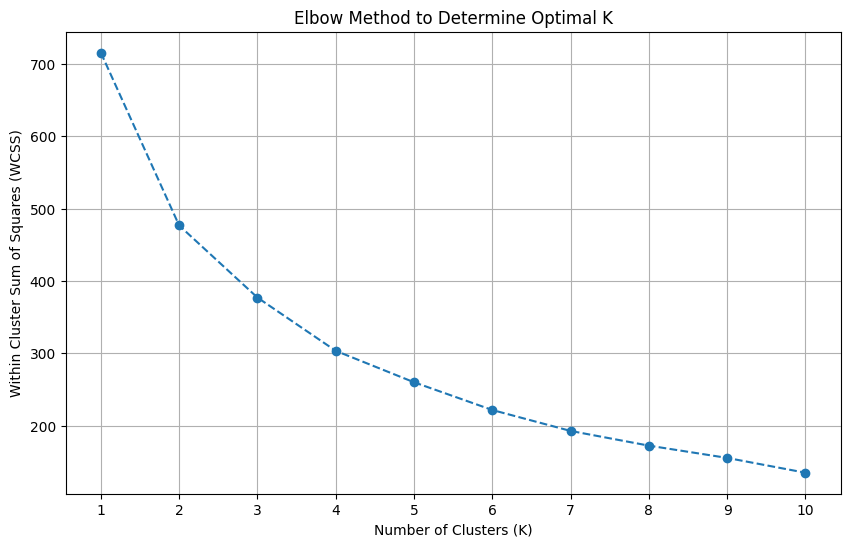

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

features_for_clustering = [
    'Age',
    'Total Salary', # Use total salary instead of individual salaries
    'Price',
    'No of Dependents',
    'Dependency_Ratio',         # New feature
    'Wife_Contribution_Ratio',  # New feature
    'Total_Loan_Count',         # New feature
    'Education_Ordinal',        # New feature (ordinal representation)
    # Include binary indicators if relevant and not covered by other features/interactions
    'High_Income_Flag',         # New feature
    'Has_Loan_Flag',            # New feature
    # 'Salaried_Income',        # Consider adding interaction terms if they improve clustering
    # 'Business_Income'
]

# Filter for columns that actually exist in the dataframe
features_for_clustering_present = [col for col in features_for_clustering if col in behavior.columns]

behavior_clustering_data = behavior[features_for_clustering_present]

# Standardize the Features
scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(behavior_clustering_data)

# Apply PCA
n_components_for_pca = min(behavior_scaled.shape[1], 5) # Use up to 5 components, or less if fewer features

pca = PCA(n_components=n_components_for_pca)
behavior_pca_reduced = pca.fit_transform(behavior_scaled)

# --- Step 1: Determine the optimal number of clusters (K) using the Elbow Method ---
wcss = []
# Test K from 1 to 10 (you can adjust this range)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10) # Added n_init
    kmeans.fit(behavior_pca_reduced)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

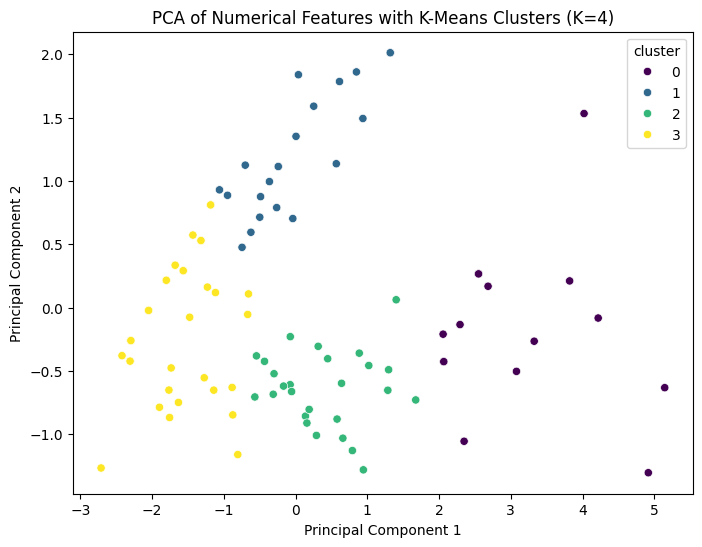


Silhouette Score for K=4: 0.47


In [75]:
# Based on the elbow plot, choose an appropriate value for K.
optimal_k = 4

# --- Step 2: Apply K-Means clustering with the chosen K ---
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10) # Added n_init
# Fit KMeans to the PCA-transformed data
behavior['cluster'] = kmeans.fit_predict(behavior_pca_2d)

# --- Step 3: Visualize the clusters on the PCA plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=behavior['PC1'], y=behavior['PC2'], hue=behavior['cluster'], palette='viridis', legend='full')
plt.title(f'PCA of Numerical Features with K-Means Clusters (K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optional: Evaluate the clustering using Silhouette Score
# The silhouette score measures how similar an object is to its own cluster
# compared to other clusters. Higher scores indicate better defined clusters.
if optimal_k > 1: # Silhouette score is not defined for K=1
    silhouette_avg = silhouette_score(behavior_pca_2d, behavior['cluster'])
    print(f"\nSilhouette Score for K={optimal_k}: {silhouette_avg:.2f}")

In [76]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# # 1. Select Relevant Features (Numerical for K-Means)
# numerical_features = ['Salary', 'Wife Salary', 'Total Salary', 'Price']
# X = behavior[numerical_features].copy()

# # 2. Handle Categorical Features (Not needed for this example as we use only numerical)

# # 3. Standardize the Data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 4. Determine the Optimal Number of Clusters (using the Elbow Method)
# # The elbow method looks at the sum of squared distances (inertia) for different k values.
# # The "elbow" point, where the rate of decrease sharply changes, is often considered a good k.

# inertia = []
# # Try a range of k values, for example, from 1 to 10
# k_range = range(1, 11)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init to suppress warning
#     kmeans.fit(X_scaled)
#     inertia.append(kmeans.inertia_)

# # Plot the elbow method graph
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, inertia, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia (Sum of Squared Distances)')
# plt.xticks(k_range)
# plt.grid(True)
# plt.show()

In [77]:
# optimal_k = 3

# # 5. Apply K-Means Clustering with the chosen k
# kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # n_init to suppress warning
# behavior['cluster'] = kmeans_model.fit_predict(X_scaled)

# # Get the centroids from the fitted model (scaled)
# scaled_centroids = kmeans_model.cluster_centers_

# # Inverse transform the centroids back to the original scale
# original_scale_centroids = scaler.inverse_transform(scaled_centroids)

# # 6. Analyze the Clusters
# # Look at the characteristics of each cluster
# print("\nCluster Analysis (Mean values in original scale):")
# cluster_means = behavior.groupby('cluster')[numerical_features].mean()
# print(cluster_means)

# print("\nProfession Distribution per Cluster:")
# print(behavior.groupby('cluster')['Profession'].value_counts(normalize=True).unstack().fillna(0))

# print("\nEducation Distribution per Cluster:")
# print(behavior.groupby('cluster')['Education'].value_counts(normalize=True).unstack().fillna(0))

# # 7. Visualize the clusters with centroids and circles
# plt.figure(figsize=(10, 6))

# # Scatter plot of the data points colored by cluster
# sns.scatterplot(data=behavior, x='Total Salary', y='Price', hue='cluster', palette='viridis', alpha=0.6)

# # Plot the centroids in the original scale
# plt.scatter(
#     original_scale_centroids[:, numerical_features.index('Total Salary')], # X-coordinate (Total Salary)
#     original_scale_centroids[:, numerical_features.index('Price')],       # Y-coordinate (Price)
#     c='red',       # Color of the centroids
#     s=200,         # Size of the centroid markers
#     marker='X',    # Marker style (an 'X')
#     label='Centroids',
#     edgecolor='black' # Add an edge for better visibility
# )

# # Add labels for centroids (optional)
# for i, (x, y) in enumerate(zip(original_scale_centroids[:, numerical_features.index('Total Salary')], original_scale_centroids[:, numerical_features.index('Price')])):
#     plt.text(x, y, f'C{i}', fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')

# # To circle the clusters, you can use ellipses, but it's not a direct feature of basic scatter plots.
# # A simple way to visualize separation is by adding a transparent circle around each centroid.
# # This is more illustrative of the centroid location than the actual cluster boundary.
# from matplotlib.patches import Ellipse
# from matplotlib.collections import PatchCollection

# # Create ellipses around centroids (simple visual aid, not a strict cluster boundary)
# ellipses = []
# for i in range(optimal_k):
#     # You might need to adjust the width and height of the ellipses based on cluster spread
#     # This is a simplified representation. A more accurate representation might involve
#     # covariance matrices if you were using a model like Gaussian Mixture Models.
#     ellipse = Ellipse(
#         (original_scale_centroids[i, numerical_features.index('Total Salary')], original_scale_centroids[i, numerical_features.index('Price')]),
#         width=100000,  # Example width, adjust based on data spread
#         height=100000, # Example height, adjust based on data spread
#         angle=0,
#         alpha=0.2      # Transparency of the ellipse
#     )
#     ellipses.append(ellipse)

# # Add the ellipses to the plot
# p = PatchCollection(ellipses, cmap='viridis', alpha=0.2)
# # Assign a color to each ellipse based on the cluster index
# p.set_array(np.arange(optimal_k))
# plt.gca().add_collection(p)


# plt.title(f'K-Means Clusters (k={optimal_k}) with Centroids')
# plt.xlabel('Total Salary')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

# **Battery Data**

In [78]:
battery_df = pd.read_csv('/content/ev_battery_charging_data.csv')
battery_df.head()

SOC (%)  Voltage (V)  Current (A)  Battery Temp (°C)  Ambient Temp (°C)  \
0  43.708611     3.629593    33.553512          33.454060          26.439918   
1  95.564288     3.879331    32.228092          35.933628          31.108647   
2  75.879455     4.111062    91.562912          25.009358          30.203219   
3  63.879264     4.012557    32.459158          32.497482          18.077998   
4  24.041678     4.064593    34.475475          31.434920          17.984989   

   Charging Duration (min)  Degradation Rate (%) Charging Mode  \
0                59.363552              8.805096          Fast   
1                67.343566             12.186860          Fast   
2               105.454739             13.832336          Slow   
3                54.000439              9.318874          Fast   
4               106.964968             11.687577          Fast   

   Efficiency (%) Battery Type  Charging Cycles EV Model  \
0       98.238981       Li-ion              112  Model B   
1       97.562628      LiFePO4              398  Model A   
2       97.233533      LiFePO4              175  Model A   
3       98.136225      LiFePO4              150  Model B   
4       97.662485       Li-ion              886  Model C   

   Optimal Charging Duration Class  
0                                1  
1                                1  
2                                2  
3                                1  
4                                2

In [79]:
battery_df.isnull().sum()

SOC (%)                            0
Voltage (V)                        0
Current (A)                        0
Battery Temp (°C)                  0
Ambient Temp (°C)                  0
Charging Duration (min)            0
Degradation Rate (%)               0
Charging Mode                      0
Efficiency (%)                     0
Battery Type                       0
Charging Cycles                    0
EV Model                           0
Optimal Charging Duration Class    0
dtype: int64

In [80]:
battery_df.drop_duplicates(inplace = True)

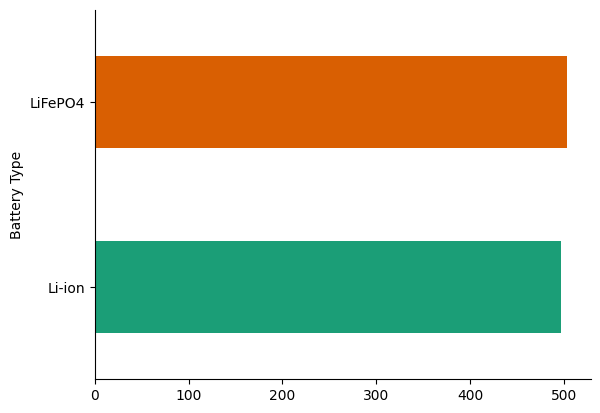

In [81]:
# Battery Type
battery_df.groupby('Battery Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

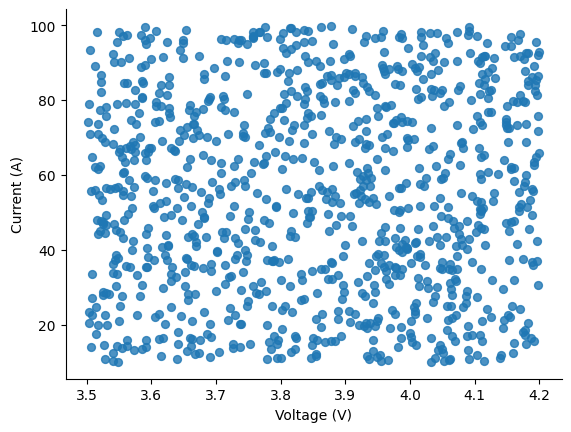

In [82]:
# Voltage (V) vs Current (A)
battery_df.plot(kind='scatter', x='Voltage (V)', y='Current (A)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

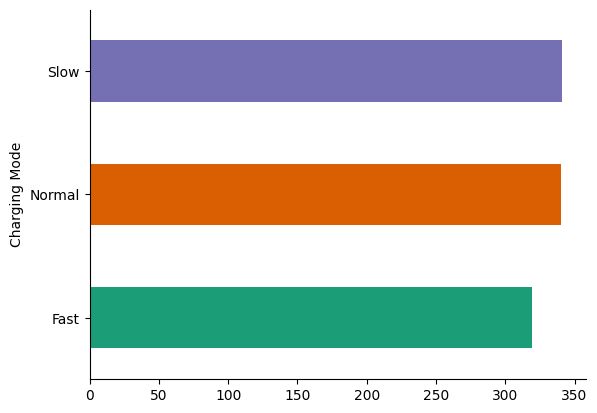

In [83]:
# Charging Mode
battery_df.groupby('Charging Mode').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [84]:
# categorical and numerical columns
categorical_cols = battery_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = battery_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [85]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    battery_df[col] = le.fit_transform(battery_df[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
battery_df[numerical_cols] = scaler.fit_transform(battery_df[numerical_cols])

In [86]:
# Check mappings of encoded categorical values
for col, encoder in label_encoders.items():
    print(f"Mapping for '{col}':")
    for original, encoded in zip(encoder.classes_, encoder.transform(encoder.classes_)):
        print(f"  {original} -> {encoded}")

Mapping for 'Charging Mode':
  Fast -> 0
  Normal -> 1
  Slow -> 2
Mapping for 'Battery Type':
  Li-ion -> 0
  LiFePO4 -> 1
Mapping for 'EV Model':
  Model A -> 0
  Model B -> 1
  Model C -> 2


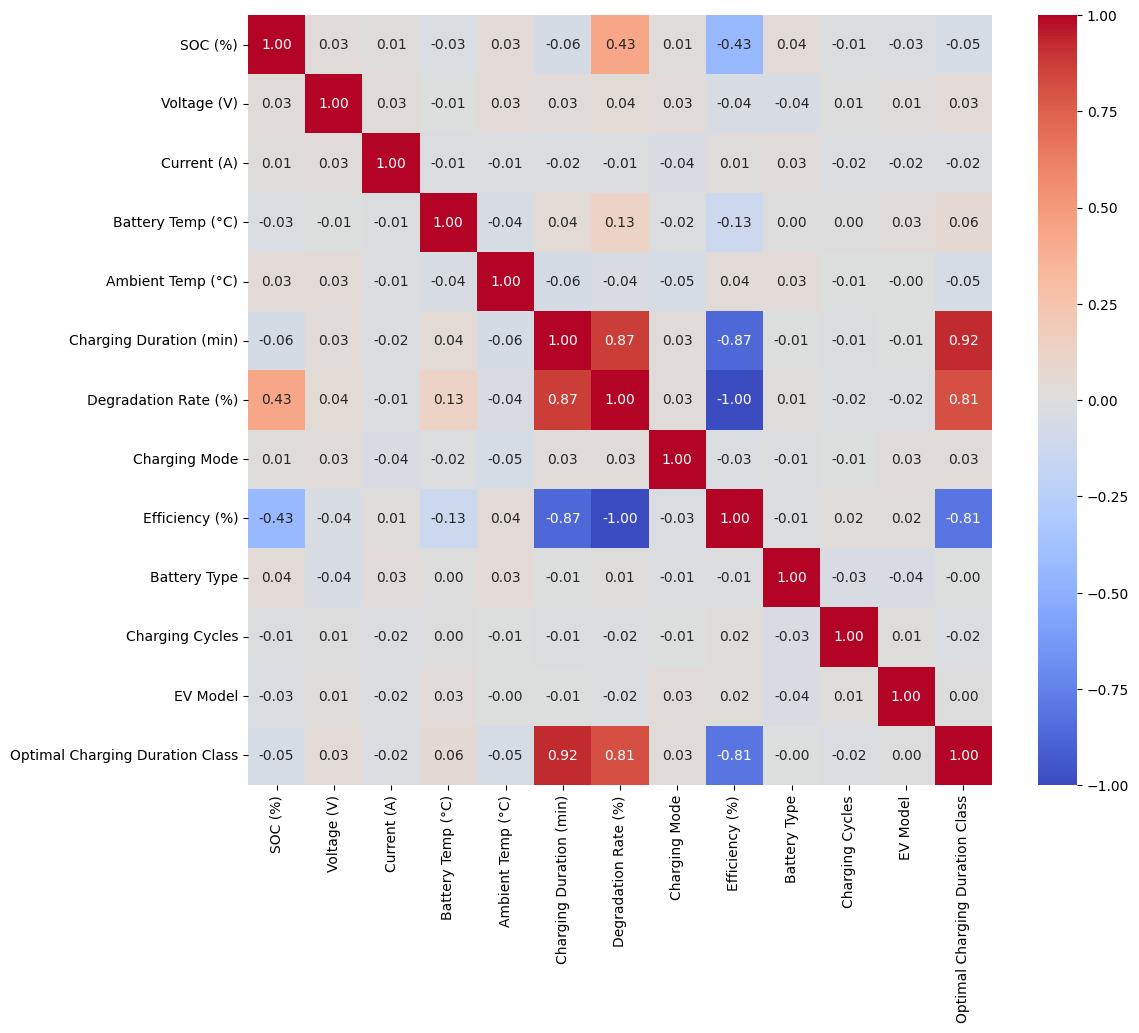

In [87]:
corr_matrix = battery_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [88]:
# Find highly correlated columns
highly_correlated_cols = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.7]
highly_correlated_cols

[('Charging Duration (min)', 'Degradation Rate (%)'),
 ('Charging Duration (min)', 'Efficiency (%)'),
 ('Charging Duration (min)', 'Optimal Charging Duration Class'),
 ('Degradation Rate (%)', 'Charging Duration (min)'),
 ('Degradation Rate (%)', 'Efficiency (%)'),
 ('Degradation Rate (%)', 'Optimal Charging Duration Class'),
 ('Efficiency (%)', 'Charging Duration (min)'),
 ('Efficiency (%)', 'Degradation Rate (%)'),
 ('Efficiency (%)', 'Optimal Charging Duration Class'),
 ('Optimal Charging Duration Class', 'Charging Duration (min)'),
 ('Optimal Charging Duration Class', 'Degradation Rate (%)'),
 ('Optimal Charging Duration Class', 'Efficiency (%)')]

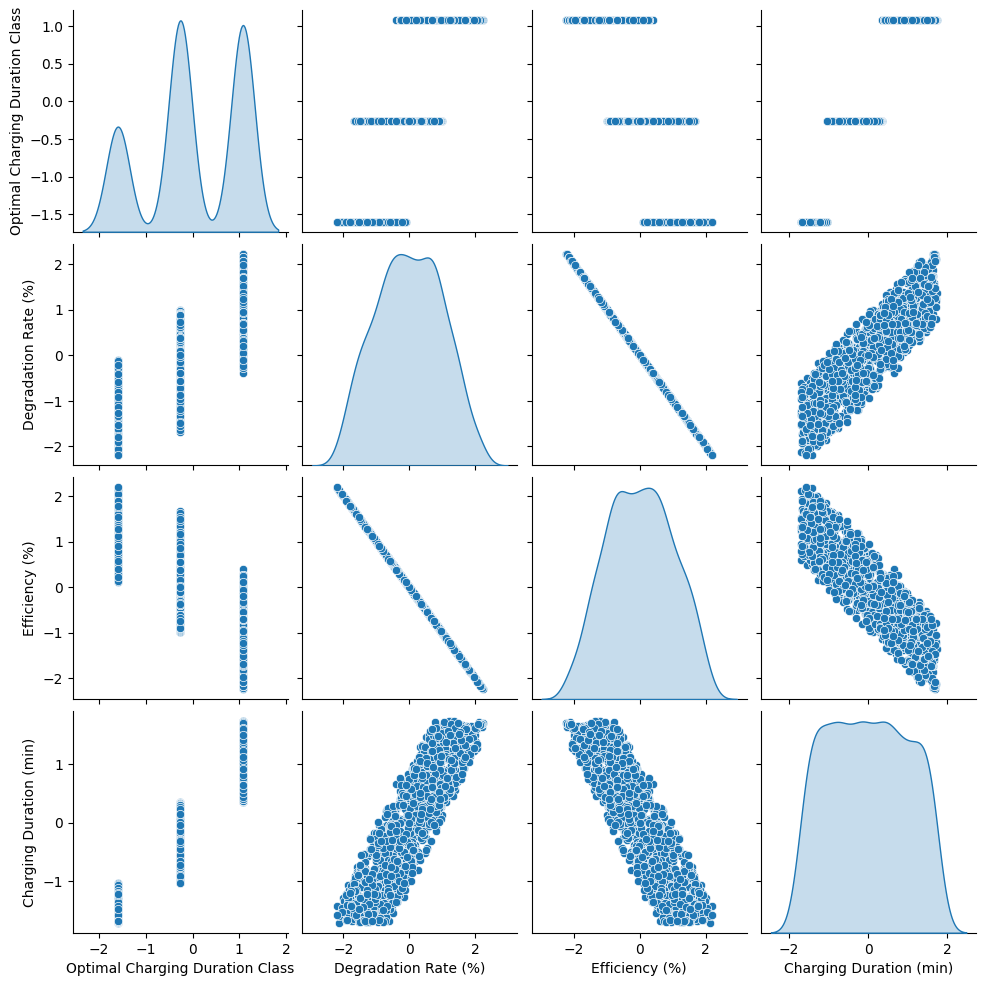

In [89]:
## Plot pairplot for the high corr features
# Extract unique column names from the list of tuples
unique_highly_correlated_cols = list(set([col for pair in highly_correlated_cols for col in pair]))

# Plot pairplot using the unique column names
sns.pairplot(battery_df[unique_highly_correlated_cols], diag_kind='kde')
plt.show()

**How to read the Pairplot:**

* Diagonal plots (KDE plots) show the distribution of each individual variable.

* Scatter plots (off-diagonal) represent relationships between two variables.

***Observations:***

Optimal Charging Duration Class (Target)

* Clearly shows three distinct groups.

* These discrete clusters represent Short (0), Medium (1), and Long (2) duration classes.

***Relationships observed:***

* Charging Duration (min) and Efficiency (%).

* Strong negative linear correlation: as duration increases, efficiency decreases. Longer charging durations may reduce battery efficiency.

* Charging Duration vs Degradation Rate:

  * Positive linear correlation. Longer charging durations correlate with increased degradation rate.
* Efficiency vs Degradation Rate:
  * Strong negative correlation (almost perfect line). As degradation rate increases, efficiency decreases sharply. Indicates that degradation directly affects efficiency.


***Practical Insights:***
* Shorter durations usually correlate with better efficiency and less degradation.
* High degradation directly reduces efficiency, indicating the importance of minimizing degradation.
* Battery efficiency and charging duration show clear inverse relationship.


***Actionable insights from this analysis:***
* Optimal charging practices should prioritize shorter charging times to maintain efficiency.
* Strategies should consider balancing charging duration and acceptable degradation rates.

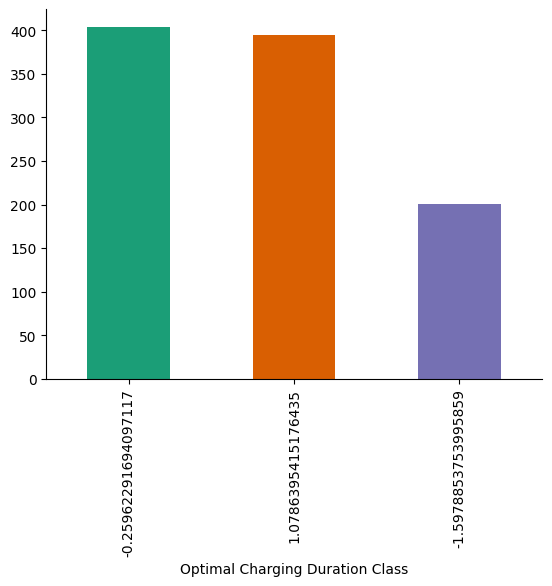

In [90]:
# Check if optimal charging duration class is imbalanced
battery_df['Optimal Charging Duration Class'].value_counts().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [91]:
# Check for outliers
def check_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
# Check for outliers
def check_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

outliers = {col: check_outliers(battery_df, col) for col in numerical_cols}
outliers

{'SOC (%)': Empty DataFrame
 Columns: [SOC (%), Voltage (V), Current (A), Battery Temp (°C), Ambient Temp (°C), Charging Duration (min), Degradation Rate (%), Charging Mode, Efficiency (%), Battery Type, Charging Cycles, EV Model, Optimal Charging Duration Class]
 Index: [],
 'Voltage (V)': Empty DataFrame
 Columns: [SOC (%), Voltage (V), Current (A), Battery Temp (°C), Ambient Temp (°C), Charging Duration (min), Degradation Rate (%), Charging Mode, Efficiency (%), Battery Type, Charging Cycles, EV Model, Optimal Charging Duration Class]
 Index: [],
 'Current (A)': Empty DataFrame
 Columns: [SOC (%), Voltage (V), Current (A), Battery Temp (°C), Ambient Temp (°C), Charging Duration (min), Degradation Rate (%), Charging Mode, Efficiency (%), Battery Type, Charging Cycles, EV Model, Optimal Charging Duration Class]
 Index: [],
 'Battery Temp (°C)': Empty DataFrame
 Columns: [SOC (%), Voltage (V), Current (A), Battery Temp (°C), Ambient Temp (°C), Charging Duration (min), Degradation Rate 

No outliers accoding to IQR method.

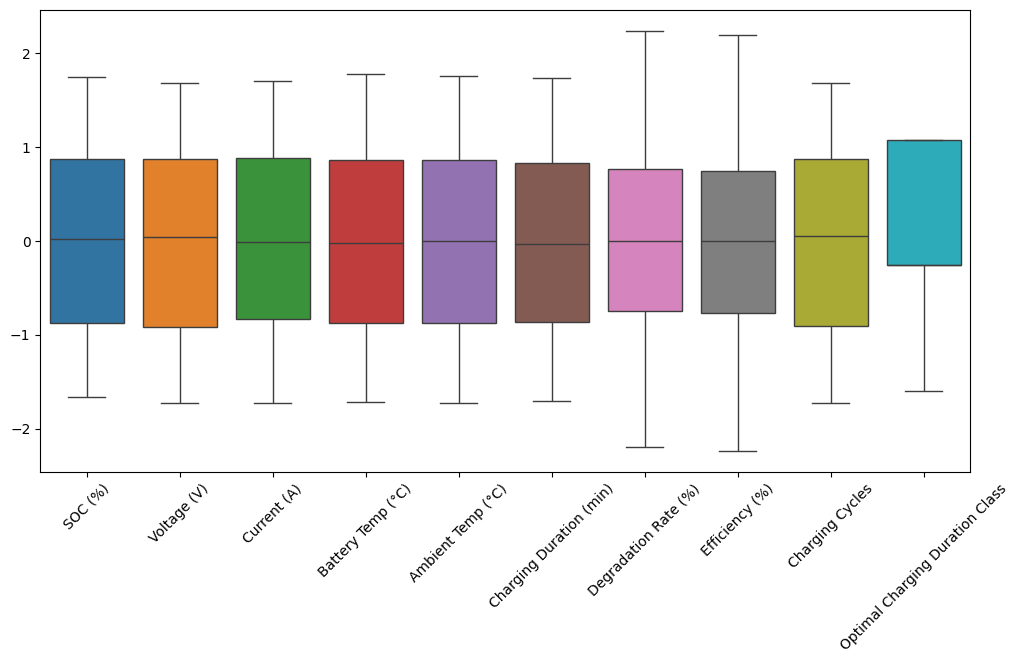

In [92]:
# Plotting the above to confirm
plt.figure(figsize=(12, 6))
sns.boxplot(data=battery_df[numerical_cols])
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

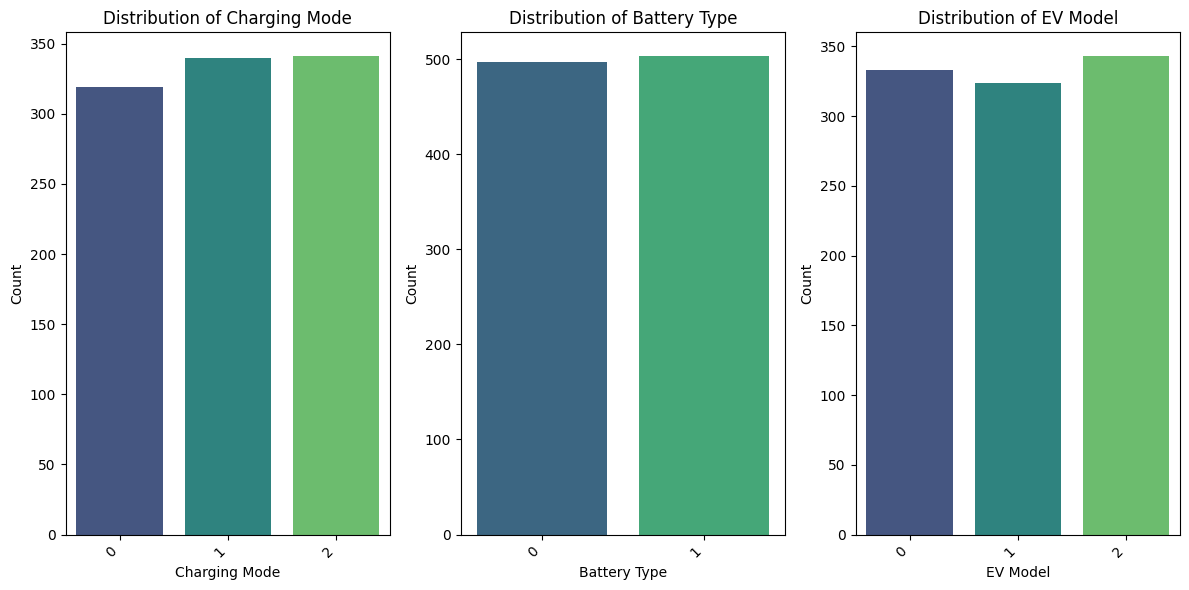

In [93]:
# Distribution of Categorical Variables
plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    # Use seaborn.countplot instead of pandas plot
    sns.countplot(data=battery_df, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    # Rotate x-axis labels if necessary for readability
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

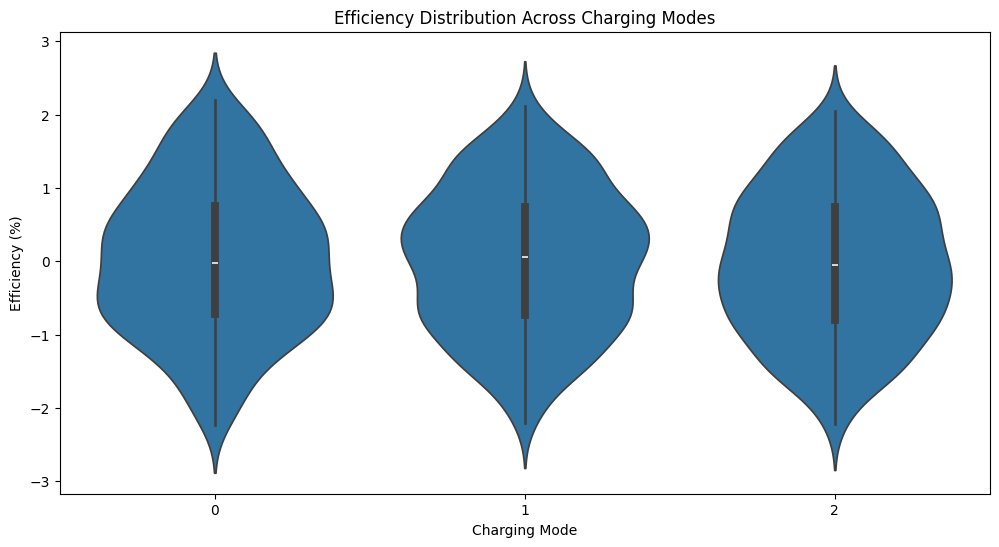

In [94]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Charging Mode', y='Efficiency (%)', data=battery_df)
plt.title('Efficiency Distribution Across Charging Modes')
plt.show()

Since there is no much variation, it is not an important factor.

ANOVA, which stands for Analysis of Variance, is a statistical test used to determine if there are any statistically significant differences between the means of three or more independent groups [1].

Here's a breakdown of when and why you would perform ANOVA:

When to Perform ANOVA:

You should perform ANOVA when you have:

* One continuous dependent variable: This is the outcome you are measuring. In your case, an example would be 'Charging Duration (min)'.
* One or more categorical independent variables (factors): These are the groups you are comparing. Each factor has at least three levels (groups). In your code, 'Battery Type' or 'Charging Mode' could be treated as factors, and their unique values are the levels.
* Independent observations: The data points in each group should be independent of each other.
Approximately normally distributed data within each group: While ANOVA is relatively robust to violations of this assumption, especially with larger sample sizes, it's an underlying assumption.
* Homogeneity of variances (homoscedasticity): The variance of the dependent variable should be roughly equal across all groups.


A classic example is comparing the yield of a crop under three different fertilizer mixtures. Here, the crop yield is the continuous dependent variable, and the type of fertilizer is the categorical independent variable with three levels.

In [95]:
# Quantify the relationship between numerical and categorical cols using ANOVA
from scipy import stats
for col in categorical_cols:
    f_stat, p_value = stats.f_oneway(*(battery_df[battery_df[col] == category]['Charging Duration (min)'] for category in battery_df[col].unique()))
    print(f'ANOVA result for {col}: F-stat={f_stat:.2f}, P-value={p_value:.4f}')

ANOVA result for Charging Mode: F-stat=0.56, P-value=0.5726
ANOVA result for Battery Type: F-stat=0.04, P-value=0.8337
ANOVA result for EV Model: F-stat=2.54, P-value=0.0791


1. Charging Mode (P-value = 0.5726)
* P-value is high (>0.05) → Fail to reject H₀.
* This means Charging Mode does not significantly impact the numeric feature being tested (e.g., Charging Duration (min)).
* Conclusion: Charging Mode is not a strong predictor of the numeric variable tested.

2. Battery Type (P-value = 0.8337)
* P-value is very high → No evidence that Battery Type affects the numeric feature.
* Conclusion: Battery Type does not have a statistically significant effect on the numeric variable.

3. EV Model (P-value = 0.0791)
* P-value is slightly above 0.05, meaning it’s close to being significant but not quite.
* The EV Model might have some effect on the numeric variable, but it’s not strong enough to be statistically significant.
* If more data was available, this effect might become significant.

1.  None of the categorical variables significantly affect the numeric variable based on these p-values.
2.  EV Model shows some influence but is not statistically significant (P = 0.0791).
3.  Charging Mode and Battery Type are not useful predictors for the tested numeric variable.

In [96]:
# battery_df[battery_df['Battery Type'] == 'Li-on']['Charging Mode'].unique()

Analyzing Charging Mode across Battery Types:
  ANOVA result for Battery Type and Charging Mode:
    F-statistic: 0.10
    P-value: 0.7518
  Conclusion: There is no statistically significant difference in Charging Mode between different battery types.

Analyzing Efficiency (%) across Battery Types:
  ANOVA result for Battery Type and Efficiency (%):
    F-statistic: 0.16
    P-value: 0.6865
  Conclusion: There is no statistically significant difference in Efficiency (%) between different battery types.


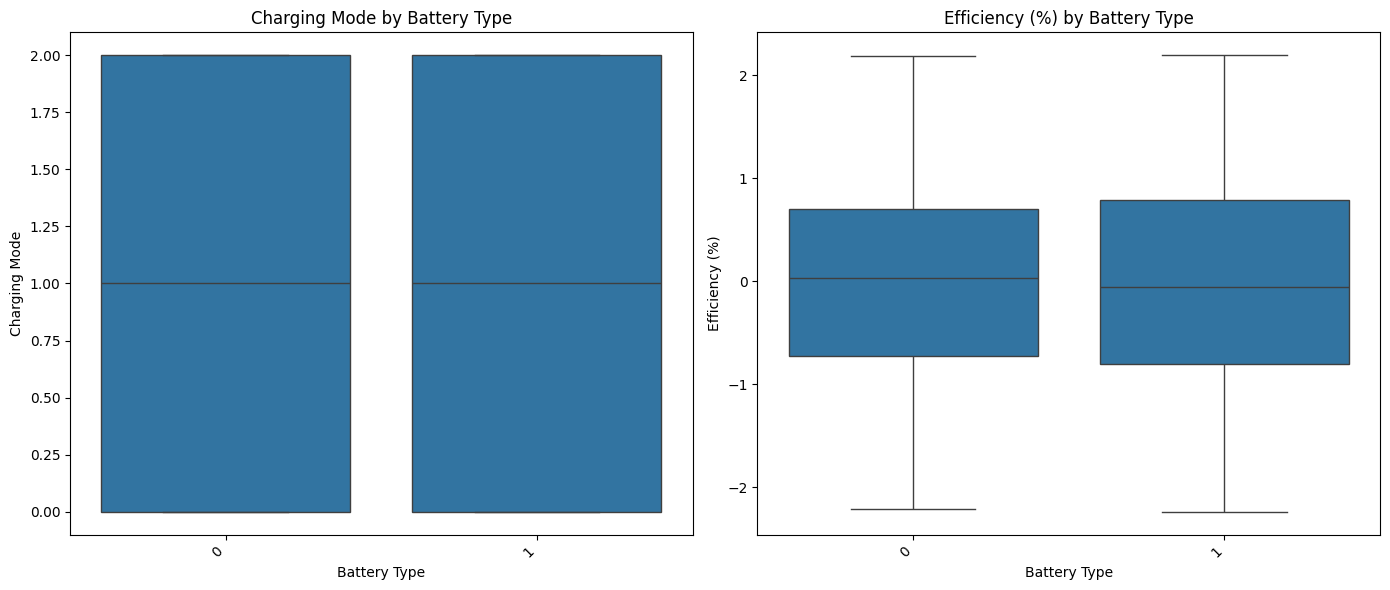

In [97]:
# Check if one battery type has faster charging mode

# Check if one battery type has a higher Charging Rate (kW)
print("Analyzing Charging Mode across Battery Types:")
# Create groups for ANOVA
charging_rate_groups = [
    battery_df[battery_df['Battery Type'] == battery_type]['Charging Mode']
    for battery_type in battery_df['Battery Type'].unique()
]

# Perform ANOVA
f_stat_rate, p_value_rate = stats.f_oneway(*charging_rate_groups)

print(f'  ANOVA result for Battery Type and Charging Mode:')
print(f'    F-statistic: {f_stat_rate:.2f}')
print(f'    P-value: {p_value_rate:.4f}')

if p_value_rate < 0.05:
    print("  Conclusion: There is a statistically significant difference in Charging Mode between different battery types.")
else:
    print("  Conclusion: There is no statistically significant difference in Charging Mode between different battery types.")

# Check if one battery type has better Efficiency (%)
print("\nAnalyzing Efficiency (%) across Battery Types:")
# Create groups for ANOVA
efficiency_groups = [
    battery_df[battery_df['Battery Type'] == battery_type]['Efficiency (%)']
    for battery_type in battery_df['Battery Type'].unique()
]

# Perform ANOVA
f_stat_eff, p_value_eff = stats.f_oneway(*efficiency_groups)

print(f'  ANOVA result for Battery Type and Efficiency (%):')
print(f'    F-statistic: {f_stat_eff:.2f}')
print(f'    P-value: {p_value_eff:.4f}')

if p_value_eff < 0.05:
    print("  Conclusion: There is a statistically significant difference in Efficiency (%) between different battery types.")
else:
    print("  Conclusion: There is no statistically significant difference in Efficiency (%) between different battery types.")

# Visualize the relationships
plt.figure(figsize=(14, 6))

# Box plot for Charging Rate (kW) vs Battery Type
plt.subplot(1, 2, 1)
sns.boxplot(x='Battery Type', y='Charging Mode', data=battery_df)
plt.title('Charging Mode by Battery Type')
plt.xlabel('Battery Type')
plt.ylabel('Charging Mode')
plt.xticks(rotation=45, ha='right')

# Box plot for Efficiency (%) vs Battery Type
plt.subplot(1, 2, 2)
sns.boxplot(x='Battery Type', y='Efficiency (%)', data=battery_df)
plt.title('Efficiency (%) by Battery Type')
plt.xlabel('Battery Type')
plt.ylabel('Efficiency (%)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Conclusion: There is no statistically significant difference in Charging Mode between different battery types and Efficiency and battery types

In [98]:
battery_df['Charging Mode'].unique()

array([0, 2, 1])

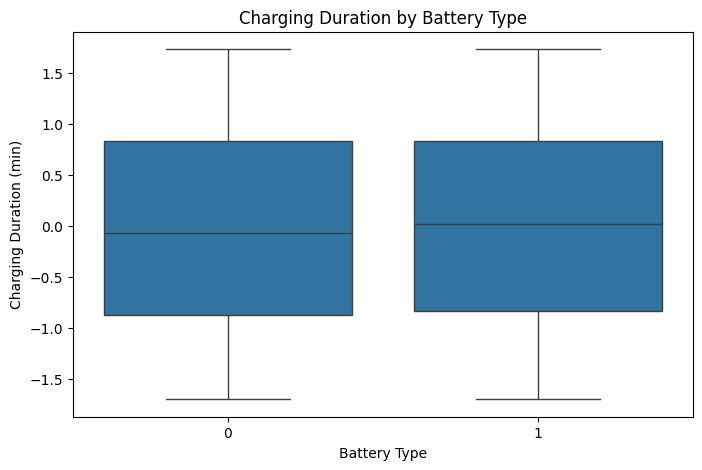

In [99]:
# Plot battery type vs charging duration
plt.figure(figsize=(8, 5))
sns.boxplot(x='Battery Type', y='Charging Duration (min)', data=battery_df)
plt.title('Charging Duration by Battery Type')
plt.show()

Battery type doesnt affect the charging duration

In [100]:
# Define degradation thresholds
def classify_battery(degradation):
    if degradation < 30:
        return "Healthy"
    elif 30 <= degradation < 50:
        return "Needs Maintenance"
    else:
        return "Needs Replacement"

# Apply classification
battery_df['Battery_Status'] = battery_df['Degradation Rate (%)'].apply(classify_battery)

# Count how many batteries fall into each category
print(battery_df['Battery_Status'].value_counts())

Battery_Status
Healthy    1000
Name: count, dtype: int64


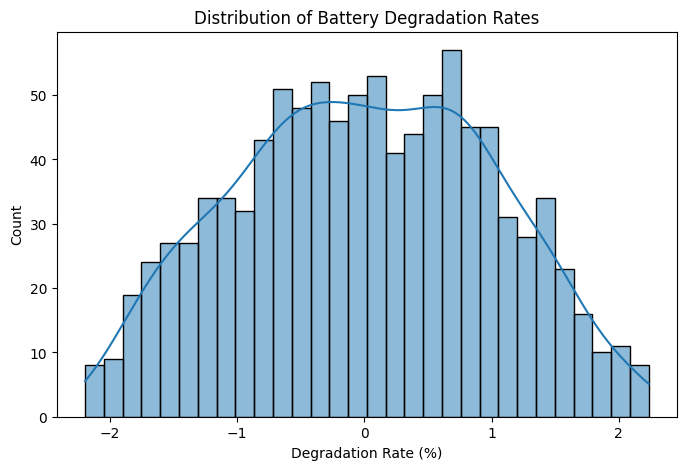

In [101]:
plt.figure(figsize=(8,5))
sns.histplot(battery_df['Degradation Rate (%)'], bins=30, kde=True)
plt.title("Distribution of Battery Degradation Rates")
plt.xlabel("Degradation Rate (%)")
plt.ylabel("Count")
plt.show()

In [102]:
# Compute dynamic thresholds based on quantiles
low_threshold = battery_df['Degradation Rate (%)'].quantile(0.25)  # Lower 25% as "Healthy"
mid_threshold = battery_df['Degradation Rate (%)'].quantile(0.75)  # Upper 25% as "Needs Replacement"

print(f"New Thresholds - Healthy: < {low_threshold:.2f}, Needs Maintenance: {low_threshold:.2f} - {mid_threshold:.2f}, Needs Replacement: > {mid_threshold:.2f}")

New Thresholds - Healthy: < -0.74, Needs Maintenance: -0.74 - 0.76, Needs Replacement: > 0.76


In [103]:
def classify_battery(degradation):
    if degradation < low_threshold:
        return "Healthy"
    elif low_threshold <= degradation < mid_threshold:
        return "Needs Maintenance"
    else:
        return "Needs Replacement"

# Apply classification
battery_df['Battery_Status'] = battery_df['Degradation Rate (%)'].apply(classify_battery)

# Count updated categories
print(battery_df['Battery_Status'].value_counts())

Battery_Status
Needs Maintenance    500
Needs Replacement    250
Healthy              250
Name: count, dtype: int64


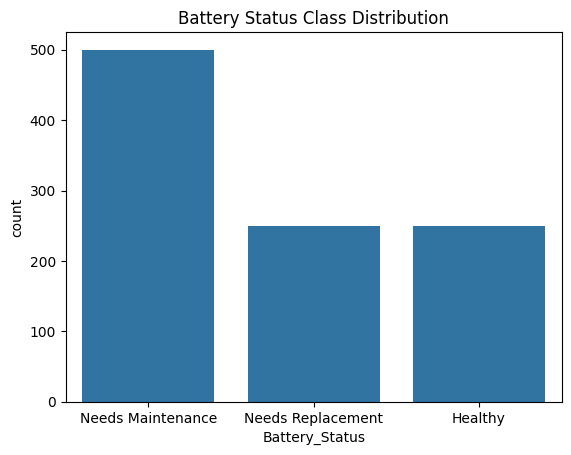

In [104]:
sns.countplot(x=battery_df['Battery_Status'])
plt.title("Battery Status Class Distribution")
plt.show()

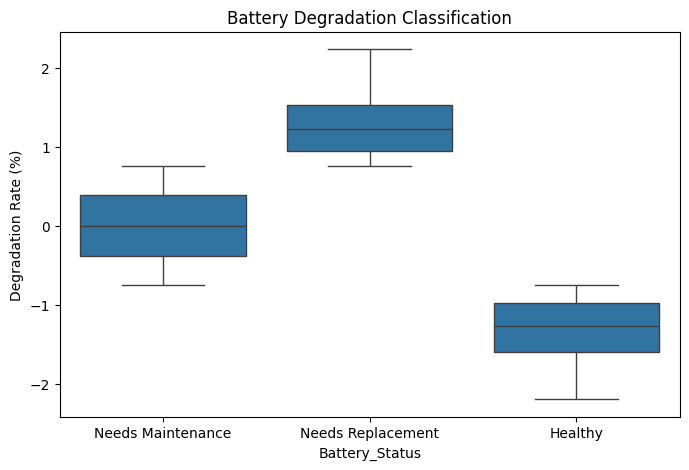

In [105]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Battery_Status', y='Degradation Rate (%)', data=battery_df)
plt.title("Battery Degradation Classification")
plt.show()

### **Modeling**

Battery Performance:
1. What factors most significantly impact charging duration?
['Degradation Rate (%)', 'Efficiency (%)', 'SOC (%)', 'Battery Temp (°C)']

In [106]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, f1_score, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split # Explicitly import train_test_split

# Exclude 'Charging Duration (min)' AND 'Battery_Status' from features
X = battery_df.drop(columns=['Charging Duration (min)', 'Battery_Status'])
y = battery_df['Charging Duration (min)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Extract feature importance
importances = model.feature_importances_
feature_names = X_train.columns

# Display sorted feature importance
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f'{feature}: {importance:.4f}')

Optimal Charging Duration Class: 0.8657
SOC (%): 0.0430
Degradation Rate (%): 0.0396
Efficiency (%): 0.0374
Battery Temp (°C): 0.0048
Current (A): 0.0020
Ambient Temp (°C): 0.0020
Charging Cycles: 0.0020
Voltage (V): 0.0019
Charging Mode: 0.0006
EV Model: 0.0005
Battery Type: 0.0004


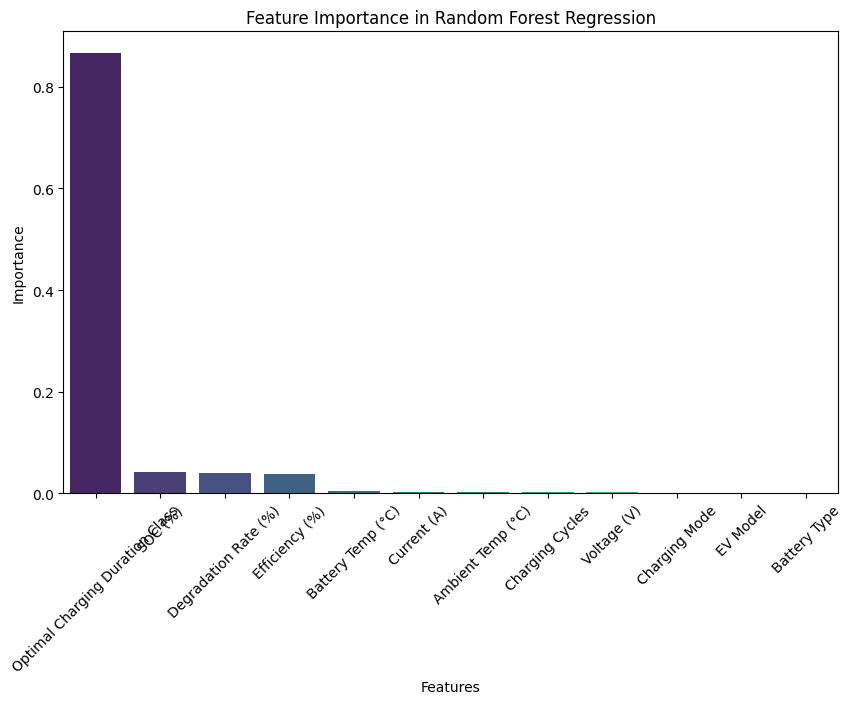

In [107]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=[feature for feature, importance in sorted_features], y=[importance for feature, importance in sorted_features], palette='viridis')
plt.title('Feature Importance in Random Forest Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [108]:
X = battery_df.drop(columns=['Optimal Charging Duration Class', 'Charging Duration (min)', 'Battery_Status'])
y = battery_df['Charging Duration (min)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Extract feature importance
importances = model.feature_importances_
feature_names = X_train.columns

# Display sorted feature importance
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f'{feature}: {importance:.4f}')

Degradation Rate (%): 0.4851
Efficiency (%): 0.3369
SOC (%): 0.1631
Battery Temp (°C): 0.0071
Voltage (V): 0.0018
Charging Cycles: 0.0016
Ambient Temp (°C): 0.0015
Current (A): 0.0015
Charging Mode: 0.0005
EV Model: 0.0005
Battery Type: 0.0003


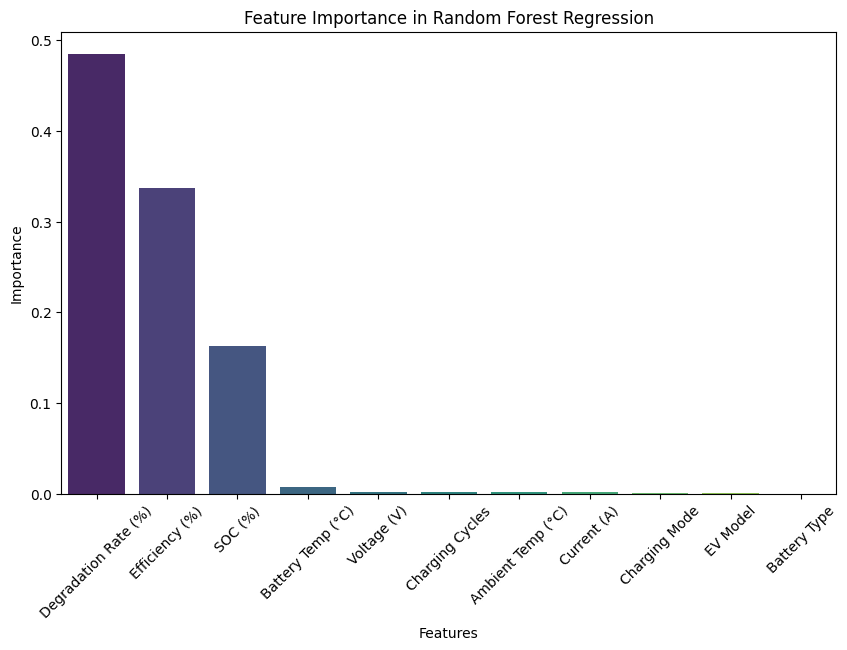

In [109]:
# Plot feature impotances
plt.figure(figsize=(10, 6))
sns.barplot(x=[feature for feature, importance in sorted_features], y=[importance for feature, importance in sorted_features], palette='viridis')
plt.title('Feature Importance in Random Forest Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

['Degradation Rate (%)', 'Efficiency (%)', 'SOC (%)', 'Battery Temp (°C)']


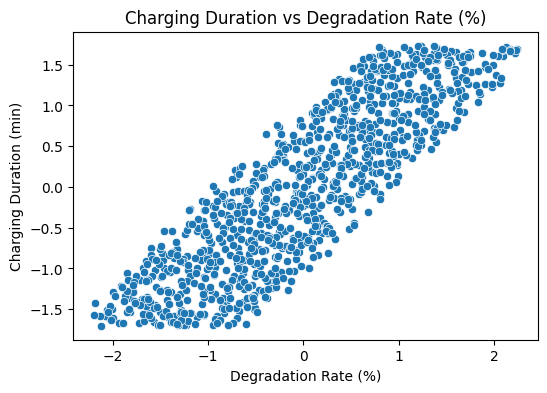

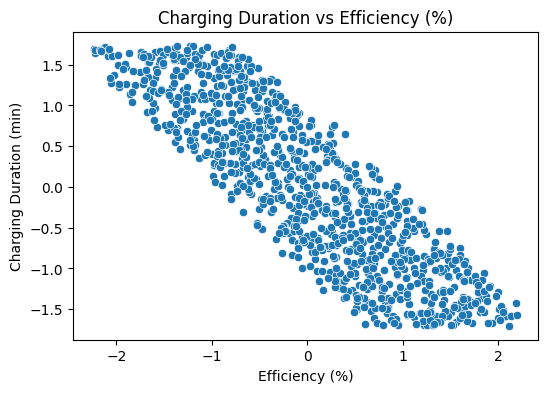

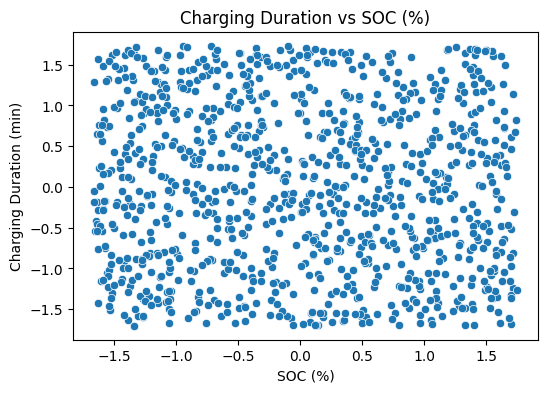

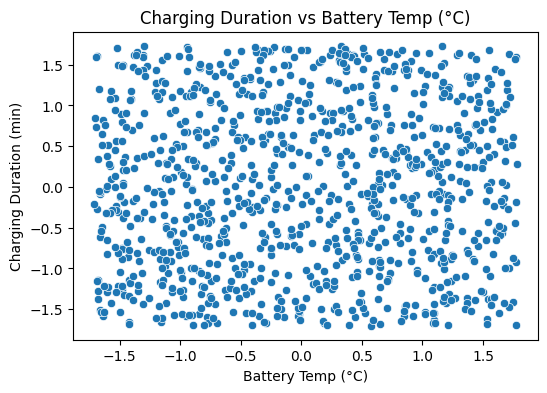

In [110]:
# Select the top N features (e.g., top 4)
top_n = 4
top_features = [feature for feature, importance in sorted_features[:top_n]]
print(top_features)
for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=battery_df[feature], y=battery_df['Charging Duration (min)'])
    plt.title(f'Charging Duration vs {feature}')
    plt.show()

* **Degradation Rate vs. Charging Duration**
  * Strong positive correlation → As degradation increases, charging time increases.
  * Likely cause: Older/degraded batteries may charge slower due to efficiency loss.
* **Efficiency vs. Charging Duration**
  * Strong negative correlation → More efficient batteries charge faster.
  * Likely cause: Lower efficiency means more energy is lost as heat, extending charging time.

* The other two variables doesnt show any relationship.

In [111]:
X = battery_df[['Degradation Rate (%)', 'Battery Temp (°C)']]
y = battery_df['Efficiency (%)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))

R² Score: 1.0


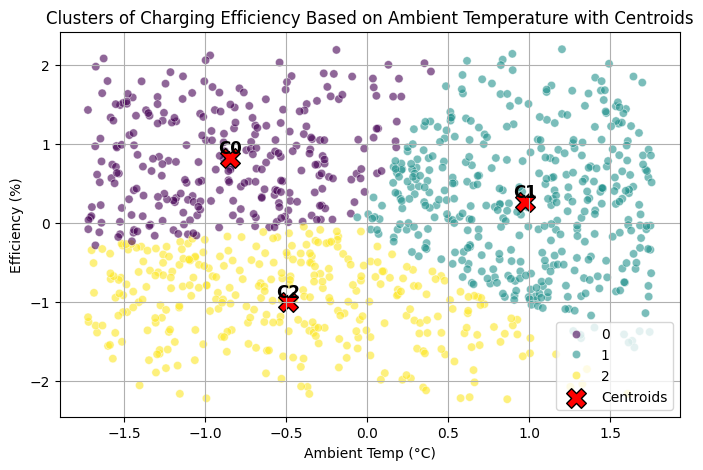

In [112]:
X_clustering = battery_df[['Ambient Temp (°C)', 'Efficiency (%)']]

# Apply K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init for KMeans
battery_df['Efficiency_Cluster'] = kmeans.fit_predict(X_clustering)

# Get the centroids from the fitted model
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 5))

# Scatter plot of the data points colored by cluster
sns.scatterplot(x=battery_df['Ambient Temp (°C)'], y=battery_df['Efficiency (%)'], hue=battery_df['Efficiency_Cluster'], palette='viridis', alpha=0.6)

# Plot the centroids
plt.scatter(
    centroids[:, 0],  # X-coordinate of centroids (Ambient Temp)
    centroids[:, 1],  # Y-coordinate of centroids (Efficiency)
    c='red',          # Color of the centroids
    s=200,            # Size of the centroid markers
    marker='X',       # Marker style (an 'X')
    label='Centroids',
    edgecolor='black' # Add an edge for better visibility
)

# Add labels for centroids (optional)
for i, (x, y) in enumerate(zip(centroids[:, 0], centroids[:, 1])):
    plt.text(x, y, f'C{i}', fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')


plt.title("Clusters of Charging Efficiency Based on Ambient Temperature with Centroids")
plt.xlabel('Ambient Temp (°C)') # Add xlabel
plt.ylabel('Efficiency (%)')    # Add ylabel
plt.legend()
plt.grid(True) # Add grid
plt.show()

* Best Efficiency: Occurs in the higher temperature range (Cluster 1)
*  Worst Efficiency: Occurs in low temperatures (Cluster 2).
* Optimal Temperature Range: Find the mean Ambient Temperature in Cluster 1.

In [113]:
optimal_temp = battery_df[battery_df['Efficiency_Cluster'] == 1]['Ambient Temp (°C)'].mean()
print("Optimal Ambient Temperature for Best Efficiency:", optimal_temp)

Optimal Ambient Temperature for Best Efficiency: 0.9776969558292367


**Predictive Maintenance:**
1. Can battery degradation be predicted accurately from current, voltage, and temperature?
Since r2 score is in negative, these variables are not enough. Adding new variables still did not have a clear impact and therefore it cannot be easily predicted using this dataset. Dataset can be small in this case.
2. When is a battery likely to require maintenance or replacement based on its degradation rate?

      Estimated years until maintenance: 2.0 years

      Estimated years until replacement: 12.0 years

In [114]:
X = battery_df[['Current (A)', 'Voltage (V)', 'Battery Temp (°C)', 'Charging Cycles',
                    'Degradation Rate (%)', 'Efficiency (%)', 'SOC (%)']]
y = battery_df['Battery_Status']  # Labels: 'Healthy', 'Needs Maintenance', 'Needs Replacement'

# Encode target variable
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)  # Convert text labels to numbers

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classification model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy
print("Classification Accuracy:", clf.score(X_test, y_test))

Classification Accuracy: 0.995


In [115]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.99      1.00       116
           2       1.00      1.00      1.00        39

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



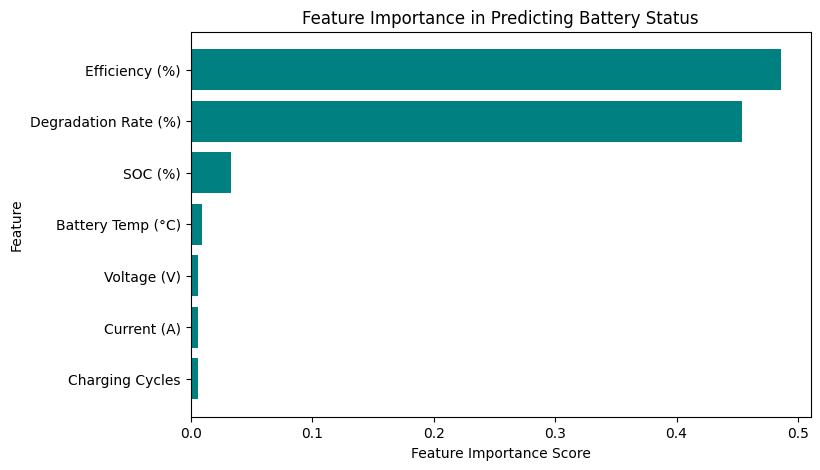

In [116]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh([X_train.columns[i] for i in sorted_indices], importances[sorted_indices], color='teal')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Battery Status")
plt.gca().invert_yaxis()
plt.show()

In [117]:
def classify_battery(degradation):
    if degradation < 0:
        return "Healthy"
    elif 0 <= degradation < 1.3:
        return "Needs Maintenance"
    else:
        return "Needs Replacement"

# Apply new classification
battery_df['Battery_Status_Updated'] = battery_df['Degradation Rate (%)'].apply(classify_battery)

# Count updated categories
print(battery_df['Battery_Status_Updated'].value_counts())


Battery_Status_Updated
Healthy              499
Needs Maintenance    390
Needs Replacement    111
Name: count, dtype: int64


In [118]:
def predict_maintenance_time(current_degradation, annual_degradation_rate):
    # Estimate years left before reaching maintenance threshold
    years_to_maintenance = (0.5 - current_degradation) / annual_degradation_rate
    years_to_replacement = (1.5 - current_degradation) / annual_degradation_rate
    return years_to_maintenance, years_to_replacement

# Example battery
current_degradation = 0.3  # Current degradation rate in %
annual_degradation_rate = 0.1  # Estimated yearly increase in degradation

years_to_maintenance, years_to_replacement = predict_maintenance_time(current_degradation, annual_degradation_rate)
print(f"Estimated years until maintenance: {years_to_maintenance:.1f} years")
print(f"Estimated years until replacement: {years_to_replacement:.1f} years")

Estimated years until maintenance: 2.0 years
Estimated years until replacement: 12.0 years


# **Charging Station**

In [119]:
station_df = pd.read_csv('/content/ev-charging-stations-india.csv')
station_df.head()

name          state      city  \
0                 Neelkanth Star DC Charging Station        Haryana  Gurugram   
1                       Galleria DC Charging Station        Haryana  Gurugram   
2  Highway Xpress (Jaipur-Delhi) DC charging station      Rajasthan    Behror   
3                  Food Carnival DC Charging Station  Uttar Pradesh  Khatauli   
4                  Food Carnival AC Charging Station  Uttar Pradesh  Khatauli   

                                             address lattitude  longitude  \
0  Neelkanth Star Karnal, NH 44, Gharunda, Kutail...   29.6019    76.9803   
1  DLF Phase IV, Sector 28, Gurugram, Haryana 122022   28.4673    77.0818   
2  Jaipur to Delhi Road, Behror Midway, Behror, R...   27.8751    76.2760   
3  Fun and Food Carnival, NH 58, Khatauli Bypass,...   29.3105    77.7218   
4  NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...   29.3105    77.7218   

   type  
0  12.0  
1  12.0  
2  12.0  
3  12.0  
4  12.0

In [120]:
station_df.isnull().sum()

name          0
state         0
city          0
address      40
lattitude     6
longitude     6
type          8
dtype: int64

In [121]:
station_df.describe()

longitude         type
count  1.541000e+03  1539.000000
mean   1.105323e+05     9.020793
std    3.064996e+06     4.136436
min    8.058454e+00     6.000000
25%    7.562036e+01     7.000000
50%    7.721257e+01     7.000000
75%    7.847983e+01    11.000000
max    8.510551e+07    24.000000

In [122]:
# Drop duplicate values
print(f"Number of duplicate rows: {station_df.duplicated().sum()}")
station_df.drop_duplicates(inplace=True)

Number of duplicate rows: 205


In [123]:
# Drop missing values
station_df.dropna(inplace=True)
station_df.reset_index(drop=True, inplace=True)

In [124]:
station_df.isnull().sum()

name         0
state        0
city         0
address      0
lattitude    0
longitude    0
type         0
dtype: int64

In [125]:
# Changing the datatype of variables
station_df["lattitude"] = station_df["lattitude"].str.replace(',', '').astype(float)
station_df["type"] = station_df["type"].astype(int)

In [126]:
station_df.type.unique()

array([12,  6,  7, 13, 14,  8, 15, 16, 17, 18, 19, 20, 21, 11, 10, 24, 22,
       23])

In [127]:
# Create 3 bins for type
bins = [0, 11, 16, float('inf')]
labels = ['slow', 'fast', 'ultra-fast']
station_df['type'] = pd.cut(station_df['type'], bins=bins, labels=labels, right=False)
station_df.head()

name          state      city  \
0                 Neelkanth Star DC Charging Station        Haryana  Gurugram   
1                       Galleria DC Charging Station        Haryana  Gurugram   
2  Highway Xpress (Jaipur-Delhi) DC charging station      Rajasthan    Behror   
3                  Food Carnival DC Charging Station  Uttar Pradesh  Khatauli   
4                  Food Carnival AC Charging Station  Uttar Pradesh  Khatauli   

                                             address  lattitude  longitude  \
0  Neelkanth Star Karnal, NH 44, Gharunda, Kutail...    29.6019    76.9803   
1  DLF Phase IV, Sector 28, Gurugram, Haryana 122022    28.4673    77.0818   
2  Jaipur to Delhi Road, Behror Midway, Behror, R...    27.8751    76.2760   
3  Fun and Food Carnival, NH 58, Khatauli Bypass,...    29.3105    77.7218   
4  NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...    29.3105    77.7218   

   type  
0  fast  
1  fast  
2  fast  
3  fast  
4  fast

In [128]:
station_df.describe()

lattitude     longitude
count  1291.000000  1.291000e+03
mean     19.907463  6.599958e+04
std       6.932307  2.368613e+06
min       8.390198  8.058454e+00
25%      13.032111  7.578536e+01
50%      19.051601  7.721756e+01
75%      27.179942  7.846415e+01
max      77.597289  8.510551e+07

The maximum value for the longitude variable is 85105514 and minimum value is 8.0584541 which could be a mistake. Also the maximum value for the latitude variable is 77.597289. The longitude and latitude of India ranges from approximately 68 to 97, from 8 to 37 respectively.

In [129]:
# Correcting the maximum and minimum values of the longitude variable
station_df.iloc[station_df.longitude.argmax(), 5] = station_df.iloc[station_df.longitude.argmax(), 5] / 10e5
station_df.iloc[station_df.longitude.argmin(), 5] = station_df.iloc[station_df.longitude.argmin(), 5] * 10

index = station_df.lattitude.argmax()
lat = station_df.loc[station_df.lattitude.argmax(), "lattitude"]

# Swap the values of latitude and longitude for row 535
station_df.loc[index, "lattitude"] = station_df.loc[index, "longitude"]
station_df.loc[index, "longitude"] = lat
station_df.describe()

lattitude    longitude
count  1291.000000  1291.000000
mean     19.857340    77.586028
std       6.746304     3.663208
min       8.390198    69.678673
25%      13.031820    75.794858
50%      19.051601    77.217962
75%      27.094893    78.466949
max      32.991800    94.168072

In [130]:
station_df.state.nunique()

59

There are only 28 states in India

In [131]:
station_df.state.unique()

array(['Haryana', 'Rajasthan', 'Uttar Pradesh', 'Himachal Pradesh',
       'Maharashtra', 'Delhi', 'Tamil Nadu', 'Uttarakhand', 'Gujarat',
       'Goa', 'Telangana', 'Karnataka', 'Punjab', 'Odisha', 'Pondicherry',
       'TamilNadu', 'Uttrakhand', 'WestBengal', 'Harayana', 'Chandigarh',
       'Hyderabadu00a0', 'Kerala', 'AndhraPradesh', 'TamiNadu',
       'Jharkhand', 'Bihar', 'West Bengal', 'Jammu', 'Andhra Pradesh',
       'Chhattisgarh', 'Madhya Pradesh', 'Andhra pradesh', 'Puducherry',
       'Jammu & Kashmir', 'Assam', 'Sikkim', 'Uttarakhand ', 'TAMIL NADU',
       'Andhra Pradesh ', 'Bhubhaneswar', 'Chattisgarh', 'chattisgarh',
       'Chikhali', 'Delhi NCR', 'Ernakulam', 'Hisar', 'Hyderabad',
       'Jajpur', 'Kochi', 'Limbdi', 'Maharashra', 'PUNJAB', 'Rajahmundry',
       'TELENGANA', 'Uttarkhand', 'Andra Pradesh', 'Karala', 'Tripura',
       'Andaman'], dtype=object)

In [132]:
wrong_state_name = {
    "Uttrakhand": "Uttarakhand",
    "Uttarkhand": "Uttarakhand",
    "Tamilnadu": "Tamil Nadu",
    "Taminadu": "Tamil Nadu",
    "Westbengal": "West Bengal",
    "Hyderabadu00A0": "Hyderabad",
    "Jammu": "Jammu & Kashmir",
    "Andhra pradesh": "Andhra Pradesh",
    "Andra Pradesh": "Andhra Pradesh",
    "Andhrapradesh": "Andhra Pradesh",
    "Rajahmundry": "Andhra Pradesh",
    "Puducherry": "Pondicherry",
    "Bhubhaneswar": "Odisha",
    "Chattisgarh": "Chhattisgarh",
    "Chikhali": "Maharashtra",
    "Maharashra": "Maharashtra",
    "Delhi Ncr": "Delhi",
    "Ernakulam": "Kerala",
    "Karala": "Kerala",
    "Kochi": "Kerala",
    "Hisar": "Haryana",
    "Harayana": "Haryana",
    "Jajpur": "Rajasthan",
    "Limbdi": "Gujarat",
    "Andaman": "Andaman & Nicobar",
}

station_df["state"] = station_df["state"].str.strip().str.title()
station_df["state"] = station_df["state"].replace(wrong_state_name)
station_df["state"] = station_df["state"].str.strip().str.title()
station_df.state.nunique(), station_df.state.unique()

(30,
 array(['Haryana', 'Rajasthan', 'Uttar Pradesh', 'Himachal Pradesh',
        'Maharashtra', 'Delhi', 'Tamil Nadu', 'Uttarakhand', 'Gujarat',
        'Goa', 'Telangana', 'Karnataka', 'Punjab', 'Odisha', 'Pondicherry',
        'West Bengal', 'Chandigarh', 'Hyderabad', 'Kerala',
        'Andhra Pradesh', 'Jharkhand', 'Bihar', 'Jammu & Kashmir',
        'Chhattisgarh', 'Madhya Pradesh', 'Assam', 'Sikkim', 'Telengana',
        'Tripura', 'Andaman & Nicobar'], dtype=object))

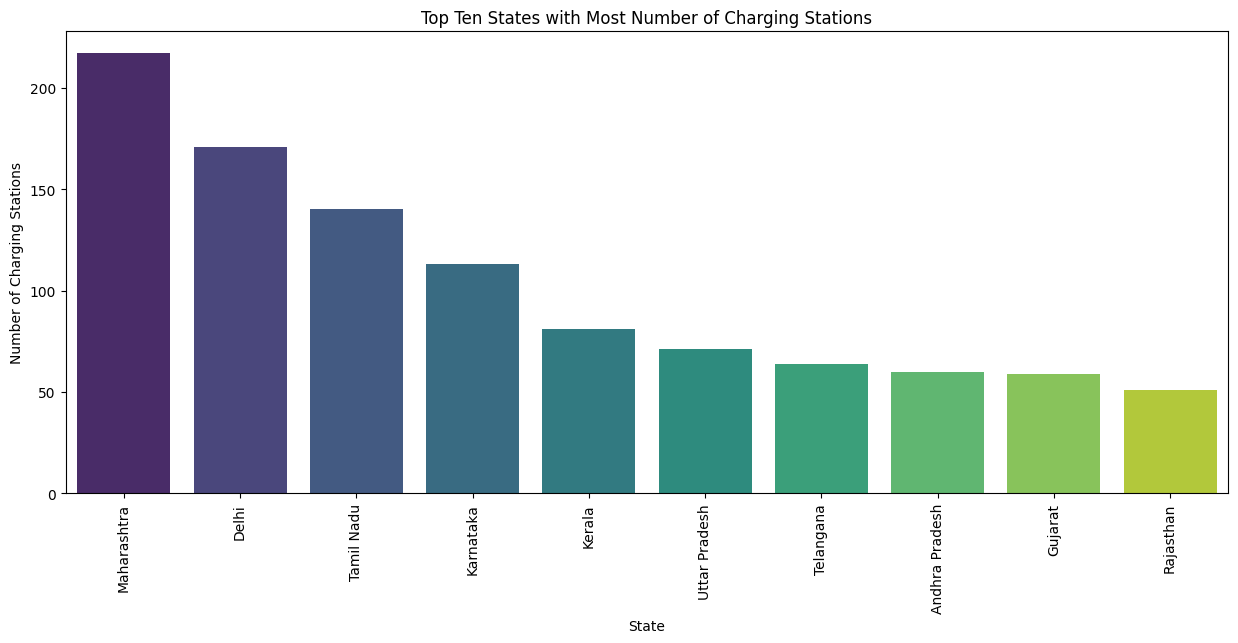

In [133]:
# Get the top ten states with most number of charging stations.
top_ten_states = station_df["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states["state"], y=top_ten_states["count"], palette = 'viridis')

# Add a title and labels to the axes.
plt.title("Top Ten States with Most Number of Charging Stations")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations")
plt.xticks(rotation=90)
plt.show()

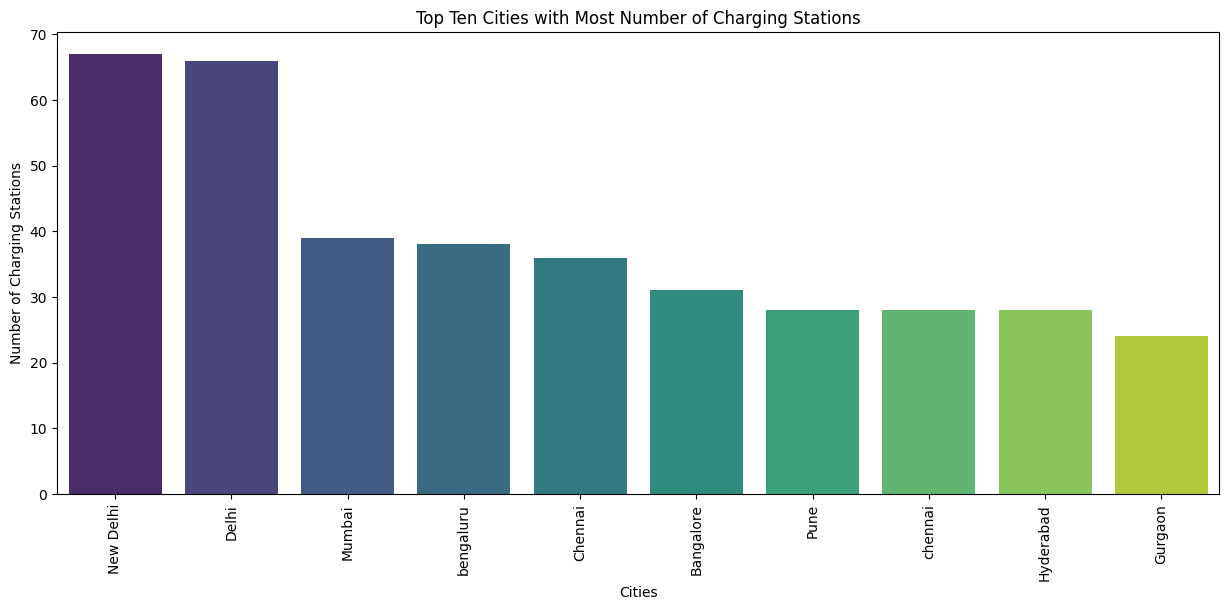

In [134]:
# Get the top ten cities with most number of charging stations.
top_ten_city = station_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_city["city"], y=top_ten_city["count"], palette = 'viridis')

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Most Number of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations")
plt.xticks(rotation=90)
plt.show()

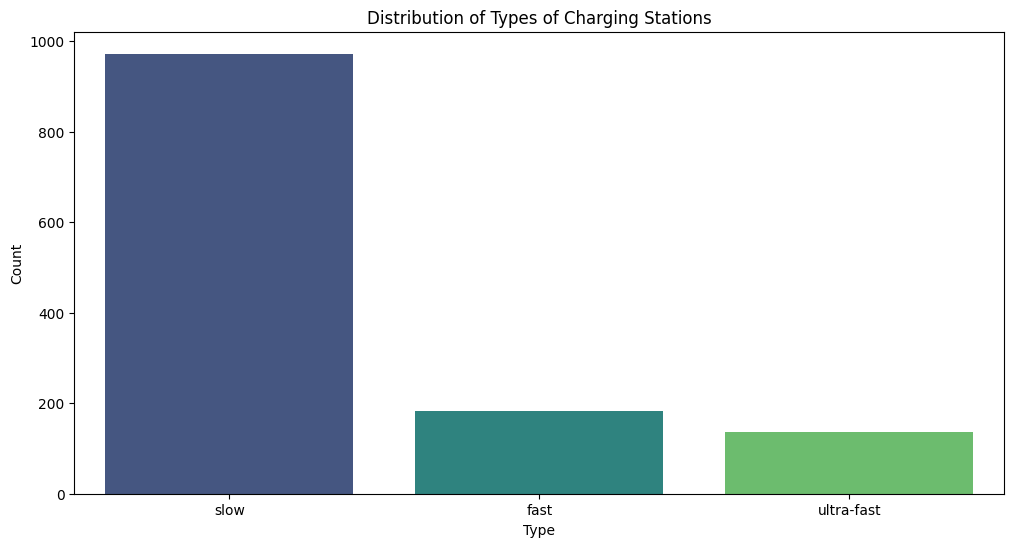

In [135]:
# Distribution of types of charging stations
plt.figure(figsize=(12, 6))
sns.countplot(data=station_df, x='type', palette='viridis')
plt.title('Distribution of Types of Charging Stations')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

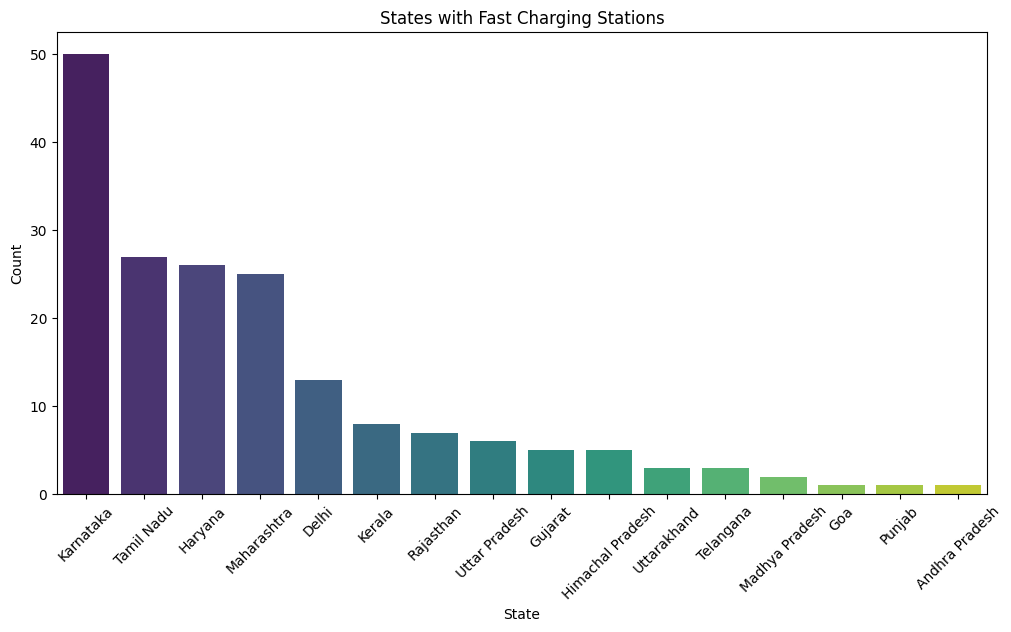

In [136]:
# States with fast charging stations
fast_charging_states = station_df[station_df['type'] == 'fast']['state'].value_counts()

#Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=fast_charging_states.index, y=fast_charging_states.values, palette='viridis')
plt.title('States with Fast Charging Stations')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

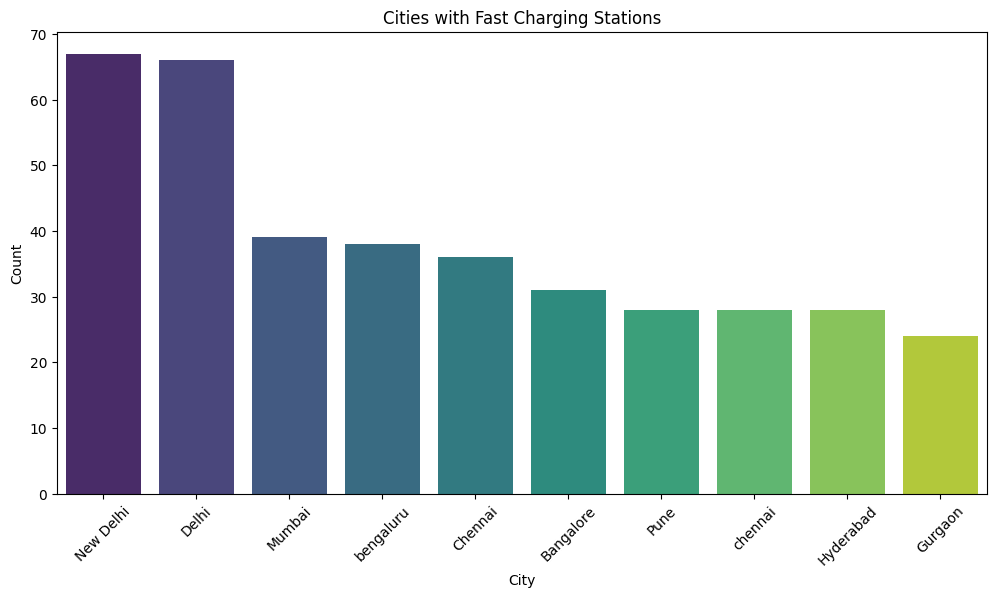

In [137]:
# Plot cities with fast charging stations
fast_charging_cities = station_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Plot
plt.figure(figsize=(12, 6))
# Pass the DataFrame to data and use column names for x and y
sns.barplot(data=fast_charging_cities, x='city', y='count', palette='viridis')
plt.title('Cities with Fast Charging Stations')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [138]:
wrong_city_name = {
    "Delhi": "New Delhi",
    "Bengaluru": "Bangalore",
    "chennai": "Chennai"
}

station_df["city"] = station_df["city"].str.strip().str.title()
station_df["city"] = station_df["city"].replace(wrong_city_name)

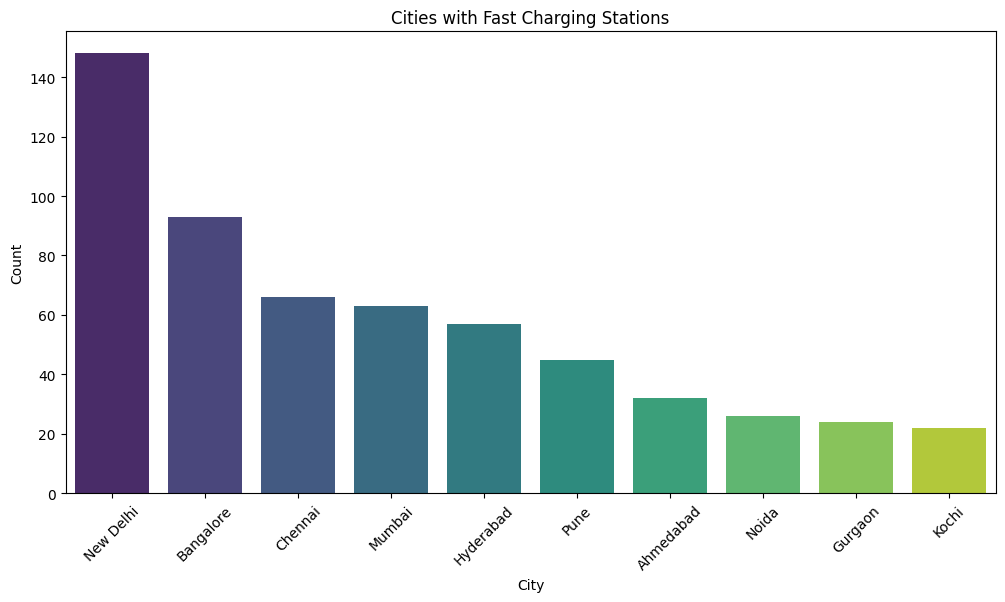

In [139]:
# Plot cities with fast charging stations
fast_charging_cities = station_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Plot
plt.figure(figsize=(12, 6))
# Pass the DataFrame to data and use column names for x and y
sns.barplot(data=fast_charging_cities, x='city', y='count', palette='viridis')
plt.title('Cities with Fast Charging Stations')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

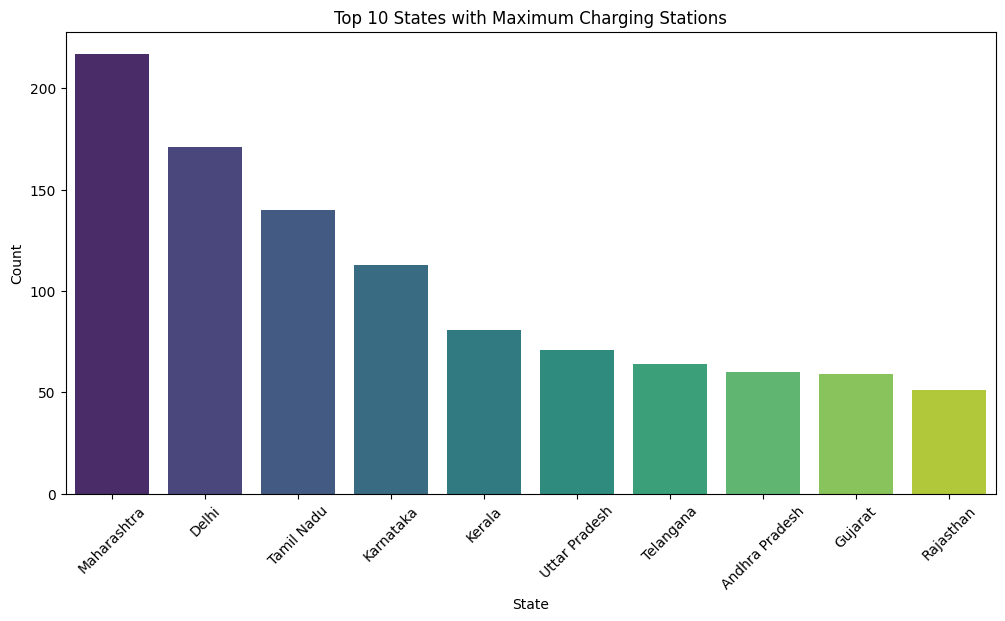

In [140]:
# Plot top 10 states with maximum charging stations
top_states = station_df['state'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_states.index, y=top_states.values, palette='viridis')
plt.title('Top 10 States with Maximum Charging Stations')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The plot shows the distribution of charging stations in India by state. The state with the most number of charging stations is Maharashtra, followed by Delhi and Tamil Nadu.

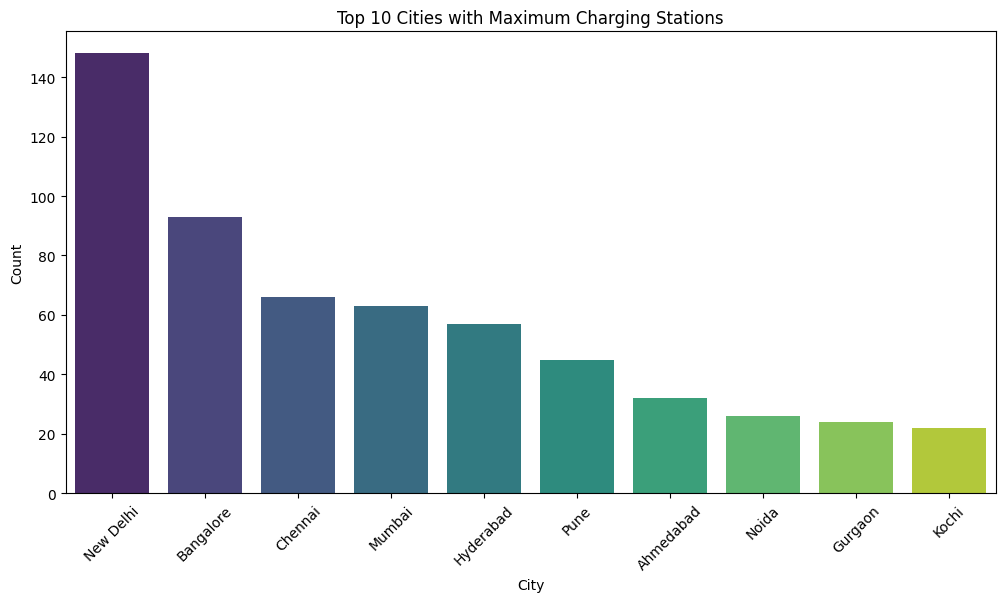

In [141]:
# Plot top 10 cities with maximum charging stations
top_cities = station_df['city'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.title('Top 10 Cities with Maximum Charging Stations')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

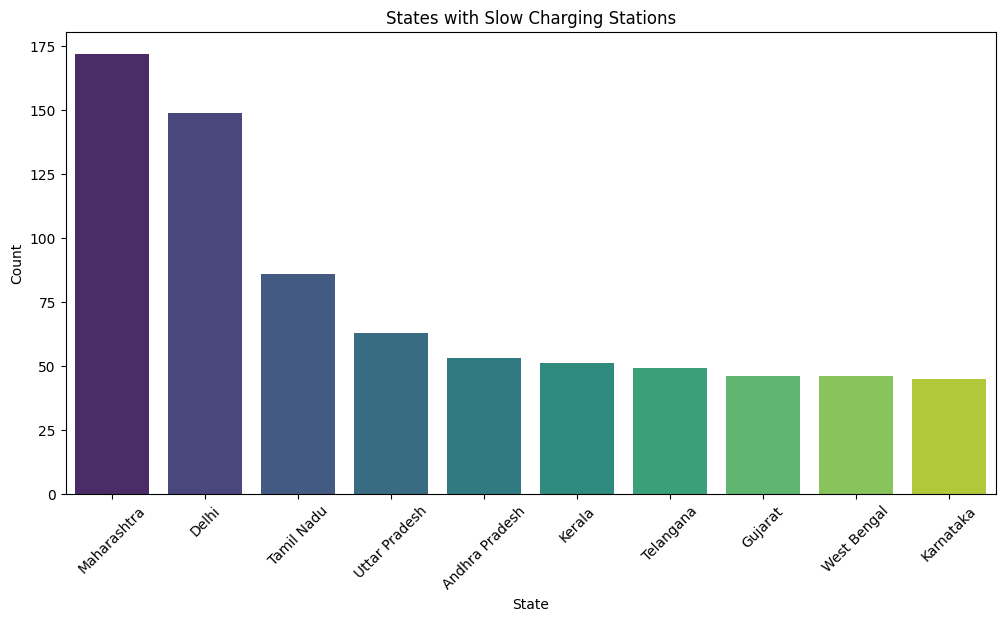

In [142]:
# States with slow charging stations
slow_charging_states = station_df[station_df['type'] == 'slow']['state'].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Plot
plt.figure(figsize=(12, 6))
# Use the 'data' argument and specify column names for x and y
sns.barplot(data=slow_charging_states, x='state', y='count', palette='viridis')
plt.title('States with Slow Charging Stations')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

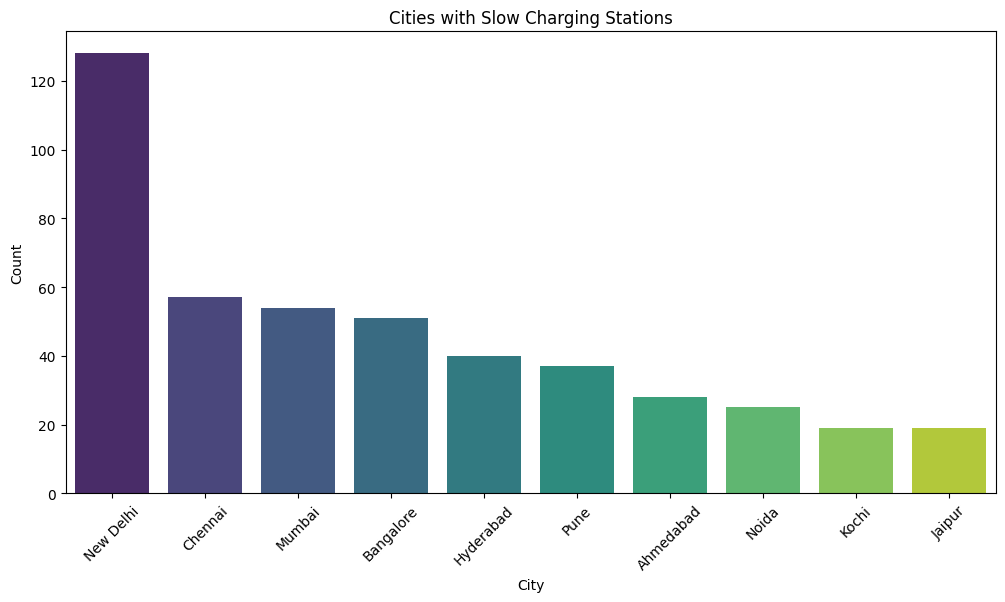

In [143]:
# Plot top 10 cities with slow charging stations
slow_charging_cities = station_df[station_df['type'] == 'slow']['city'].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

plt.figure(figsize=(12, 6))
sns.barplot(data=slow_charging_cities, x='city', y='count', palette='viridis')
plt.title('Cities with Slow Charging Stations')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **Blast Dataset (Battery Health) (Synthetic Kaggle Dataset)**

In [144]:
blast_df = pd.read_csv('/content/ev_blast_dataset (2).csv')
blast_df.head()

Battery_Type  Poor_Cell_Design External_Abuse  Poor_Battery_Design  \
0    Lead-Acid                 1            Yes                    1   
1  Lithium-Ion                 0             No                    1   
2    Lead-Acid                 0             No                    1   
3    Lead-Acid                 0             No                    1   
4    Lead-Acid                 0             No                    0   

   Short_Circuits  Temperature Overcharge_Overdischarge Battery_Maintenance  \
0               1    44.825568                   Normal                  No   
1               0    42.935834               Overcharge                 Yes   
2               0    37.205869                   Normal                 Yes   
3               0    48.681414                   Normal                 Yes   
4               1    26.014235               Overcharge                  No   

  Battery_Health  
0          Blast  
1           Good  
2       Moderate  
3       Moderate  
4          Blast

In [145]:
blast_df.isnull().sum()

Battery_Type                 0
Poor_Cell_Design             0
External_Abuse               0
Poor_Battery_Design          0
Short_Circuits               0
Temperature                  0
Overcharge_Overdischarge     0
Battery_Maintenance          0
Battery_Health              81
dtype: int64

In [146]:
blast_df.shape

(1000, 9)

In [147]:
# Separate numerical and categorical columns
numerical_cols = blast_df.select_dtypes(include=np.number).columns
categorical_cols = blast_df.select_dtypes(exclude=np.number).columns

# Fill missing values in numerical columns with the median of each column
blast_df[numerical_cols] = blast_df[numerical_cols].fillna(blast_df[numerical_cols].median())

# Fill missing values in categorical columns with the mode of each column
# We use .iloc[0] as mode can return multiple values if there's a tie
for col in categorical_cols:
    mode_value = blast_df[col].mode()
    if not mode_value.empty:
        blast_df[col].fillna(mode_value.iloc[0], inplace=True)
    else:
        # Handle columns where all values are NaN (mode() would be empty)
        # For now, we'll print a warning and leave them NaN or fill with a placeholder
        print(f"Warning: Column '{col}' has no mode (possibly all NaN). Consider a different strategy.")
        # blast_df[col].fillna('Unknown', inplace=True) # Uncomment to fill with 'Unknown'

# Verify that there are no more missing values
print(blast_df.isnull().sum())

Battery_Type                0
Poor_Cell_Design            0
External_Abuse              0
Poor_Battery_Design         0
Short_Circuits              0
Temperature                 0
Overcharge_Overdischarge    0
Battery_Maintenance         0
Battery_Health              0
dtype: int64


In [148]:
blast_df.isnull().sum()

Battery_Type                0
Poor_Cell_Design            0
External_Abuse              0
Poor_Battery_Design         0
Short_Circuits              0
Temperature                 0
Overcharge_Overdischarge    0
Battery_Maintenance         0
Battery_Health              0
dtype: int64

In [149]:
blast_df.shape

(1000, 9)

In [150]:
blast_df.columns

Index(['Battery_Type', 'Poor_Cell_Design', 'External_Abuse',
       'Poor_Battery_Design', 'Short_Circuits', 'Temperature',
       'Overcharge_Overdischarge', 'Battery_Maintenance', 'Battery_Health'],
      dtype='object')

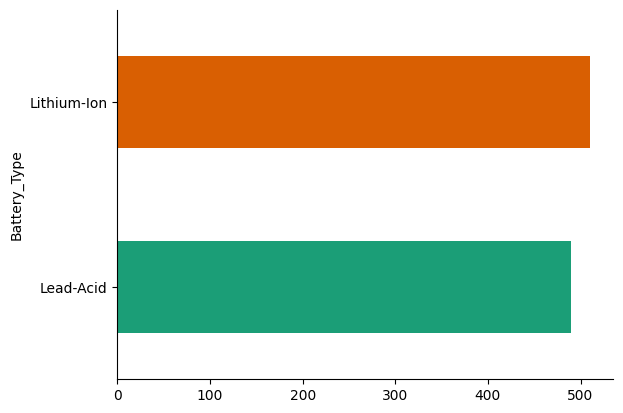

In [151]:
blast_df.groupby('Battery_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

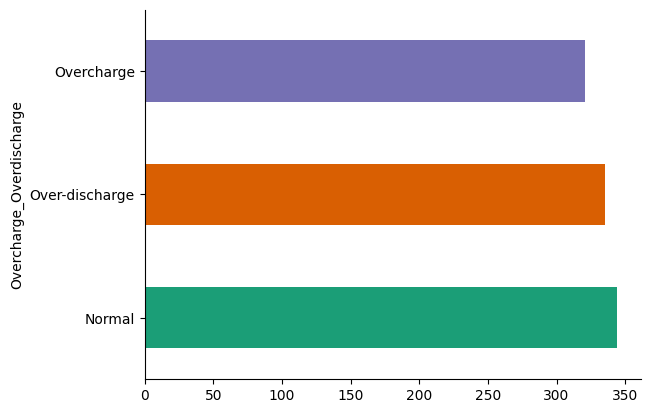

In [152]:
blast_df.groupby('Overcharge_Overdischarge').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

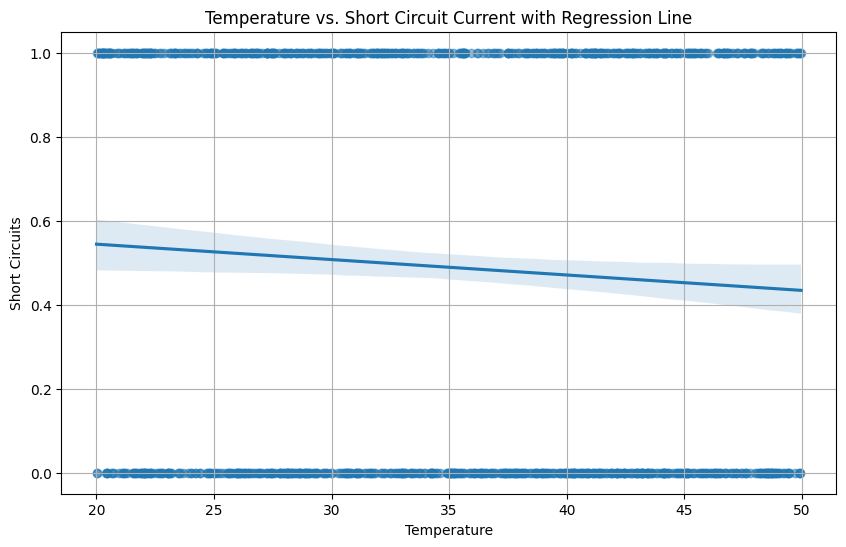

In [153]:
# Plot temperature vs short circuits
plt.figure(figsize=(10, 6))
sns.regplot(data=blast_df, x='Temperature', y='Short_Circuits', scatter_kws={'alpha':0.5})
plt.title('Temperature vs. Short Circuit Current with Regression Line')
plt.xlabel('Temperature')
plt.ylabel('Short Circuits')
plt.grid(True)
plt.show()

There is no relationship between temperature and short circuits

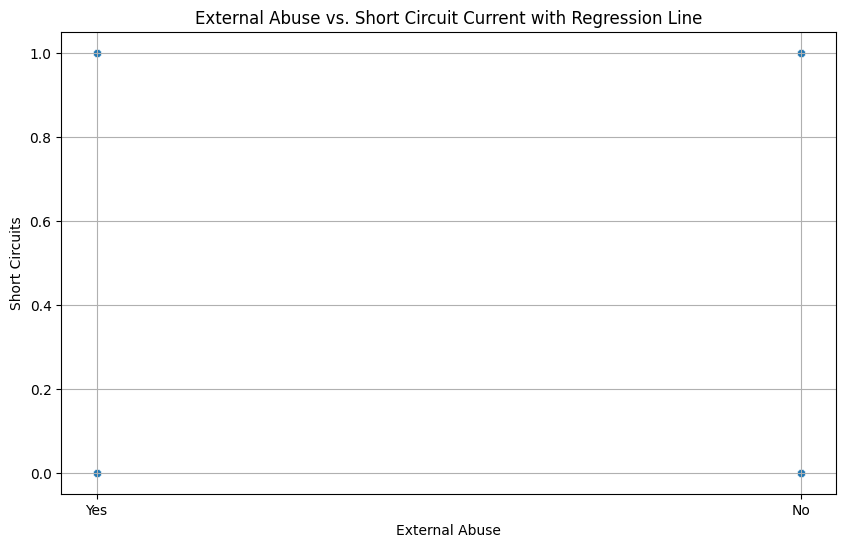

In [154]:
# Plot External_Abuse vs Short_Circuits
plt.figure(figsize=(10, 6))
sns.scatterplot(data=blast_df, x='External_Abuse', y='Short_Circuits')
plt.title('External Abuse vs. Short Circuit Current with Regression Line')
plt.xlabel('External Abuse')
plt.ylabel('Short Circuits')
plt.grid(True)
plt.show()

There is no relationship between external abuse and short circuits

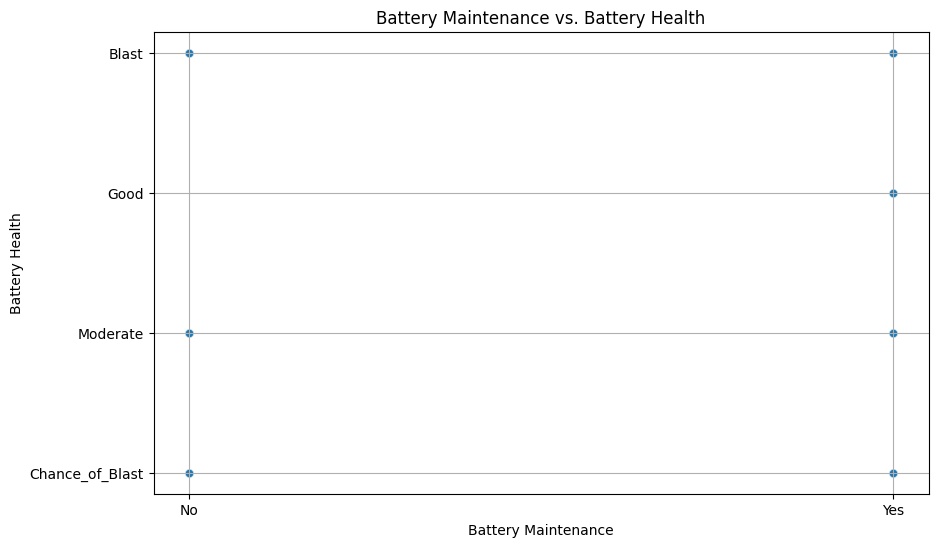

In [155]:
# prompt: plot battery maintenance vs battery health

plt.figure(figsize=(10, 6))
sns.scatterplot(data=blast_df, x='Battery_Maintenance', y='Battery_Health', alpha=0.6)
plt.title('Battery Maintenance vs. Battery Health')
plt.xlabel('Battery Maintenance')
plt.ylabel('Battery Health')
plt.grid(True)
plt.show()

No relationship

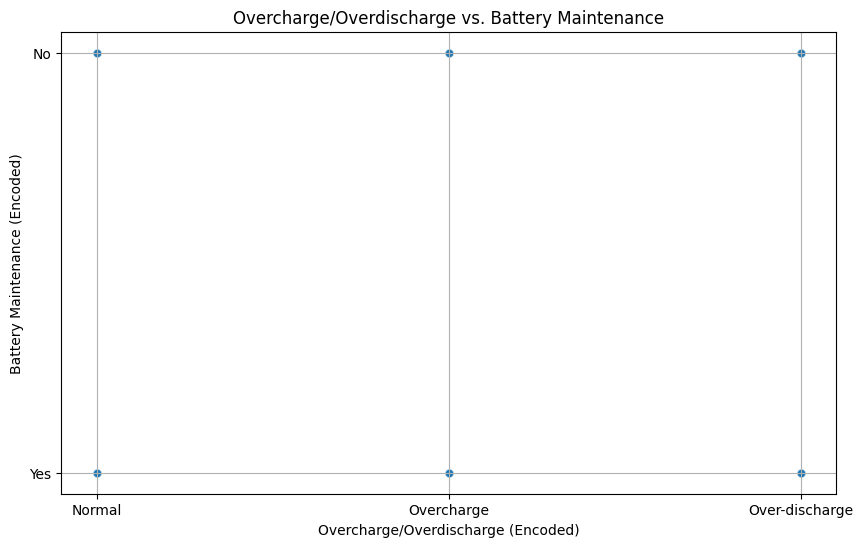

In [156]:
# plot over charge discharge vs batter maintenance

plt.figure(figsize=(10, 6))
sns.scatterplot(data=blast_df, x='Overcharge_Overdischarge', y='Battery_Maintenance', alpha=0.6)
plt.title('Overcharge/Overdischarge vs. Battery Maintenance')
plt.xlabel('Overcharge/Overdischarge (Encoded)')
plt.ylabel('Battery Maintenance (Encoded)')
plt.grid(True)
plt.show()

In [157]:
blast_df.columns

Index(['Battery_Type', 'Poor_Cell_Design', 'External_Abuse',
       'Poor_Battery_Design', 'Short_Circuits', 'Temperature',
       'Overcharge_Overdischarge', 'Battery_Maintenance', 'Battery_Health'],
      dtype='object')

Text(0, 0.5, 'Count')

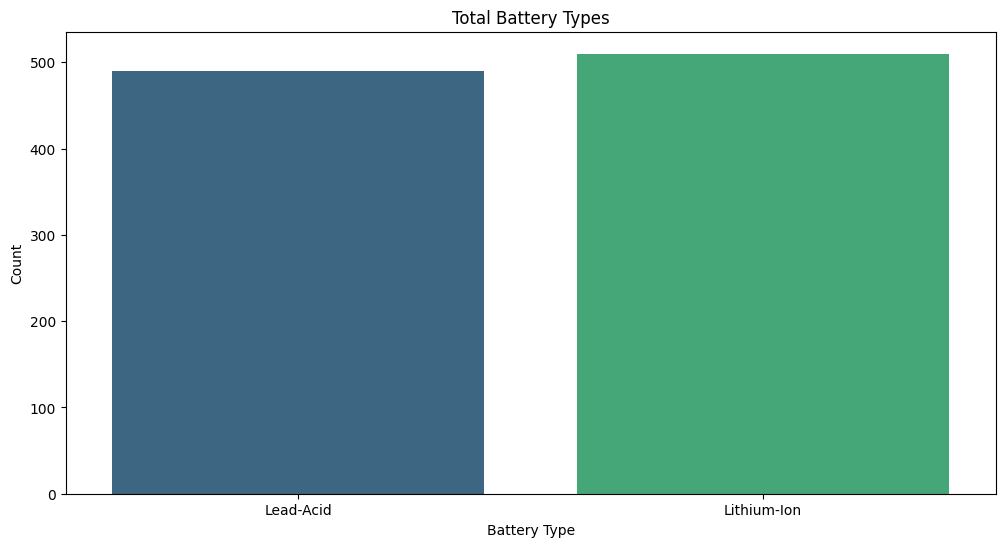

In [158]:
# Plot total battery types
plt.figure(figsize=(12, 6))
sns.countplot(data=blast_df, x='Battery_Type', palette='viridis')
plt.title('Total Battery Types')
plt.xlabel('Battery Type')
plt.ylabel('Count')

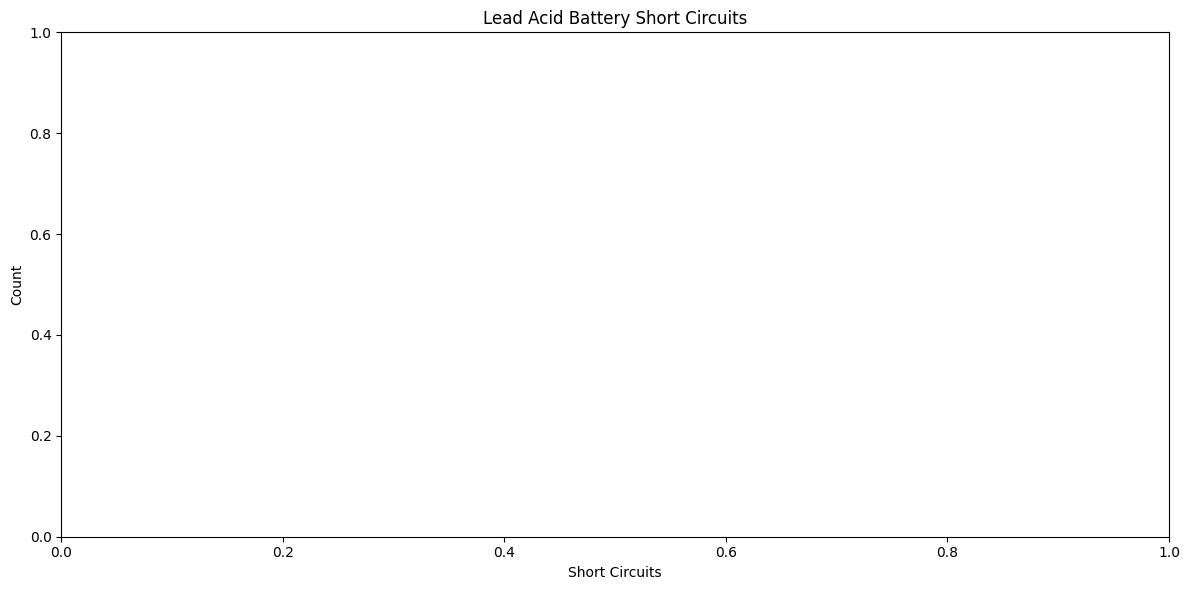

In [159]:
# Plot if lead_acid battery type has lot of short circuits
lead_acid_df = blast_df[blast_df['Battery_Type'] == 'Lead Acid']
plt.figure(figsize=(12, 6))
sns.countplot(data=lead_acid_df, x='Short_Circuits', palette='viridis')
plt.title('Lead Acid Battery Short Circuits')
plt.xlabel('Short Circuits')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

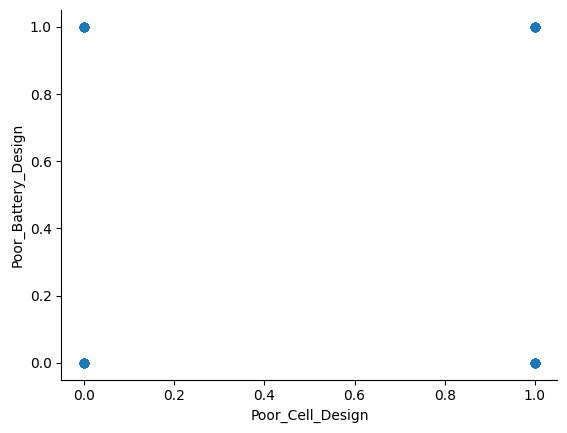

In [160]:
blast_df.plot(kind='scatter', x='Poor_Cell_Design', y='Poor_Battery_Design', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Battery_Health
Chance_of_Blast    351
Moderate           264
Blast              219
Good               166
Name: count, dtype: int64


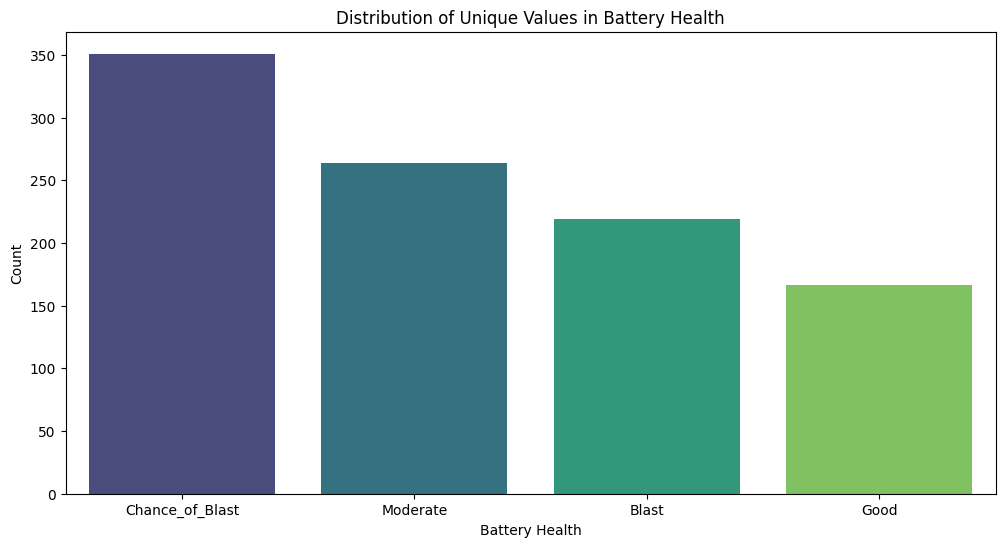

In [161]:
# Distribution of unique vales in battery health
battery_health_distribution = blast_df['Battery_Health'].value_counts()
print(battery_health_distribution)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=battery_health_distribution.index, y=battery_health_distribution.values, palette='viridis')
plt.title('Distribution of Unique Values in Battery Health')
plt.xlabel('Battery Health')
plt.ylabel('Count')
plt.show()

Overcharge_Overdischarge
Normal            344
Over-discharge    335
Overcharge        321
Name: count, dtype: int64


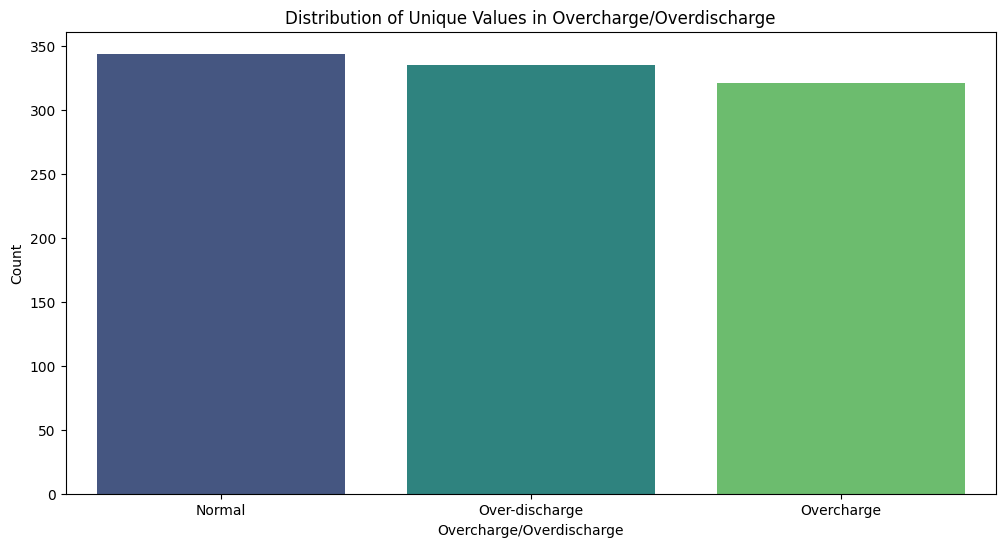

In [162]:
# Distribution of unique values in overcharge_overdischarge
overcharge_overdischarge_distribution = blast_df['Overcharge_Overdischarge'].value_counts()
print(overcharge_overdischarge_distribution)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=overcharge_overdischarge_distribution.index, y=overcharge_overdischarge_distribution.values, palette='viridis')
plt.title('Distribution of Unique Values in Overcharge/Overdischarge')
plt.xlabel('Overcharge/Overdischarge')
plt.ylabel('Count')
plt.show()

Battery_Maintenance
Yes    522
No     478
Name: count, dtype: int64


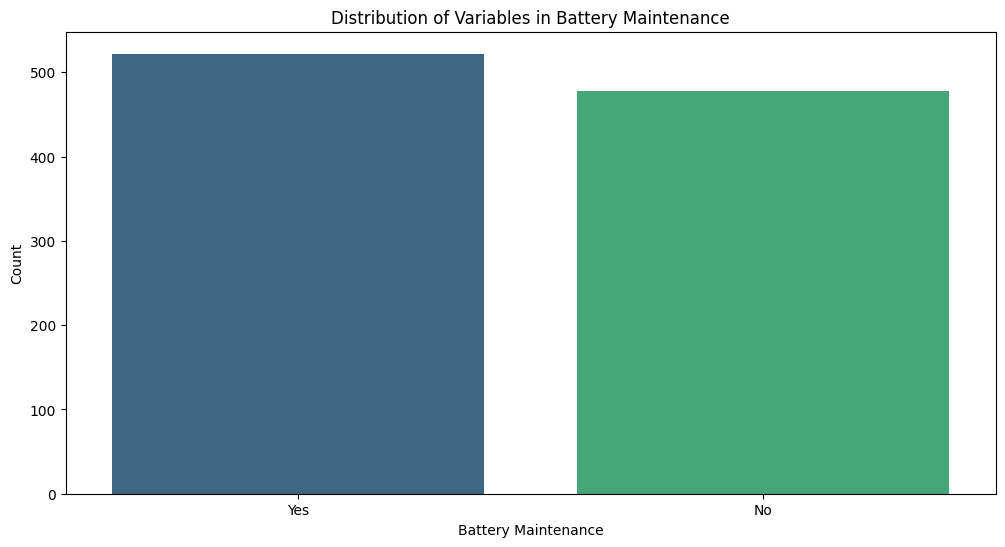

In [163]:
# Distribution of variables in battery maintenance
battery_maintenance_distribution = blast_df['Battery_Maintenance'].value_counts()
print(battery_maintenance_distribution)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=battery_maintenance_distribution.index, y=battery_maintenance_distribution.values, palette='viridis')
plt.title('Distribution of Variables in Battery Maintenance')
plt.xlabel('Battery Maintenance')
plt.ylabel('Count')
plt.show()

# **Electronic Vehicles Specs**

In [164]:
specs_df = pd.read_csv('/content/ElectricCarData_Clean.csv')
specs_df.head()

Brand                          Model  AccelSec  TopSpeed_KmH  \
0       Tesla   Model 3 Long Range Dual Motor       4.6           233   
1  Volkswagen                       ID.3 Pure      10.0           160   
2    Polestar                               2       4.7           210   
3         BMW                            iX3        6.8           180   
4       Honda                              e        9.5           145   

   Range_Km  Efficiency_WhKm FastCharge_KmH RapidCharge PowerTrain  \
0       450              161            940         Yes        AWD   
1       270              167            250         Yes        RWD   
2       400              181            620         Yes        AWD   
3       360              206            560         Yes        RWD   
4       170              168            190         Yes        RWD   

     PlugType  BodyStyle Segment  Seats  PriceEuro  
0  Type 2 CCS      Sedan       D      5      55480  
1  Type 2 CCS  Hatchback       C      5      30000  
2  Type 2 CCS   Liftback       D      5      56440  
3  Type 2 CCS        SUV       D      5      68040  
4  Type 2 CCS  Hatchback       B      4      32997

In [165]:
specs_df.shape

(103, 14)

In [166]:
specs_df.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
dtype: int64

In [167]:
specs_df.describe()

AccelSec  TopSpeed_KmH    Range_Km  Efficiency_WhKm       Seats  \
count  103.000000    103.000000  103.000000       103.000000  103.000000   
mean     7.396117    179.194175  338.786408       189.165049    4.883495   
std      3.017430     43.573030  126.014444        29.566839    0.795834   
min      2.100000    123.000000   95.000000       104.000000    2.000000   
25%      5.100000    150.000000  250.000000       168.000000    5.000000   
50%      7.300000    160.000000  340.000000       180.000000    5.000000   
75%      9.000000    200.000000  400.000000       203.000000    5.000000   
max     22.400000    410.000000  970.000000       273.000000    7.000000   

           PriceEuro  
count     103.000000  
mean    55811.563107  
std     34134.665280  
min     20129.000000  
25%     34429.500000  
50%     45000.000000  
75%     65000.000000  
max    215000.000000

In [168]:
# Check outliers only for numerical columns
numerical_cols_specs = specs_df.select_dtypes(include=np.number).columns.tolist()

# Replace outliers with the median for each numerical column
for col in numerical_cols_specs:
    Q1 = specs_df[col].quantile(0.25)
    Q3 = specs_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate the median for the current column
    median_value = specs_df[col].median()

    # Identify outliers in the current column
    outliers_in_col = specs_df[(specs_df[col] < lower_bound) | (specs_df[col] > upper_bound)]

    # # Count the number of rows identified as outliers (where outliers is True)
    # num_outliers = outliers_in_col.sum()

    # # Print the number of outliers
    # print(f"Number of rows with outliers: {num_outliers}")

    # Replace outliers in the current column with the median value
    # Use the index of the identified outliers to perform the replacement
    specs_df.loc[outliers_in_col.index, col] = median_value

print("Outliers in numerical columns replaced with median.")
# You can now inspect the specs_df to see the changes, or re-run outlier checks
# print(specs_df[numerical_cols_specs].describe())

Outliers in numerical columns replaced with median.


In [169]:
# Convert categorical columns to integer
for col in specs_df.columns:
  specs_df[col]=specs_df[col].astype('category')
specs_df.dtypes

Brand              category
Model              category
AccelSec           category
TopSpeed_KmH       category
Range_Km           category
Efficiency_WhKm    category
FastCharge_KmH     category
RapidCharge        category
PowerTrain         category
PlugType           category
BodyStyle          category
Segment            category
Seats              category
PriceEuro          category
dtype: object

In [170]:
for col in specs_df:
  specs_df[col] = specs_df[col].cat.codes
specs_df.head()

Brand  Model  AccelSec  TopSpeed_KmH  Range_Km  Efficiency_WhKm  \
0     30     46        11            18        42                4   
1     31     33        46             9        15                8   
2     23      0        12            15        35               20   
3      2    101        26            12        28               31   
4      9     78        41             5         4                9   

   FastCharge_KmH  RapidCharge  PowerTrain  PlugType  BodyStyle  Segment  \
0              50            1           0         2          7        3   
1               7            1           2         2          1        2   
2              36            1           0         2          2        3   
3              32            1           2         2          6        3   
4               2            1           2         2          1        1   

   Seats  PriceEuro  
0      0         52  
1      0         11  
2      0         53  
3      0         64  
4      0         16

In [171]:
specs_df1 = pd.read_csv('/content/ElectricCarData_Clean.csv')

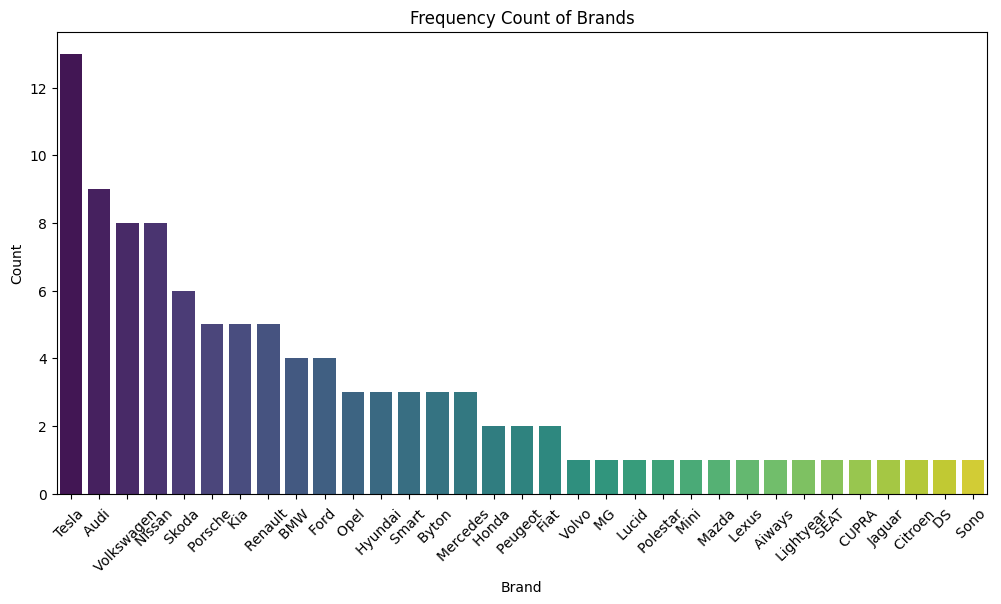

In [172]:
# Get the frequency count of each brand
brand_counts = specs_df1['Brand'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')
plt.title('Frequency Count of Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

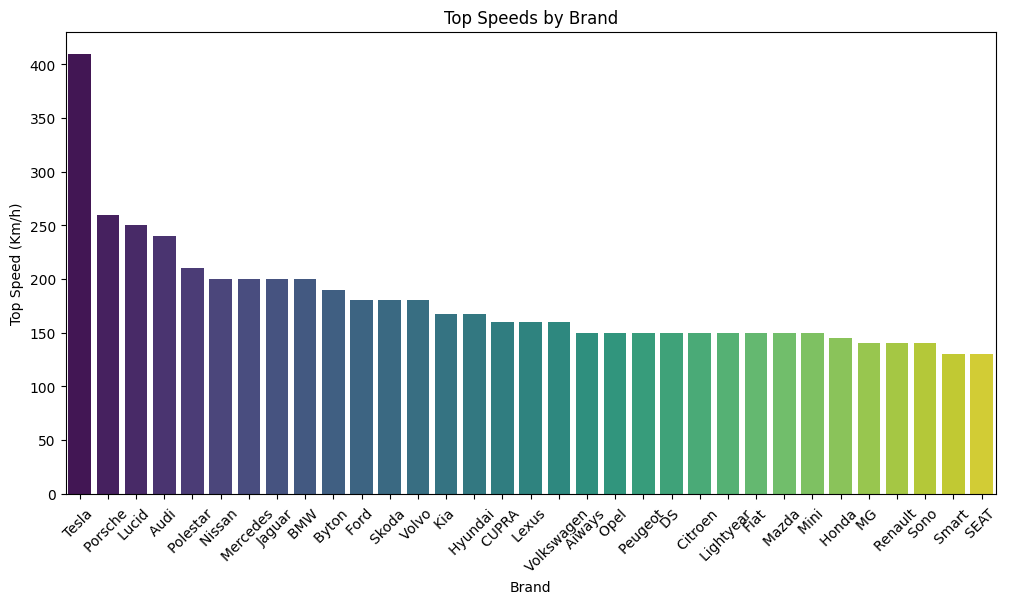

In [173]:
# Top speeds by each car brand
top_speeds = specs_df1.groupby('Brand')['TopSpeed_KmH'].max().sort_values(ascending=False)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_speeds.index, y=top_speeds.values, palette='viridis')
plt.title('Top Speeds by Brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed (Km/h)')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Plug Type')

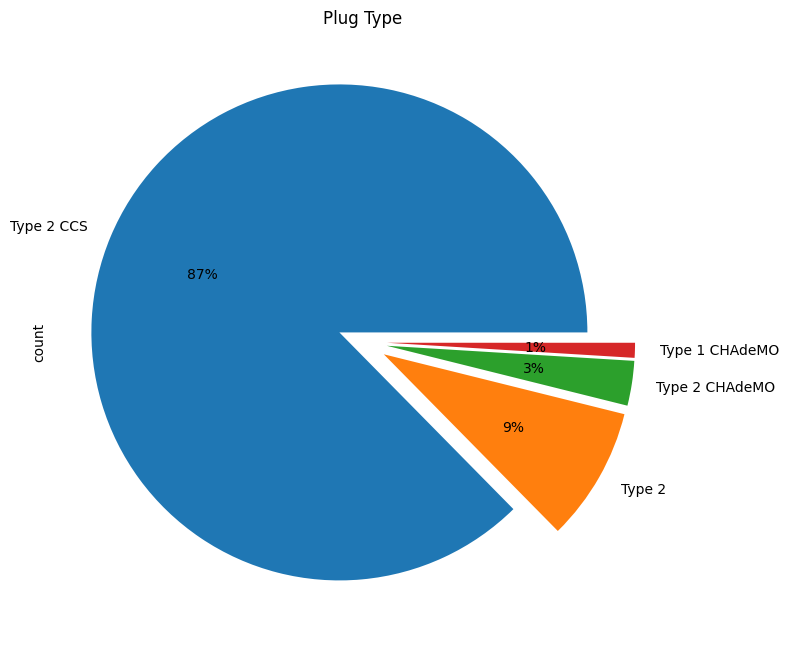

In [174]:
# Most commonly used plug type
specs_df1['PlugType'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')

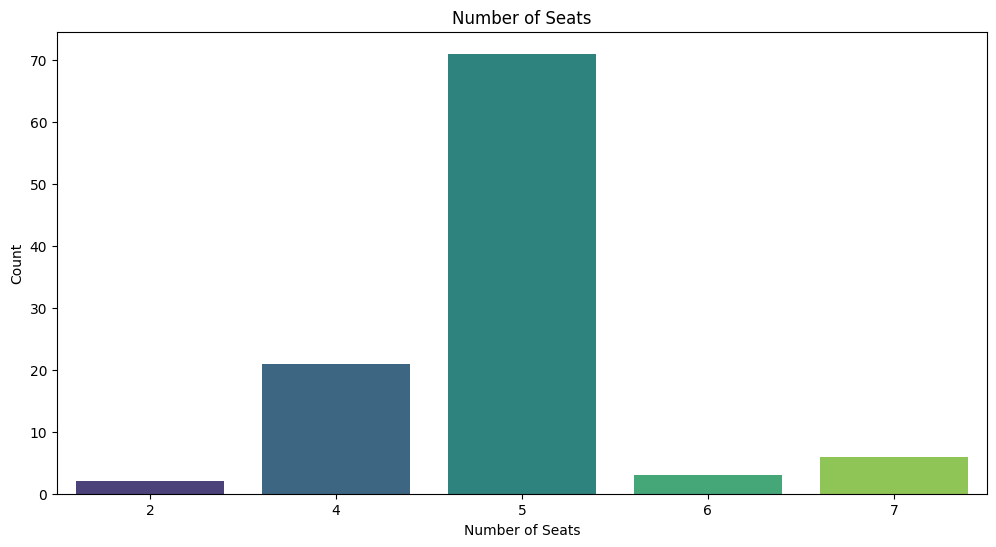

In [175]:
# Plot number of seats barplot
plt.figure(figsize=(12, 6))
sns.countplot(data=specs_df1, x='Seats', palette='viridis')
plt.title('Number of Seats')
plt.xlabel('Number of Seats')
plt.ylabel('Count')
plt.show()

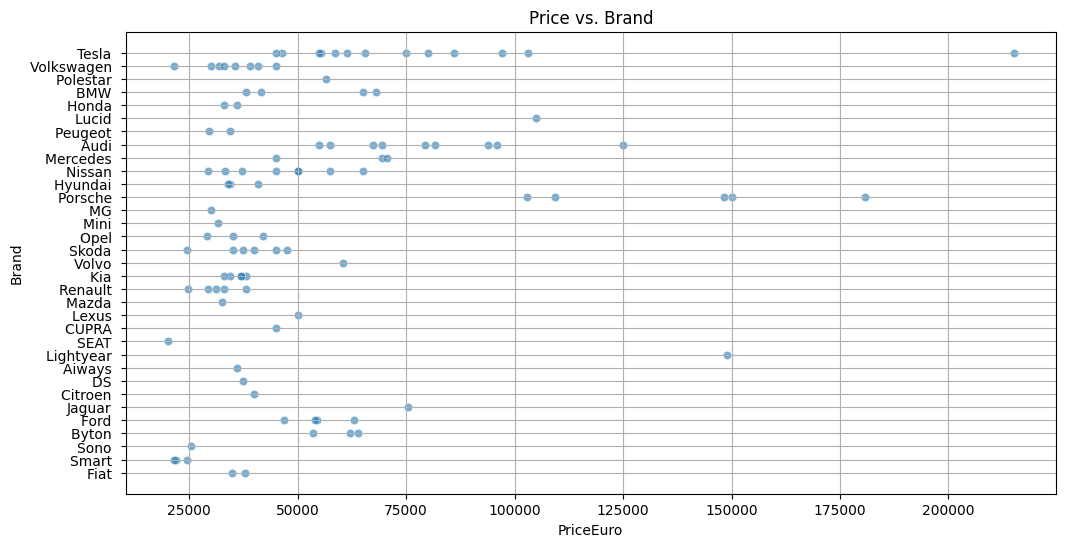

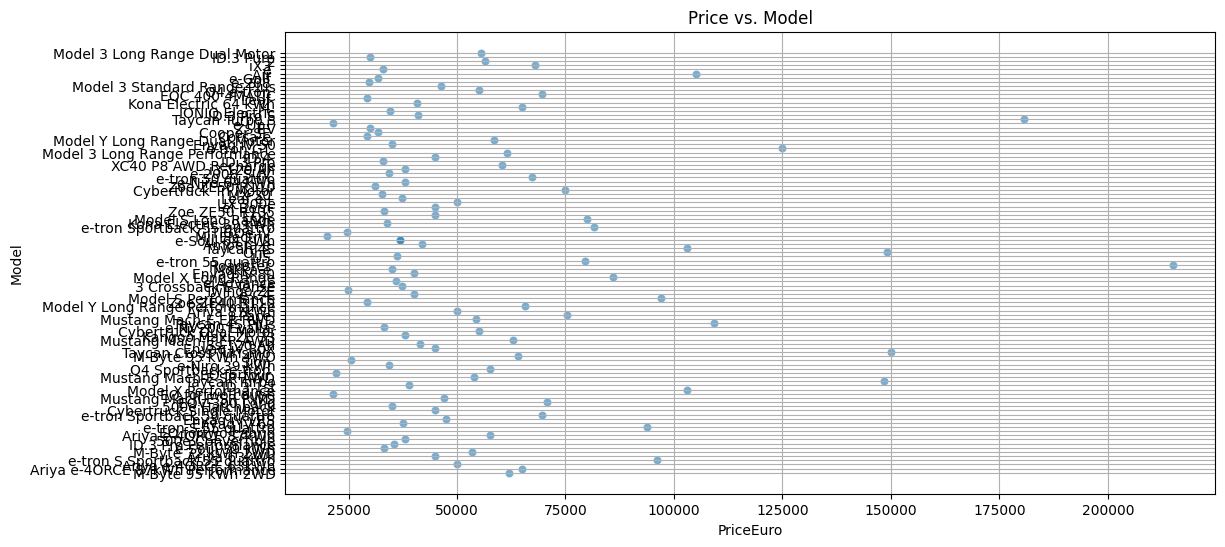

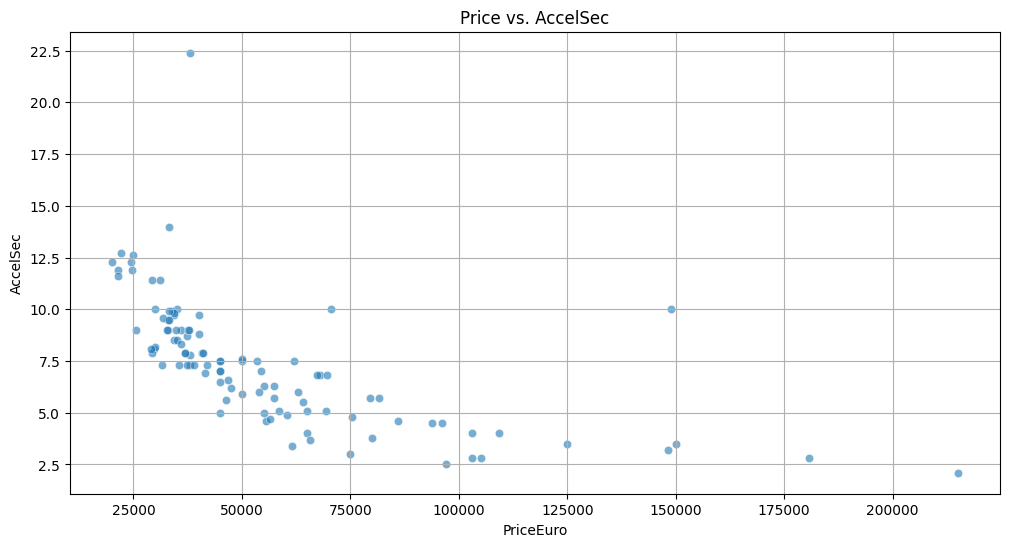

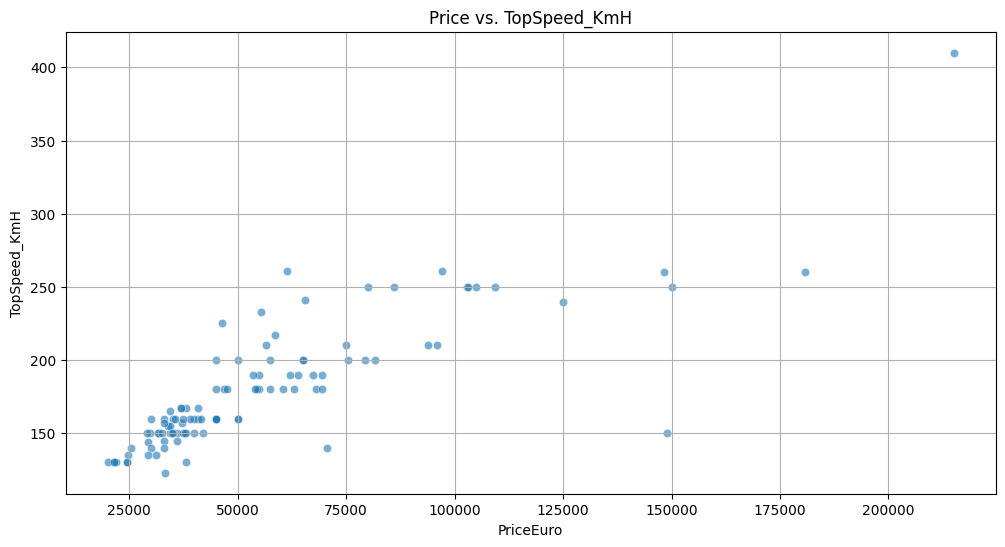

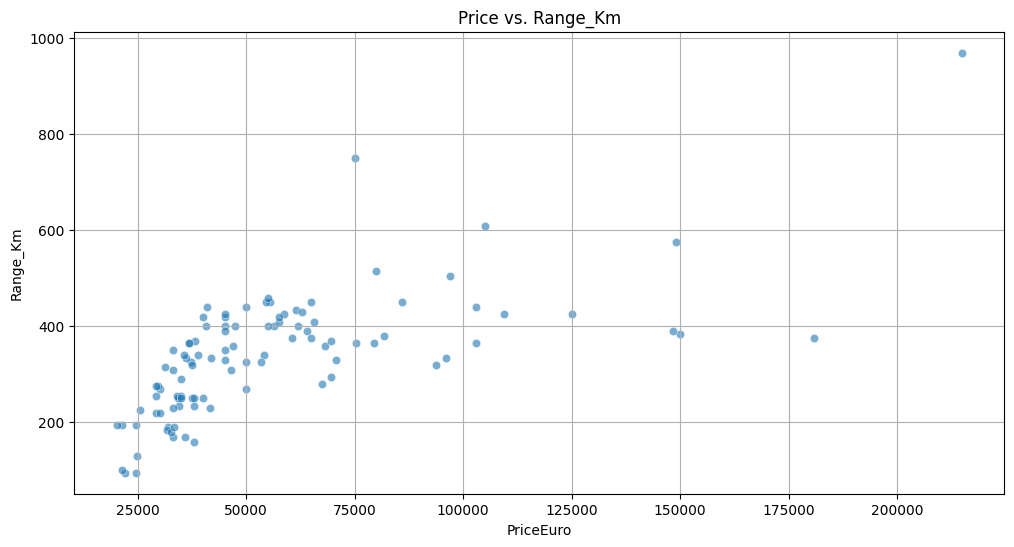

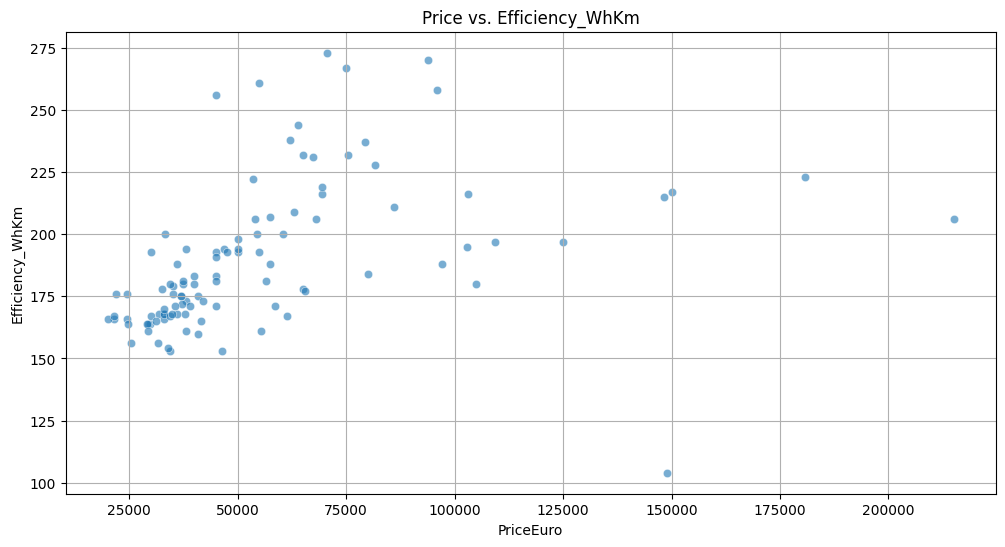

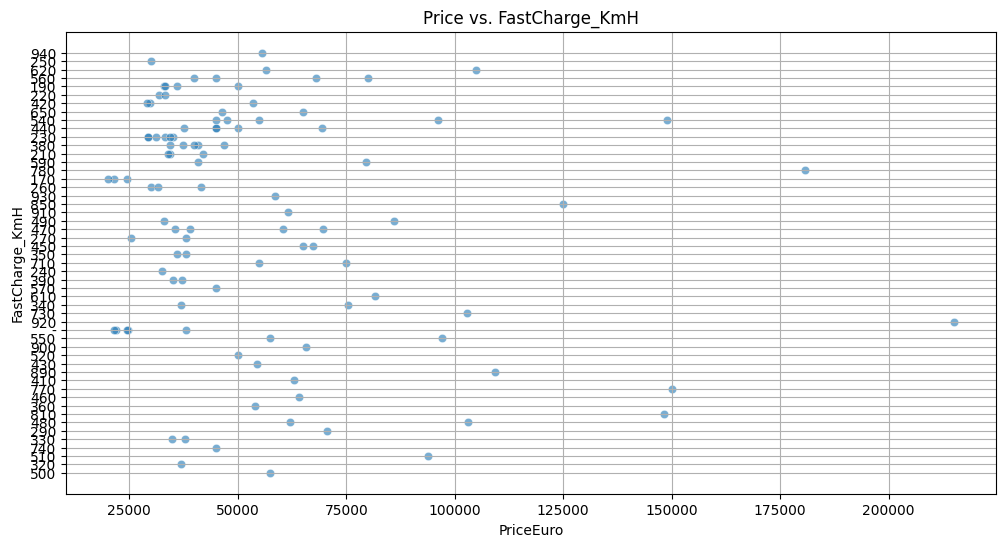

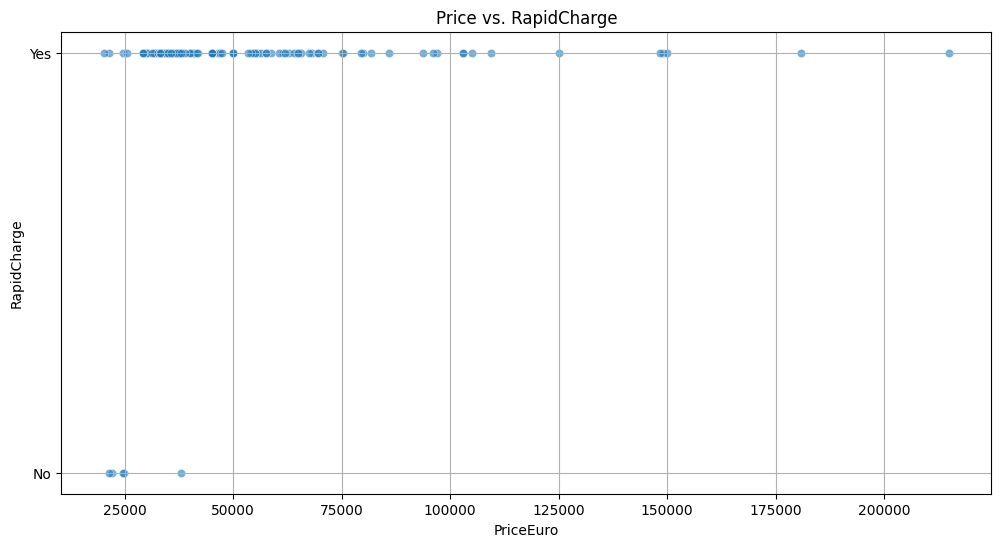

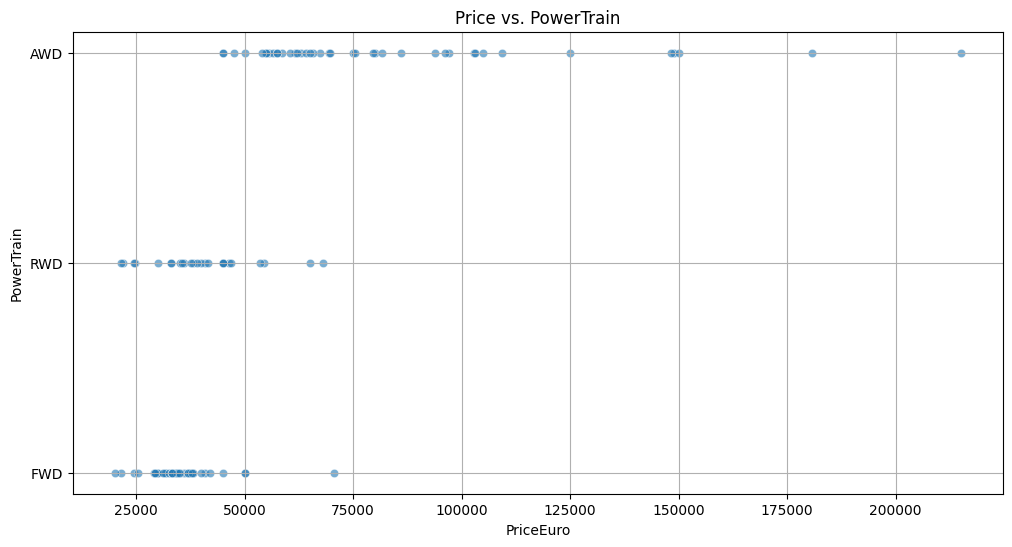

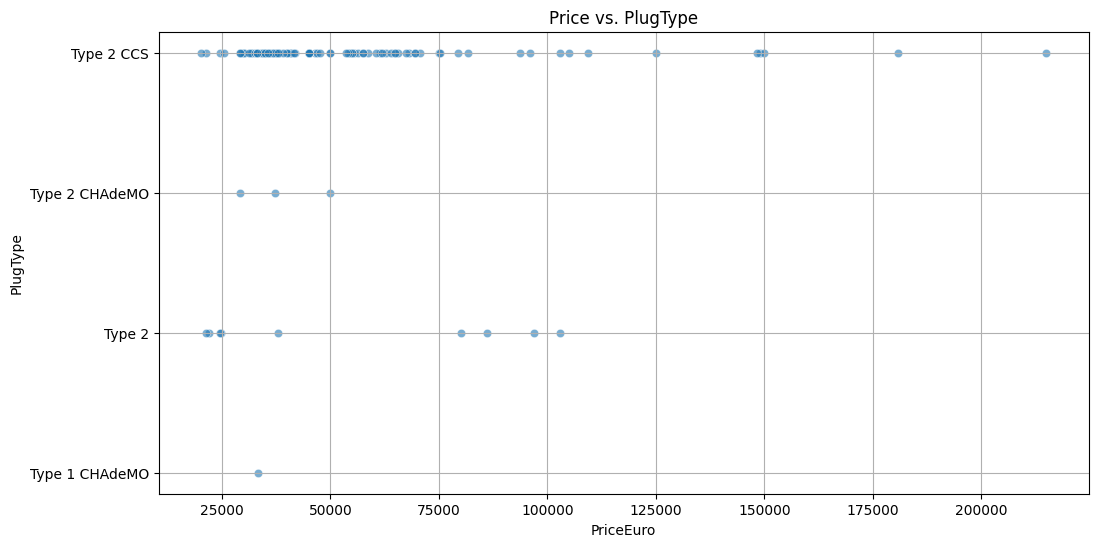

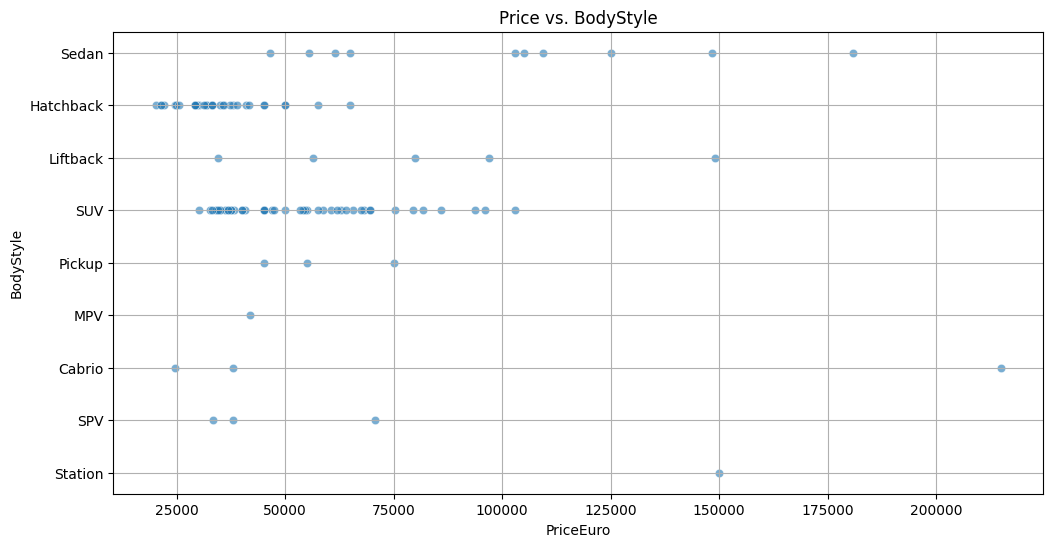

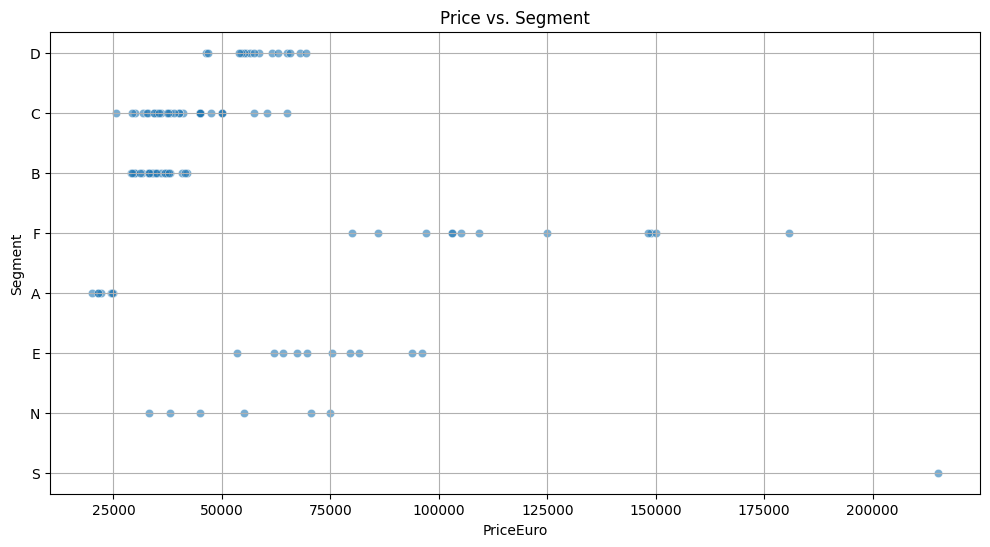

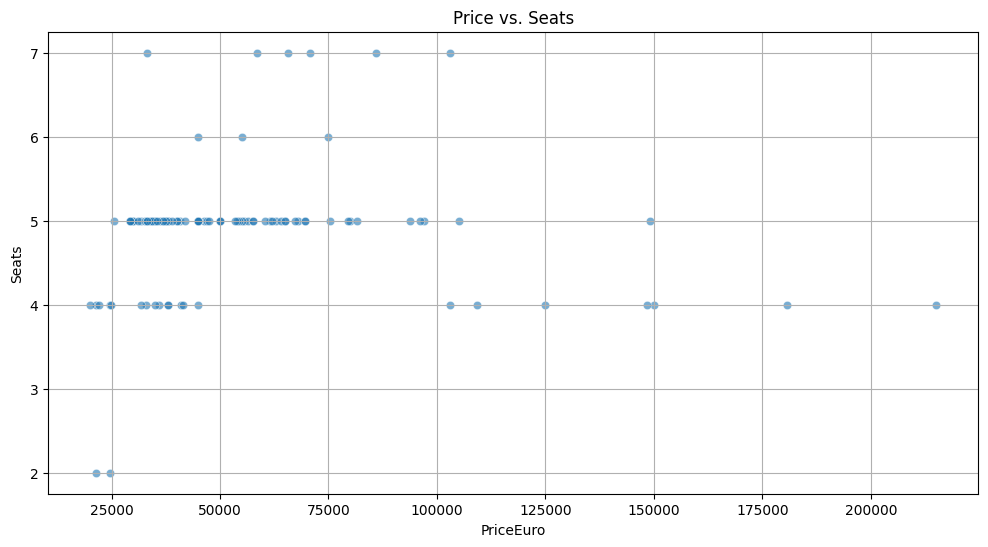

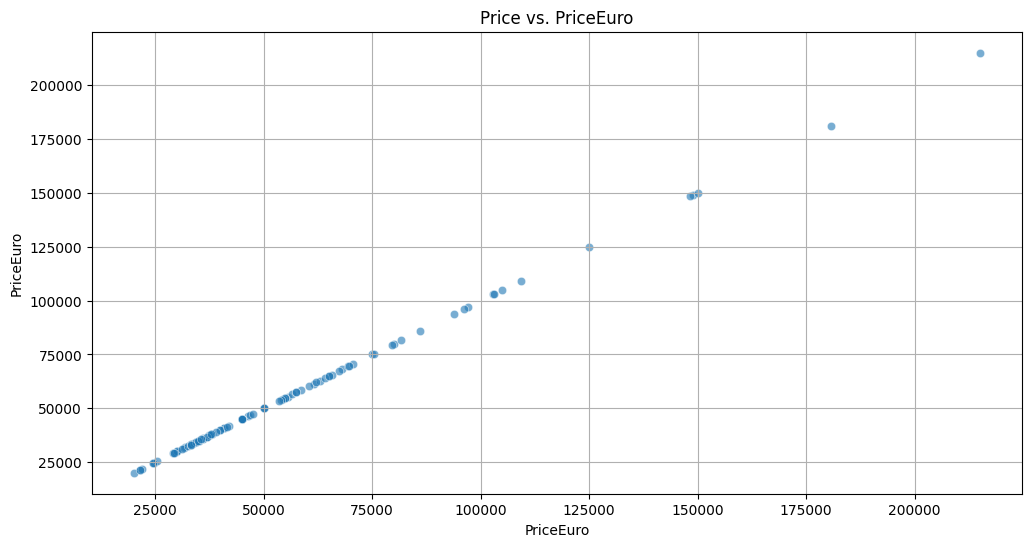

In [176]:
# Plot price vs rest of the columns
for col in specs_df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=specs_df1, x='PriceEuro', y=col, alpha=0.6)
    plt.title(f'Price vs. {col}')
    plt.xlabel('PriceEuro')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

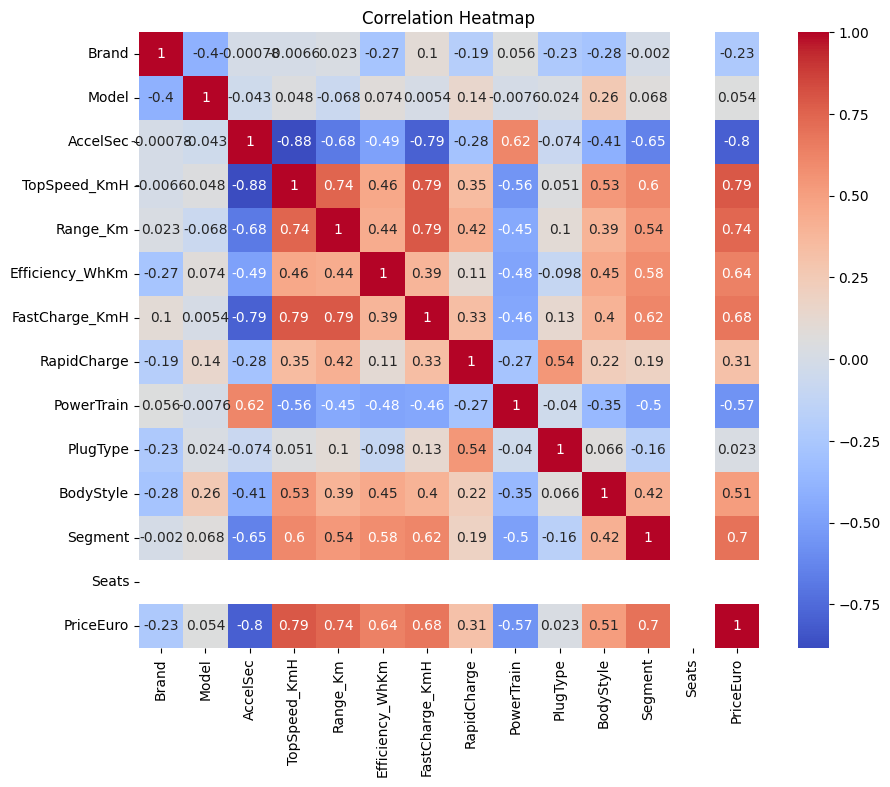

In [177]:
# Correlation and heatmap
corr = specs_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [178]:
# Find highly correlated columns

highly_correlated_cols = [(col1, col2) for col1 in corr.columns for col2 in corr.columns if col1 != col2 and abs(corr.loc[col1, col2]) > 0.65]
highly_correlated_cols

[('AccelSec', 'TopSpeed_KmH'),
 ('AccelSec', 'Range_Km'),
 ('AccelSec', 'FastCharge_KmH'),
 ('AccelSec', 'PriceEuro'),
 ('TopSpeed_KmH', 'AccelSec'),
 ('TopSpeed_KmH', 'Range_Km'),
 ('TopSpeed_KmH', 'FastCharge_KmH'),
 ('TopSpeed_KmH', 'PriceEuro'),
 ('Range_Km', 'AccelSec'),
 ('Range_Km', 'TopSpeed_KmH'),
 ('Range_Km', 'FastCharge_KmH'),
 ('Range_Km', 'PriceEuro'),
 ('FastCharge_KmH', 'AccelSec'),
 ('FastCharge_KmH', 'TopSpeed_KmH'),
 ('FastCharge_KmH', 'Range_Km'),
 ('FastCharge_KmH', 'PriceEuro'),
 ('Segment', 'PriceEuro'),
 ('PriceEuro', 'AccelSec'),
 ('PriceEuro', 'TopSpeed_KmH'),
 ('PriceEuro', 'Range_Km'),
 ('PriceEuro', 'FastCharge_KmH'),
 ('PriceEuro', 'Segment')]

In [179]:
# Separate features into numerical and categorical
numerical_features = specs_df1.select_dtypes(include=['float64', 'int64']).columns
categorical_features = specs_df1.select_dtypes(include=['object']).columns

# Exclude the 'cluster' column if it exists
if 'cluster' in numerical_features:
    numerical_features = numerical_features.drop('cluster')
if 'cluster_all_features' in numerical_features:
    numerical_features = numerical_features.drop('cluster_all_features')
# Create a column transformer for preprocessing
# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep any other columns (if any)
)

In [180]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(specs_df1)

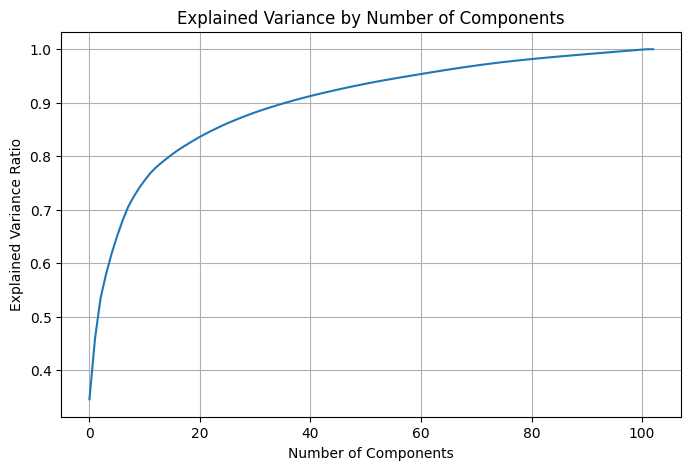


Number of components to explain 95% variance: 59


In [181]:
from sklearn.decomposition import PCA
import numpy as np

# Determine the optimal number of components (optional but recommended)
# You can look at the explained variance ratio to decide how many components to keep
pca = PCA()
pca.fit(X_processed)

# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Choose the number of components based on the explained variance plot
# For example, choose the number of components that explain 95% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\nNumber of components to explain 95% variance: {n_components}")

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_processed)

 Clustering Models

Problem: Grouping similar electric cars together based on their features to identify different segments in the electric vehicle market.
Models:
* K-Means Clustering
* DBSCAN
* Agglomerative Clustering

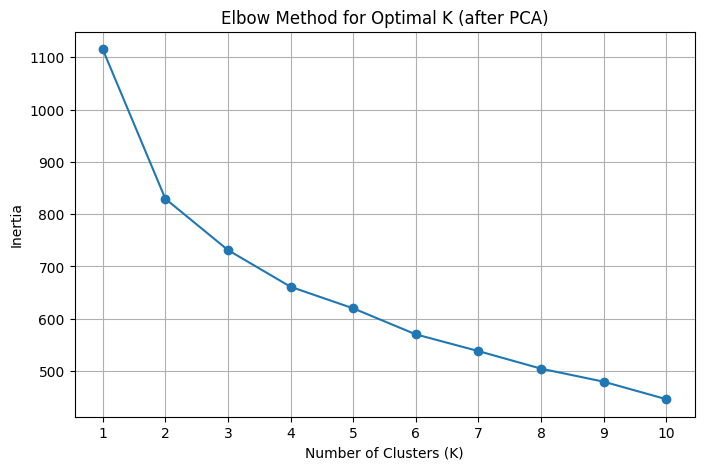

In [182]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for different numbers of clusters on PCA data
inertia_pca = []
for k in range(1, 11):
    kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_pca.fit(X_pca)
    inertia_pca.append(kmeans_pca.inertia_)

# Plot the Elbow Method graph for PCA data
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_pca, marker='o')
plt.title('Elbow Method for Optimal K (after PCA)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [183]:
# Choose the number of clusters based on the Elbow Method for PCA data
optimal_k_pca = 4

# Initialize and fit the K-Means model on PCA data
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Add the cluster labels to the original dataframe
specs_df1['cluster_pca'] = clusters_pca

In [184]:
# Analyze the characteristics of each cluster (using original features)

# Analyze numerical features by calculating the mean
cluster_numerical_analysis = specs_df1.groupby('cluster_pca')[numerical_features.tolist()].mean()
print("\nCluster Analysis (Mean of Numerical Features in PCA Clusters):")
print(cluster_numerical_analysis)

# Analyze categorical features by looking at the value counts or mode
print("\nCluster Analysis (Categorical Feature Distribution in PCA Clusters):")
for cluster_id in sorted(specs_df1['cluster_pca'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_data = specs_df1[specs_df1['cluster_pca'] == cluster_id]
    for cat_col in categorical_features:
        print(f"  {cat_col}:")
        print(cluster_data[cat_col].value_counts().head()) # Display top few categories


Cluster Analysis (Mean of Numerical Features in PCA Clusters):
              AccelSec  TopSpeed_KmH    Range_Km  Efficiency_WhKm     Seats  \
cluster_pca                                                                   
0             5.597368    198.342105  392.631579       211.921053  5.342105   
1             8.706383    153.063830  294.574468       171.361702  4.851064   
2             3.220000    268.100000  496.500000       200.200000  4.300000   
3            13.462500    130.625000  145.625000       171.875000  3.625000   

                 PriceEuro  
cluster_pca                 
0             63817.394737  
1             38582.234043  
2            131330.900000  
3             24607.000000  

Cluster Analysis (Categorical Feature Distribution in PCA Clusters):

--- Cluster 0 ---
  Brand:
Brand
Tesla        10
Audi          8
Ford          4
Nissan        3
Mercedes      3
Name: count, dtype: int64
  Model:
Model
Model 3 Long Range Dual Motor    1
2                          

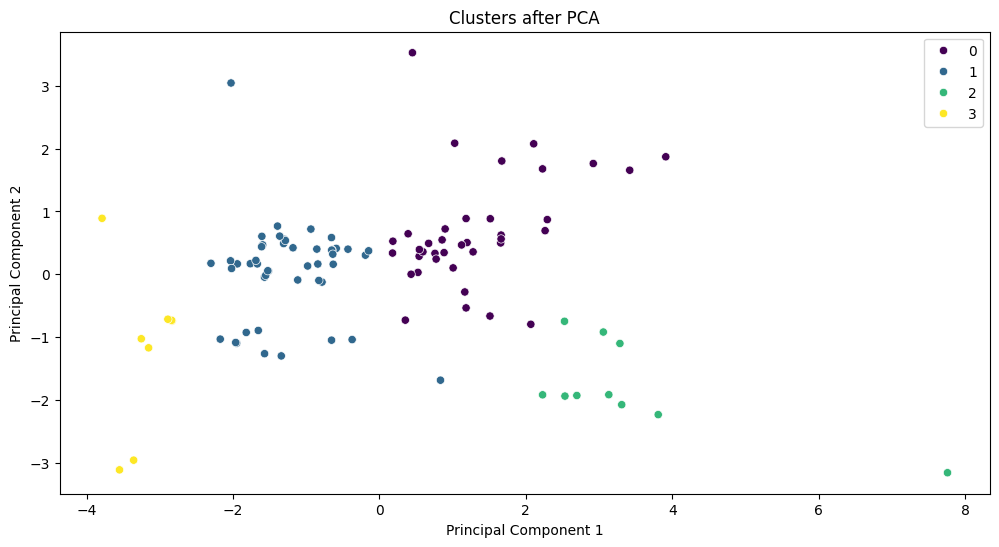

In [185]:
# Plot clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_pca, palette='viridis')
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Clustering can be done without PCA. As all the features are used, PCA is performed.

# **Basic EV Sales**

In [186]:
ev_sales = pd.read_excel('/content/Ev Sales.xlsx')
ev_sales.head()

YEAR  2 W   3 W  4 W  BUS  TOTAL
0 2017-04-01   96  4748  198    0   5042
1 2017-05-01   91  6720  215    2   7028
2 2017-06-01  137  7178  149    1   7465
3 2017-07-01  116  8775  120    0   9011
4 2017-08-01   99  8905  137    0   9141

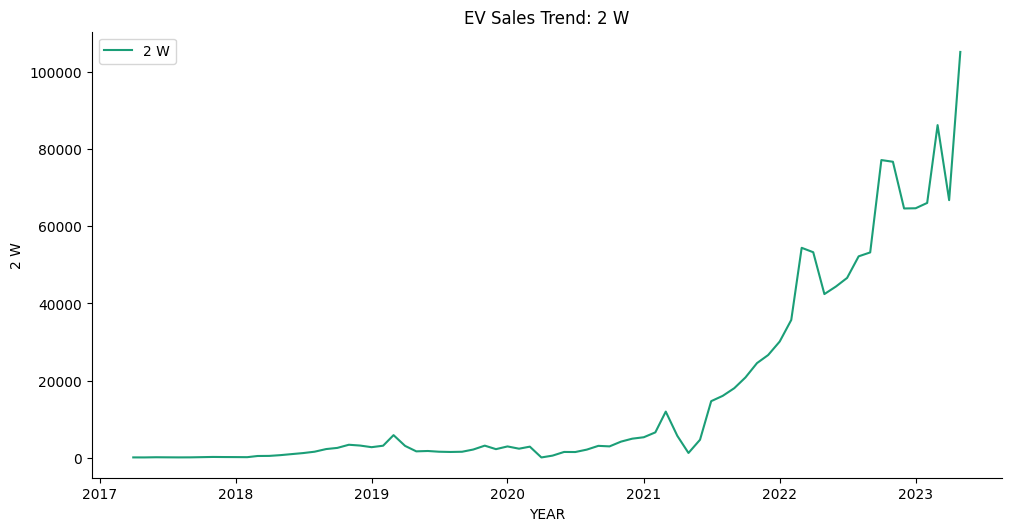

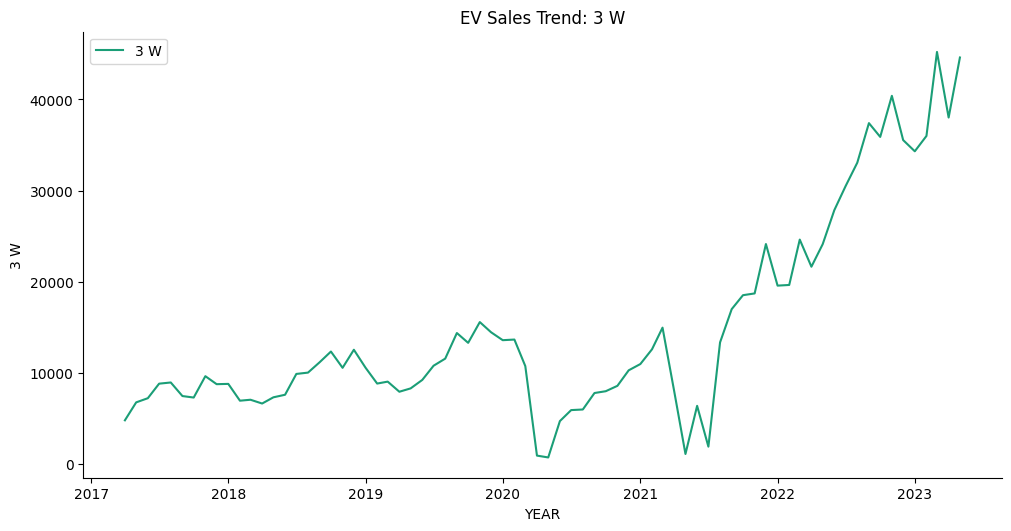

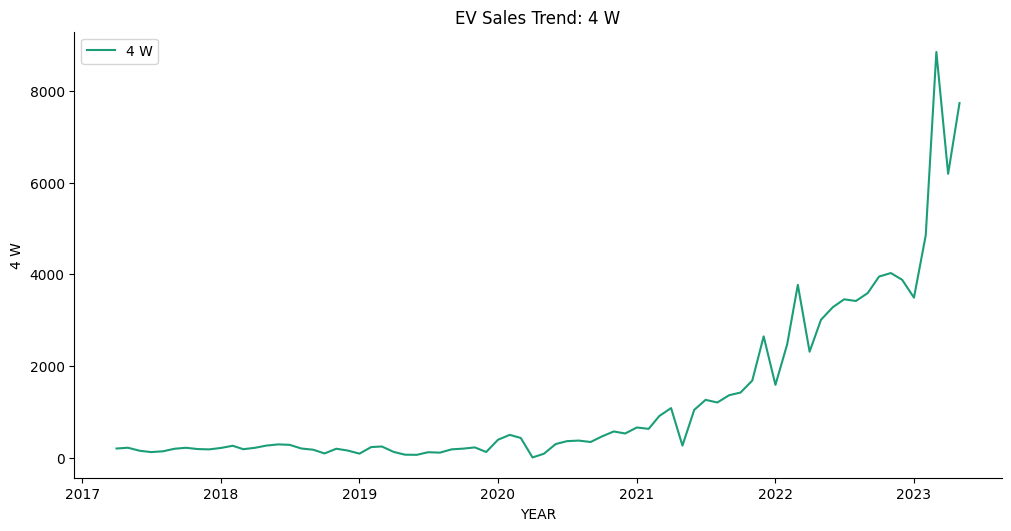

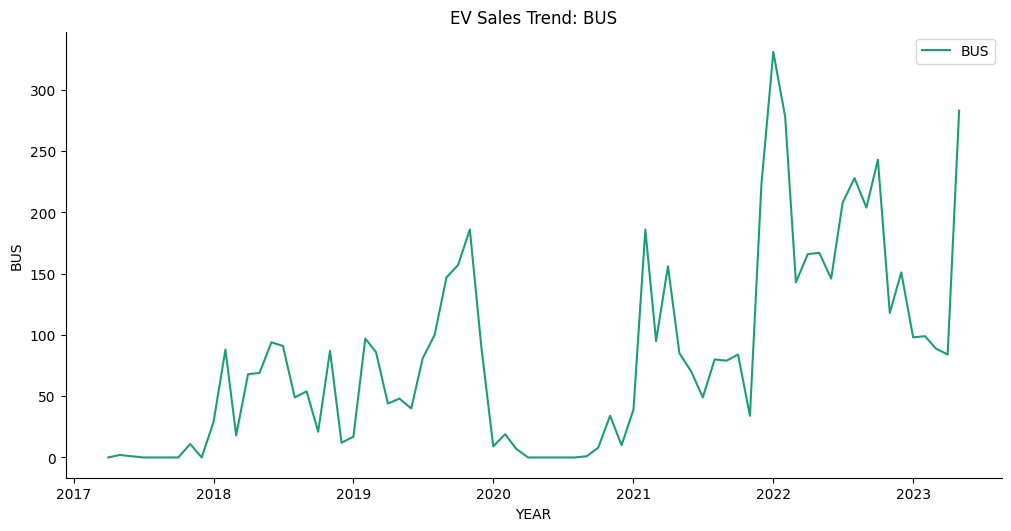

In [187]:
def plot_ev_sales(df, column_name, series_index=0):
    """
    Plots EV sales against YEAR for a given vehicle type column.

    Parameters:
    - df: DataFrame with at least 'YEAR' and the vehicle type column
    - column_name: column name like '2 W', '3 W', '4 W', 'BUS'
    - series_index: color index for plotting
    """
    palette = list(sns.palettes.mpl_palette('Dark2'))
    df_sorted = df.sort_values('YEAR', ascending=True)

    plt.figure(figsize=(10, 5.2), layout='constrained')
    plt.plot(df_sorted['YEAR'], df_sorted[column_name],
             label=column_name,
             color=palette[series_index % len(palette)])

    sns.despine()
    plt.xlabel('YEAR')
    plt.ylabel(column_name)
    plt.title(f'EV Sales Trend: {column_name}')
    plt.legend()
    plt.show()

plot_ev_sales(ev_sales, '2 W')
plot_ev_sales(ev_sales, '3 W')
plot_ev_sales(ev_sales, '4 W')
plot_ev_sales(ev_sales, 'BUS')

From all the above analysis, it is clear that total number of 2W sales are higher and is increasing a lot.

# **NASA Battery**

In [188]:
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

In [189]:
df = pd.read_csv("metadata.csv")
df.shape

(7565, 10)

In [190]:
df.head()

type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN  
1                 NaN  0.05605783343888099  0.20097016584458333  
2                 NaN                  NaN                  NaN  
3                 NaN  0.05319185850921101  0.16473399914864734  
4  1.5243662105099023                  NaN                  NaN

In [191]:
df = df.drop(columns=['start_time','battery_id','test_id','uid','filename'])
df.head()

type  ambient_temperature            Capacity                   Re  \
0  discharge                    4  1.6743047446975208                  NaN   
1  impedance                   24                 NaN  0.05605783343888099   
2     charge                    4                 NaN                  NaN   
3  impedance                   24                 NaN  0.05319185850921101   
4  discharge                    4  1.5243662105099023                  NaN   

                   Rct  
0                  NaN  
1  0.20097016584458333  
2                  NaN  
3  0.16473399914864734  
4                  NaN

In [192]:
df.isnull().sum()

type                      0
ambient_temperature       0
Capacity               4771
Re                     5609
Rct                    5609
dtype: int64

In [193]:
def convert_and_fill_mean(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].mean(), inplace=True)
convert_and_fill_mean(df, ['Re', 'Rct', 'Capacity'])
df.isnull().sum()

type                   0
ambient_temperature    0
Capacity               0
Re                     0
Rct                    0
dtype: int64

In [194]:
df.head()

type  ambient_temperature  Capacity            Re           Rct
0  discharge                    4  1.674305 -4.976500e+11  1.055903e+12
1  impedance                   24  1.326543  5.605783e-02  2.009702e-01
2     charge                    4  1.326543 -4.976500e+11  1.055903e+12
3  impedance                   24  1.326543  5.319186e-02  1.647340e-01
4  discharge                    4  1.524366 -4.976500e+11  1.055903e+12

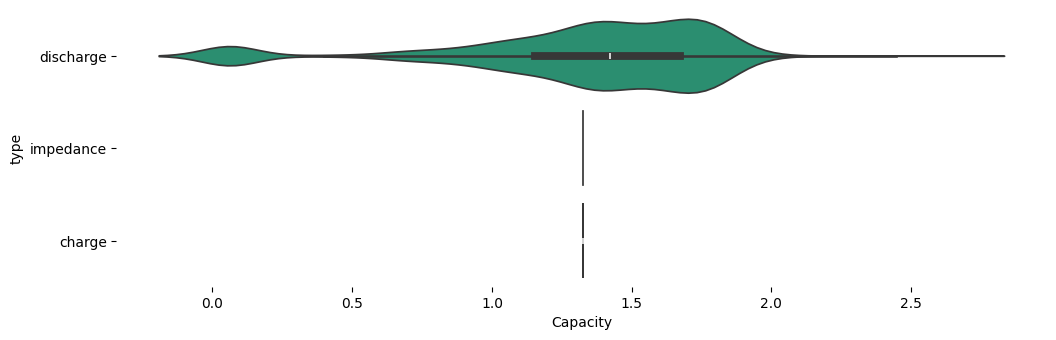

In [195]:
# type vs Capacity
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Capacity', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

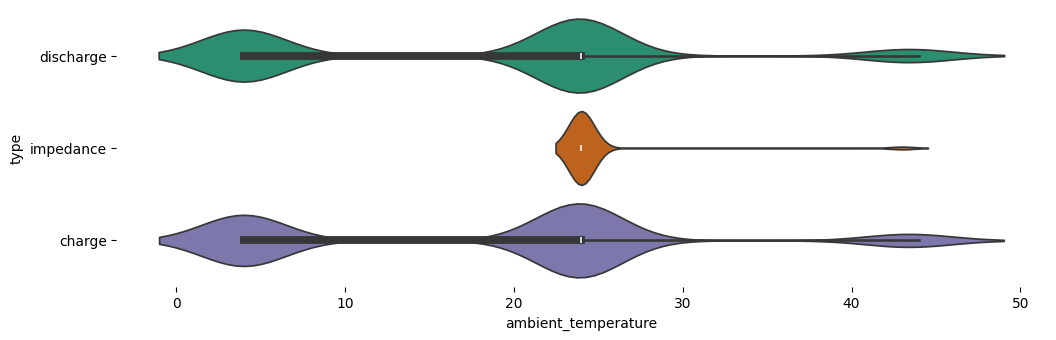

In [196]:
# type vs ambient_temperature
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='ambient_temperature', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [197]:
label_encoder = LabelEncoder()

df['type'] = label_encoder.fit_transform(df['type'])

In [198]:
df.head()

type  ambient_temperature  Capacity            Re           Rct
0     1                    4  1.674305 -4.976500e+11  1.055903e+12
1     2                   24  1.326543  5.605783e-02  2.009702e-01
2     0                    4  1.326543 -4.976500e+11  1.055903e+12
3     2                   24  1.326543  5.319186e-02  1.647340e-01
4     1                    4  1.524366 -4.976500e+11  1.055903e+12

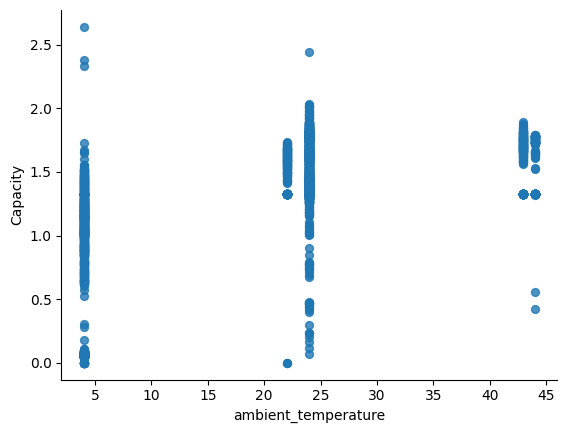

In [199]:
# ambient_temperature vs Capacity
df.plot(kind='scatter', x='ambient_temperature', y='Capacity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

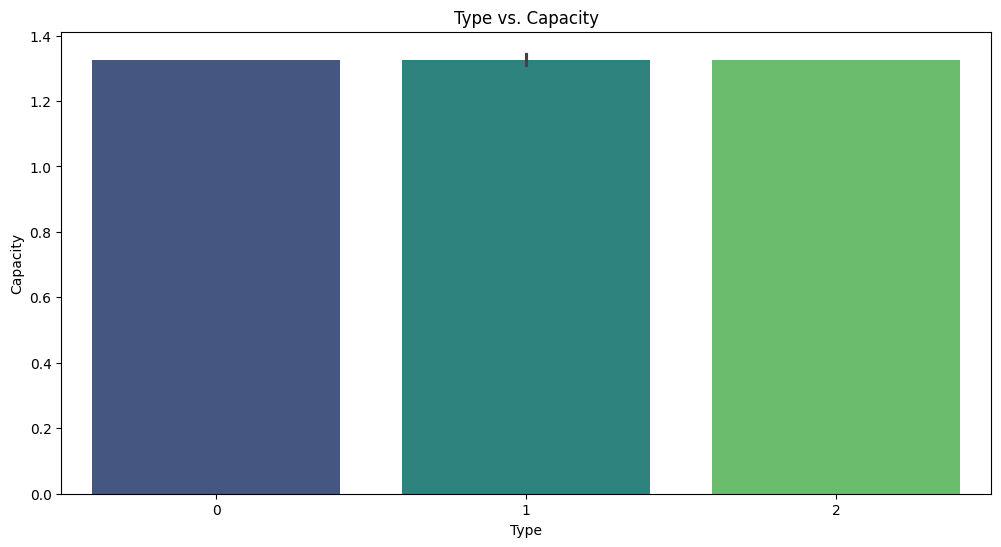

In [200]:
# Plot type vs capacity
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='type', y='Capacity', palette='viridis')
plt.title('Type vs. Capacity')
plt.xlabel('Type')
plt.ylabel('Capacity')
plt.show()

In [201]:
# Features (X) - All columns except 'ambient_temperature'
X = df.drop(columns=['ambient_temperature'])

# Target (y) - 'ambient_temperature' column
y = df['ambient_temperature']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the split data
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (6052, 4)
X_test shape: (1513, 4)


In [202]:
# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the training data, then transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the scaled data
print(f'Scaled X_train: \n{X_train_scaled[:5]}')

Scaled X_train: 
[[1.00000000e+00 5.02450122e-01 9.99999999e-01 1.98111482e-10]
 [5.00000000e-01 4.55998175e-01 0.00000000e+00 1.00000000e+00]
 [5.00000000e-01 3.60527766e-02 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 5.02450122e-01 0.00000000e+00 1.00000000e+00]
 [5.00000000e-01 5.35874070e-01 0.00000000e+00 1.00000000e+00]]


In [203]:
# Initialize the ANN model
model = Sequential()

# Input layer and first hidden layer with 64 units and ReLU activation
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Add Dropout layer with 0.2 rate (20% dropout)
model.add(Dropout(0.2))

# Second hidden layer with 32 units and ReLU activation
model.add(Dense(units=32, activation='relu'))

# Add another Dropout layer
model.add(Dropout(0.2))

# Output layer with 1 unit (for regression output), using a linear activation
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and Mean Squared Error loss (for regression)
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
# Train the model on the training data, using the test data for validation
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 380.2881 - val_loss: 55810.3047
Epoch 2/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 119.9921 - val_loss: 40635.4219
Epoch 3/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 112.5887 - val_loss: 30576.6152
Epoch 4/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109.5974 - val_loss: 21923.1465
Epoch 5/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109.9825 - val_loss: 19699.3770
Epoch 6/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.2094 - val_loss: 12460.1123
Epoch 7/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105.0679 - val_loss: 4026.6355
Epoch 8/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 98.6036 - val_loss: 2928.7131
Epoch 9/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 99.8306 - val_loss: 1426.3491
Epoch 10/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 98.2090 - val_loss: 740.3768
Epoch 11/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 100.8133 - val_

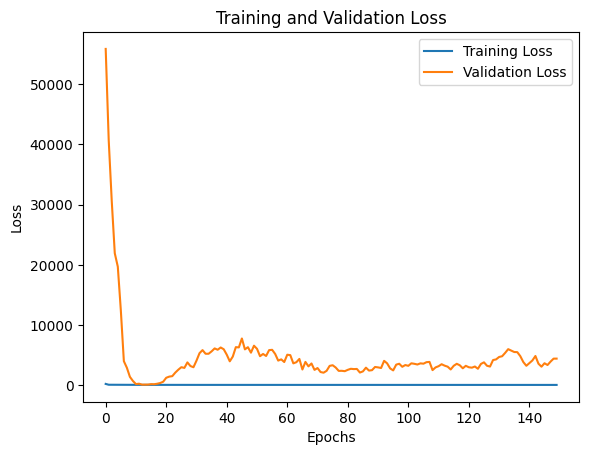

In [205]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [206]:
# Evaluate the model on the test data
mse = model.evaluate(X_test_scaled, y_test)

# Print the Mean Squared Error (MSE)
print(f'Mean Squared Error on test set: {mse}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14745.6846
Mean Squared Error on test set: 4449.05224609375


In [207]:
import numpy as np

def predict_battery_life(type_discharge, Capacity, Re, Rct, label_encoder, scaler, model):

    # Encode the categorical feature
    type_discharge_encoded = label_encoder.transform([type_discharge])[0]

    # Prepare the input feature vector
    X_input = np.array([[type_discharge_encoded,Capacity, Re, Rct]])

    # Scale the input features using the same scaler
    X_input_scaled = scaler.transform(X_input)

    # Predict the battery life (ambient_temperature)
    predicted_battery_life = model.predict(X_input_scaled)

    return predicted_battery_life[0]
# Example usage of the function
type_discharge = 'discharge'  # Example input for type
Capacity = 1.674305           # Example numeric value
Re = -4.976500e+11            # Example numeric value
Rct = 1.055903e+12            # Example numeric value

# Call the prediction function
predicted_battery_life = predict_battery_life(type_discharge, Capacity, Re, Rct, label_encoder, scaler, model)

print(f"Predicted Battery Life: {predicted_battery_life}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Battery Life: [26.146046]


In [208]:
# Example usage of the function with new input values
type_discharge = 'charge'  # New input for type
Capacity = 20.5            # Example numeric value for Capacity
Re = -2.983215e+11         # Example numeric value for Re
Rct = 1.223456e+12         # Example numeric value for Rct

# Call the prediction function with these new values
predicted_battery_life = predict_battery_life(type_discharge, Capacity, Re, Rct, label_encoder, scaler, model)

# Print the predicted battery life
print(f"Predicted Battery Life: {predicted_battery_life}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Battery Life: [340.92758]
